#**Definição de funções**

##FUNÇÕES GERAIS

###Metadados

In [ ]:
# Função de Metadados
def report_data(df, **kwargs):

  '''
  Função que cria um dataframe resumo de valores missing e outliers no dataframe original
  Argumento obrigatório: dataframe
  Argumento opcional: k (valor do fator de multiplicação para o cálculo do limite de outliers)
  '''

  df2 = pd.DataFrame()
  df2['Feature'] = list(df.columns)
  df2['Tipo'] = df.dtypes.values
  df2['Card'] = df.nunique().values
  df2['qtd miss'] = df.isnull().sum().values
  df2['%Miss'] = round(100 * df2['qtd miss'] / df.shape[0] , 1)


  Q1 = df.quantile(0.25)    #primeiro quartil (percentil 25)
  Q3 = df.quantile(0.75)    #terceiro quartil (percentil 75)
  IIQ = Q3 - Q1             #intervalo interquartil
  k = kwargs.get('k', 1.5)  #Fator multiplicador
  LS = Q3 + k*IIQ           #Limite superior
  LI = Q1 - k*IIQ           #Limite inferior

  df2['qtd out sup'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])>LS].count().values
  df2['%Out_sup'] = round(100 * df2['qtd out sup'] / df.shape[0] , 1)


  df2['qtd out inf'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])<LI].count().values
  df2['%Out_inf'] = round(100 * df2['qtd out inf'] / df.count().values , 1)

  df2['qtd outliers'] = df2['qtd out sup'] + df2['qtd out inf']
  df2['%Outliers'] = round(100 * df2['qtd outliers'] / df.count().values , 1)


  # Inicialize um DataFrame vazio para armazenar as modas e suas frequências percentuais
  moda_e_frequencia = pd.DataFrame(columns=['Moda', 'Frequência Percentual'])

  # Itere sobre as colunas do DataFrame
  for coluna in df.columns:
      moda_series = df[coluna].mode()

      if not moda_series.empty:
          moda = moda_series.values[0]
          frequencia = (df[coluna] == moda).mean() * 100
          moda_e_frequencia = moda_e_frequencia.append({'Moda': moda, '%Freq': round(frequencia, 1)}, ignore_index=True)
      else:
          # Lidar com o caso em que não há moda (lista vazia)
          moda_e_frequencia = moda_e_frequencia.append({'Moda': None, '%Freq': None}, ignore_index=True)


  df2['Moda'] = moda_e_frequencia['Moda']
  df2['%Freq'] = moda_e_frequencia['%Freq']


  # Quantidade de variáveis com valores faltantes:
  qtd_miss = df2.loc[df2['qtd miss']!= 0,'qtd miss'].count()

  # Quantidade de features numéricas e categóricas
  qtd_numerica = sum(list(df2.loc[(df2['Tipo']=='float') | (df2['Tipo']=='int32')|(df2['Tipo']=='int64'),['Feature']].count()))
  qtd_categorica = sum(list(df2.loc[df2['Tipo']=='object' , ['Feature']].count()))

  # Cálculo da cardinalidade total das variáveis categóricas
  qtd_card_tot = sum(list(df2.loc[(df2['Tipo']=='object') , ['Card']].sum()))

  # Cálculo da quantidade de linhas duplicadas
  dup = df.duplicated().sum()

  # Estilo ANSI para negrito e azul
  cor = "\033[0;34m"

  # Resetar estilo ANSI (para evitar que o texto seguinte também seja vermelho)
  resetar_estilo = "\033[0m"

  s1 = f'Quantidade de linhas duplicadas: {dup}'
  s2 = f'Quantidade de features com valores faltantes: {qtd_miss}'
  s3 = f'Quantidade de features numéricas: {qtd_numerica}'
  s4 = f'Quantidade de features categóricas {qtd_categorica}'
  s5 = f'Cardinalidade total das categóricas: {qtd_card_tot}'
  s6 = f'Dataframe: {df.shape[0]} linhas, {df.shape[1]} colunas'

  space= ' '
  print(cor)
  print(f'{s1}{space * (50-len(s1))}|    {s2}')
  print(f'{s3}{space * (50-len(s3))}|    {s4}')
  print(f'{s5}{space * (50-len(s5))}|    {s6}')
  print(resetar_estilo)

  # print(f'''{amarelo}
  # Quantidade de linhas duplicadas: {dup}  |  Quantidade de features com valores faltantes: {qtd_miss}
  # Quantidade de features numéricas: {qtd_numerica}  |  Quantidade de features categóricas {qtd_categorica}
  # Cardinalidade total das categóricas: {qtd_card_tot}  |  Dataframe: {df.shape[0]} linhas, {df.shape[1]} colunas
  #       {resetar_estilo}''')

  # Dropa colunas desnecessárias
  df2.drop(['qtd miss','qtd out sup' , 'qtd out inf', 'qtd outliers'], axis=1 , inplace=True)


  return df2

###Cálculo de métricas de classificação predict_proba

In [ ]:
def calculate_metrics(model_name, model, X_train, y_train, X_test, y_test):

    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])  #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1    #Cálculo do Gini

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1    #Cálculo do Gini

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [model_name, model_name],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df

###Cálculo de métricas de classificação predict

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import numpy as np

def calculate_metrics2(train_df, test_df, score_column, target_column, bins=10):
    def compute_metrics(df, score_column, target_column):
        df_sorted = df.sort_values(by=score_column, ascending=False)

        # Calcular KS
        df_sorted['cum_good'] = (1 - df_sorted[target_column]).cumsum() / (1 - df_sorted[target_column]).sum()
        df_sorted['cum_bad'] = df_sorted[target_column].cumsum() / df_sorted[target_column].sum()
        df_sorted['ks'] = np.abs(df_sorted['cum_good'] - df_sorted['cum_bad'])
        ks_statistic = df_sorted['ks'].max()

        # Calcular AUC
        auc_value = roc_auc_score(df_sorted[target_column], df_sorted[score_column])

        # Calcular Gini
        gini = 2 * auc_value - 1

        # Dividir o score em 10 faixas
        df_sorted['decile'] = pd.qcut(df_sorted[score_column], bins, labels=False)

        # Criar tabela detalhada
        table = df_sorted.groupby('decile').agg(
            min_score=pd.NamedAgg(column=score_column, aggfunc='min'),
            max_score=pd.NamedAgg(column=score_column, aggfunc='max'),
            event_rate=pd.NamedAgg(column=target_column, aggfunc='mean'),
            volume=pd.NamedAgg(column=target_column, aggfunc='size')
        ).reset_index()

        return ks_statistic, auc_value, gini, table

    ks_train, auc_train, gini_train, table_train = compute_metrics(train_df, score_column, target_column)
    ks_test, auc_test, gini_test, table_test = compute_metrics(test_df, score_column, target_column)

    # Plotando o gráfico de barras para Event Rate por Decil
    barWidth = 0.3
    r1 = np.arange(len(table_train))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, table_train['event_rate'], color='lightblue', width=barWidth, label='Train')
    plt.bar(r2, table_test['event_rate'], color='royalblue', width=barWidth, label='Test')

    plt.xlabel('Decile')
    plt.ylabel('Event Rate')
    plt.title('Event Rate by Decile')
    plt.xticks([r + barWidth for r in range(len(table_train))], table_train['decile'])
    plt.legend()
    plt.show()

    # Criando DataFrame para as métricas
    metrics_df = pd.DataFrame({
        'Metric': ['KS', 'AUC', 'Gini'],
        'Train Value': [ks_train, auc_train, gini_train],
        'Test Value': [ks_test, auc_test, gini_test]
    })

    return metrics_df, table_train, table_test

###Plotagem de métricas de classificação

In [ ]:
def plot_metrics(model, X_train, y_train, X_test, y_test):

    features = np.array(X_train.columns)

    plt.figure(figsize=(15, 18))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

###Ordenação de Scores - predict_proba

In [ ]:
def ordena_score(model, name_model, X_train, X_test, y_train, y_test):

  '''Para algoritmos que possem
  o método predict_proba como, por exemplo,
  algoritmos baseados em árvore (DT, RF, XGBM, etc)'''

  fix, ax = plt.subplots(1,2,figsize=(14, 6))

  # Previsão das probabilidades no conjunto de treino
  probabilidades = model.predict_proba(X_train)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_train})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento
  ax[0].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='steelblue')
  ax[0].set_title('Ordenação do Score - Treino - ' + name_model)
  ax[0].set_xlabel('Faixas de Score')
  ax[0].set_ylabel('Taxa de Evento')



  # Previsão das probabilidades no conjunto de teste
  probabilidades = model.predict_proba(X_test)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_test})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento

  ax[1].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='darkorange')
  ax[1].set_title('Ordenação do Score - Teste - ' + name_model)
  ax[1].set_xlabel('Faixas de Score')
  ax[1].set_ylabel('Taxa de Evento')


  plt.show()

### Ordenação de Score - predict

In [ ]:
def ordena_score2(name_model, X_train, X_test, y_train, y_test , prob_train , prob_test):

  '''Para algoritmos que não
  possuem o método predict_proba como,
  por exemplo, a egressão Logística da
  biblioteca "StatsModel"'''

  fix, ax = plt.subplots(1,2,figsize=(14, 6))

  # Previsão das probabilidades no conjunto de treino
  probabilidades = prob_train

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Arredonda com 10 casas decimais para não ter problema de duplicatas de limites de bins
  probabilidades=round(probabilidades , 10)

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_train})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento
  ax[0].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='steelblue')
  ax[0].set_title('Ordenação do Score - Treino - ' + name_model)
  ax[0].set_xlabel('Faixas de Score')
  ax[0].set_ylabel('Taxa de Evento')



  # Previsão das probabilidades no conjunto de teste
  probabilidades = prob_test

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_test})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False)

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento

  ax[1].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='darkorange')
  ax[1].set_title('Ordenação do Score - Teste - ' + name_model)
  ax[1].set_xlabel('Faixas de Score')
  ax[1].set_ylabel('Taxa de Evento')


  plt.show()

### Análise de carteira - predict_proba


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def carteira_treino(model, name_model, risk, X_train, y_train):

    '''
    Esta função:
    - É utilizada para algoritmos que POSSUEM o método predict_proba
    - Faz as predições de probabilidade de evento e não-evento
      da base passada como parâmetro.
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de cada faixa.
    - Gera uma linha horizontal que representa o apetite de
      risco assumido.
    - Analisa cada faixa e aplica cores diferentes nas
      barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
             (geralmente igual a inadimplência da carteira)
      - X_train: base usada no treinamento do modelo
      - y_train: target usada no treinamento do modelo

    Retorno:
      - Faixas de limites superiores e inferiores de cada
        faixa de score. Esta faixa poderá ser passada como
        parâmetro na função "carteira_teste"
        para que os limites das faixas sejam mantidos.
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------

    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o apetite de risco assumido
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para calcular as faixas (bins) e plotar o gráfico de barras dos dados de treino
    def plot_bar_chart(ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)
        df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')


        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Extraindo o limite superior de score das faixas
        faixas=[]
        for i in range(0,10):
          if i != 9:
            faixas.append(round(1000*df.loc[df['Deciles']==i ,'Probabilidades'].max()  , 0))
          else:
            faixas.append( 1000 )

        # Criando uma lista com os rótulos de cada bin
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {faixas[i]:.0f}')
          else:
            rotulos.append(f'{faixas[i-1]:.0f} - {faixas[i]:.0f}')

        # Agrupando os deciles e cálculando a média da propabilidade de evento em cada um
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')

        # Desligando o grid do gráfico secondário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 2 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 2 )

        return perc_aprovadas , perc_reprovadas , color_above, color_below , faixas , df



    # -------------------------------------------------------------
    # Chamando a função de plot para dados de treino
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de treino
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_train = model.predict_proba(X_train)[:, 0]

    # Adiciona um pequeno ruído às probabilidades
    noise_train = np.random.uniform(0, 0.0001, size=probabilidades_train.shape)
    probabilidades_train += noise_train

    # Plota o gráfico de barras para o conjunto de treino
    perc_apr , perc_rep , color_above, color_below , faixas , df= plot_bar_chart(ax, probabilidades_train, y_train, 'Faixas de score, volumetrias e taxa de evento - base de treino ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)


    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))



    plt.show()

    return faixas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def carteira_teste(faixas, model, name_model, risk, X_test, y_test):

    '''
    Esta função:
    - É utilizada para algoritmos que POSSUEM o método predict_proba
    - Faz as predições de probabilidade de evento e
      não-evento da base passada como parâmetro.
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de
      cada faixa.
    - Gera uma linha horizontal que representa o
      apetite de risco assumido.
    - Analisa cada faixa e aplica cores diferentes
      nas barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - faixas: lista de faixas gerada pela
        função "carteira_treino"
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
              (geralmente igual a inadimplência da carteira)
      - X_test: base usada para teste do modelo
      - y_test: target usada no para teste do modelo
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------


    # faixas = faixas
    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o risco
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para aplicar as faixas (bins) e plotar o gráfico de barras dos dados de teste
    def apply_deciles_plot_bar_chart(faixas, ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)

        # Ajustando os valores dos limites superiores e inferiores das faixas
        # que anteriormente tinham sido multiplicados por mil
        faixas = np.array(faixas)
        faixas=np.divide(faixas, 1000)
        faixas = faixas.tolist()

        # Adcionando o valor 0 no primeiro indice da lista de faixas
        faixas.insert(0, 0)

        # Aplica as faixas fornecidas
        df['Deciles'] = pd.cut(df['Probabilidades'], bins=faixas, labels=False, include_lowest=True)

        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Removendo novamente o valor Zero (que está no ídice Zero) para a lista ter
        # a mesma configuração do código anterior antes da extração dos rótulos
        faixas.pop(0)

        # Criando uma lista com os rótulos de cada bin, multiplicando por mil
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {1000*faixas[i]:.0f}')
          else:
            rotulos.append(f'{1000*faixas[i-1]:.0f} - {1000*faixas[i]:.0f}')


        # Clculo da média de probabilidade de taxa de evento em cada bin
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')


        # Desligando o grid do gráfico secundário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando a linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 1 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 1 )


        return perc_aprovadas , perc_reprovadas , color_above, color_below


    # -------------------------------------------------------------
    # Chamando a função de plot para dados de teste com os bins fixados
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de teste
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_test = model.predict_proba(X_test)[:, 0]

    # Adiciona um pequeno ruído às probabilidades
    noise_test = np.random.uniform(0, 0.0001, size=probabilidades_test.shape)
    probabilidades_test += noise_test

    # Plota o gráfico de barras para o conjunto de teste
    perc_apr , perc_rep , color_above, color_below = apply_deciles_plot_bar_chart (faixas, ax, probabilidades_test, y_test, 'Faixas de score, volumetrias e taxa de evento - base de teste ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)


    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))



    plt.show()

### Análise de carteira - predict

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def carteira_treino2(model, name_model, risk, X_train, y_train, prob_train):

    '''
    Esta função:
    - É utilizada para algoritmos que NÃO POSSUEM o método predict_proba
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de cada faixa.
    - Gera uma linha horizontal que representa o apetite de
      risco assumido.
    - Analisa cada faixa e aplica cores diferentes nas
      barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
             (geralmente igual a inadimplência da carteira)
      - X_train: base usada no treinamento do modelo
      - y_train: target usada no treinamento do modelo

    Retorno:
      - Faixas de limites superiores e inferiores de cada
        faixa de score. Esta faixa poderá ser passada como
        parâmetro na função "carteira_teste"
        para que os limites das faixas sejam mantidos.
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------

    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o apetite de risco assumido
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para calcular as faixas (bins) e plotar o gráfico de barras dos dados de treino
    def plot_bar_chart(ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)
        df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False)


        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Extraindo o limite superior de score das faixas
        faixas=[]
        for i in range(0,10):
          if i != 9:
            faixas.append(round(1000*df.loc[df['Deciles']==i ,'Probabilidades'].max()  , 5)) #5 casas decimais
          else:                                                                               # para não ocorrer
            faixas.append( 1000 )                                                             # problemas de duplicatas
                                                                                              # de limites de bins
        # Criando uma lista com os rótulos de cada bin
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {faixas[i]:.0f}')
          else:
            rotulos.append(f'{faixas[i-1]:.0f} - {faixas[i]:.0f}')

        # Agrupando os deciles e cálculando a média da propabilidade de evento em cada um
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')

        # Desligando o grid do gráfico secondário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 2 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 2 )

        return perc_aprovadas , perc_reprovadas , color_above, color_below , faixas , df



    # -------------------------------------------------------------
    # Chamando a função de plot para dados de treino
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de treino
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_train = prob_train

    # Adiciona um pequeno ruído às probabilidades
    noise_train = np.random.uniform(0, 0.0001, size=probabilidades_train.shape)
    probabilidades_train += noise_train

    # Plota o gráfico de barras para o conjunto de treino
    perc_apr , perc_rep , color_above, color_below , faixas , df= plot_bar_chart(ax, probabilidades_train, y_train, 'Faixas de score, volumetrias e taxa de evento - base de treino ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)

    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))


    plt.show()

    return faixas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def carteira_teste2(faixas, model, name_model, risk, X_test, y_test , prob_test):

    '''
    Esta função:
    - É utilizada para algoritmos que NÃO POSSUEM o método predict_proba
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de
      cada faixa.
    - Gera uma linha horizontal que representa o
      apetite de risco assumido.
    - Analisa cada faixa e aplica cores diferentes
      nas barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - faixas: lista de faixas gerada pela
        função "carteira_treino"
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
              (geralmente igual a inadimplência da carteira)
      - X_test: base usada para teste do modelo
      - y_test: target usada no para teste do modelo
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------


    # faixas = faixas
    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o risco
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para aplicar as faixas (bins) e plotar o gráfico de barras dos dados de teste
    def apply_deciles_plot_bar_chart(faixas, ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)

        # Ajustando os valores dos limites superiores e inferiores das faixas
        # que anteriormente tinham sido multiplicados por mil
        faixas = np.array(faixas)
        faixas=np.divide(faixas, 1000)
        faixas = faixas.tolist()

        # Adcionando o valor 0 no primeiro indice da lista de faixas
        faixas.insert(0, 0)

        # Aplica as faixas fornecidas
        df['Deciles'] = pd.cut(df['Probabilidades'], bins=faixas, labels=False, include_lowest=True)

        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Removendo novamente o valor Zero (que está no índice Zero) para a lista ter
        # a mesma configuração do código anterior antes da extração dos rótulos
        faixas.pop(0)

        # Criando uma lista com os rótulos de cada bin, multiplicando por mil
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {1000*faixas[i]:.0f}')
          else:
            rotulos.append(f'{1000*faixas[i-1]:.0f} - {1000*faixas[i]:.0f}')


        # Clculo da média de probabilidade de taxa de evento em cada bin
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')


        # Desligando o grid do gráfico secundário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando a linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 1 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 1 )


        return perc_aprovadas , perc_reprovadas , color_above, color_below


    # -------------------------------------------------------------
    # Chamando a função de plot para dados de teste com os bins fixados
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de teste
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_test = prob_test

    # Adiciona um pequeno ruído às probabilidades
    noise_test = np.random.uniform(0, 0.0001, size=probabilidades_test.shape)
    probabilidades_test += noise_test

    # Plota o gráfico de barras para o conjunto de teste
    perc_apr , perc_rep , color_above, color_below = apply_deciles_plot_bar_chart (faixas, ax, probabilidades_test, y_test, 'Faixas de score, volumetrias e taxa de evento - base de teste ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)


    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))

    plt.show()

###Plotagens de gráficos

In [ ]:
def plot_scatter(df, x_var, y_var, figsize, **kwargs):

    '''Função para plotar o gráfico de dispersão entre variáveis'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    label_size = kwargs.get('label_size', 11)
    grid = kwargs.get('grid', False)

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.scatterplot(data=df, x=x_var, y=y_var, color=color, marker=marker, ax=ax)

    ax.set_title(f'Scatter Plot entre "{x_var}" e "{y_var}"', pad=30, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(x_var, fontsize=9)
    ax.set_ylabel(y_var, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.show()

# =======================================================================================================================

def plot_hist(df, var, figsize, **kwargs):

    '''Função para plotar o histgrama de uma variável'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')

    bins = kwargs.get('bins', 30)  # Número de bins no histograma

    pad = kwargs.get('pad', 30)

    label_size = kwargs.get('label_size', 9)

    txt_rot = kwargs.get('txt_rot', 'v')

    stat = kwargs.get('stat', 'frequency')

    grid = kwargs.get('grid', False)


    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(data=df, x=var, bins=bins, color=color, ax=ax)

    ax.set_title(f'Histograma da variável "{var}"', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(var,  fontsize=9)
    ax.set_ylabel(stat, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=label_size)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=rotation)

    plt.show()

# =======================================================================================================================

def plot_bar(df, var, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras de uma única variável
    Pode ser entendido como o gráfico de distribuição das categorias de uma variável
    '''

    import textwrap  # Importe a função textwrap

    df_aux = df.copy()
    df_aux[var] = df_aux[var].astype(str)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    df_grouped = df_aux.groupby(var).size().sort_values(ascending=ascending)

    tot = df_grouped.sum()
    x = df_grouped.index

    mode = kwargs.get('mode', 'percent')
    cutoff = kwargs.get('corte', None)  # Novo argumento para o ponto de corte
    unity = kwargs.get('unity', '')

    if cutoff is not None:
        if mode == 'percent':
            cutoff_value = tot * (cutoff / 100)
            small_categories = df_grouped[df_grouped < cutoff_value].index
            df_grouped[f'Outros\n(<{cutoff}%)'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index
        elif mode == 'absolute':  # Handle cutoff for 'absolute' mode
            small_categories = df_grouped[df_grouped < cutoff].index
            df_grouped[f'Outros\n(<{cutoff}{unity})'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Variável "{var}"')


    if mode == 'percent':
        # Ajuste das proporções de acordo com o corte
        y = 100 * (df_grouped.values / df_grouped.values.sum())
        ylabel = 'Percentual (%)'
    elif mode == 'absolute':
        y = df_grouped.values
        ylabel = 'Número Absoluto'
    else:
        raise ValueError("O modo de exibição deve ser 'percent' ou 'absolute'.")

    if top is not None:
        # Exibir apenas as 10 primeiras barras, mas ajustar as proporções
        x = x[:top]
        y = y[:top]

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    # Use a função textwrap.fill para formatar os rótulos do eixo X
    x = [textwrap.fill(label, 15) for label in x]

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), visible=False)
    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        if mode == 'percent':
            display_value = str(round(v, decimals)) + " %"
        elif mode == 'absolute':
            display_value = str(int(v))
        ax.text(i, v + dist, display_value + ' ' + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.show()


# =======================================================================================================================

def plot_bar_2var(df, var_x, var_y, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras entre duas variáveis
    Recebe como entrada as variáveis dos eixos X e Y
    '''

    df_aux = df.copy()

    df_aux[var_x] = df_aux[var_x].astype(str)
    df_aux[var_y] = df_aux[var_y].astype(float)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    # Ordene o DataFrame com base no parâmetro "ascending"
    df_aux = df_aux.sort_values(by=var_y, ascending=ascending)

    # Aplicar o argumento "top" se especificado
    if top is not None:
        df_aux = df_aux.head(top)

    x = df_aux[var_x].tolist()
    y = df_aux[var_y].tolist()

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Gráfico de Barras de "{var_x}" por "{var_y}"')
    unity = kwargs.get('unity', '')

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})

    ax.set_xlabel(var_x)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        display_value = str(round(v, decimals))
        ax.text(i, v + dist, display_value + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.xticks(rotation=90)

    plt.show()


# =======================================================================================================================

def plot_batch_boxplot(dataframe, **kwargs):
    """
    Plota boxplots estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os boxplots serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param b: largura do subplot (opcional, padrão é 15).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    b = kwargs.get('b', 15)
    title = kwargs.get('title', None)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.boxplot(data=dataframe[column], ax=ax, color=color)
        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    if title is None:
      fig.suptitle("Análise descritiva - BoxPlot", fontsize=16, fontweight='bold', y=1.005)
    else:
      fig.suptitle(f"{title}", fontsize=16, fontweight='bold', y=1.005)

# =======================================================================================================================

def plot_batch_histogram(dataframe, **kwargs):
    """
    Plota histogramas estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os histogramas serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param label_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 9).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param kde: Se True, ativa KDE nos histogramas; se False, desativa (opcional, padrão é False).
    :param bins: Número de bins nos histogramas (opcional, padrão é 30).
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'frequency').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é False).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    kde = kwargs.get('kde', False)
    bins = kwargs.get('bins', 30)
    stat = kwargs.get('stat', 'frequency')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)
    hue = kwargs.get('hue', None)
    title = kwargs.get('title', None)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota histogramas para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]

        # Verificando se foi definida a variável semântica (hue)
        if hue == None:
          sns.histplot(data=dataframe[column], ax=ax, color=color, kde=kde, bins=bins, stat=stat)
        else:
          # sns.histplot(data=dataframe , x=column, ax=ax, color=color, kde=True, element='step', bins=bins, stat=stat, hue=hue)
          sns.kdeplot(data=dataframe, x=column,  ax=ax , fill=True , hue=hue)

        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel(stat)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
            ax.tick_params(axis='x', labelrotation=90)
            ax.get_yaxis().get_major_formatter().set_scientific(False)  # Formatação para números não em notação científica
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    if title is None:
      fig.suptitle("Análise descritiva - Histograma", fontsize=16, fontweight='bold', y=1.005)
    else:
      fig.suptitle(f"{title}", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

    # Exibe os gráficos
    plt.show()

# =======================================================================================================================

def plot_batch_scatter(dataframe, y_variable, **kwargs):
    """
    Plota scatter plots para todas as variáveis numéricas do dataframe fornecido,
    em relação a uma variável específica fornecida como y_variable.

    :param dataframe: DataFrame para o qual os scatter plots serão gerados.
    :param y_variable: Nome da variável que será usada como eixo y nos scatter plots.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param marker: Marcador para os pontos no scatter plot (opcional, padrão é 'o').
    :param grid: Se True, ativa o grid nos scatter plots; se False, desativa (opcional, padrão é True).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)
    title = kwargs.get('title', None)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota scatter plots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.scatterplot(x=dataframe[column], y=dataframe[y_variable], ax=ax, color=color, marker=marker)
        ax.set_title(f'{column} X {y_variable}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_xlabel(column)
        ax.set_ylabel(y_variable)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    if title is None:
      fig.suptitle(f"Análise de Scatter Plots - {y_variable}", fontsize=16, fontweight='bold', y=1.005)
    else:
      fig.suptitle(f"{title}", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

# =======================================================================================================================


def plot_batch_bar(dataframe, card_max, **kwargs):
    """
    Plota gráficos de barras para todas as variáveis categóricas do dataframe fornecido,
    desde que o número de categorias seja menor ou igual a card_max.

    :param dataframe: DataFrame para o qual os gráficos serão gerados.
    :param card_max: Número máximo de categorias para exibir os gráficos de barras.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 2).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'percent').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é True).
    :param ascending: Se True, ordena as categorias em ordem crescente; se False, em ordem decrescente (opcional, padrão é False).
    """

    # Argumentos opcionais
    cols = kwargs.get('cols', 2)
    num_size = kwargs.get('num_size', 11)
    color = kwargs.get('color', 'deepskyblue')
    stat = kwargs.get('stat', 'percent')
    grid = kwargs.get('grid', True)
    label_size = kwargs.get('label_size', 9)
    b = kwargs.get('b', 15)
    h_pad = kwargs.get('h_pad', 8)
    title = kwargs.get('title', None)

    # Filtra as colunas categóricas com até card_max categorias
    categorical_columns = [col for col in dataframe.columns if dataframe[col].dtype == 'object' or dataframe[col].dtype.name == 'category']

    # Calcula o número de linhas com base no número de colunas
    n_rows = (len(categorical_columns) + cols - 1) // cols

    # Configuração do tamanho da figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=cols, figsize=(b, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=h_pad)

    # Configuração do estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota gráficos de barras para cada coluna categórica
    for i, column in enumerate(categorical_columns):
        ax = axes[i // cols, i % cols]

        # Filtra as categorias com até card_max categorias
        counts = dataframe[column].value_counts()

        # Calcula o percentual em relação a todas as categorias
        counts_percent = (counts / counts.sum() * 100).sort_values(ascending=False)

        # Verifica se card_max é definido e, se for, pega as 30 maiores categorias
        if card_max is not None:
            counts_percent = counts_percent.head(card_max)

        if stat == 'percent':
            counts_percent.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Percentual (%)')
        else:
            counts.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Frequência Absoluta')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))  # Formata os valores do eixo Y

        ax.set_title(f'{column}', fontdict={'fontsize': 11, 'fontweight': 'bold'})
        ax.set_xlabel('')
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='x', labelrotation=90)  # Rotação de 90 graus nos rótulos do eixo X
        ax.tick_params(axis='x', labelsize=label_size)
        ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

        # Quebra de linha nos rótulos do eixo X
        ax.set_xticklabels([textwrap.fill(str(label), 12) for label in counts_percent.index], fontsize=9)

    # Remove gráficos vazios (se houver)
    for j in range(len(categorical_columns), n_rows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    if title is None:
      fig.suptitle("Análise descritiva - Gráfico de Barras", fontsize=16, fontweight='bold', y=1.005)
    else:
      fig.suptitle(f"{title}", fontsize=16, fontweight='bold', y=1.005)

    # Exibe os gráficos
    plt.show()


# =======================================================================================================================


def plot_pairplot(dataframe, hue=None, **kwargs):

    import seaborn as sns

    """
    Plota pair plots para todas as combinações de variáveis numéricas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os pair plots serão gerados.
    :param hue: Nome da variável que será usada para colorir os pontos (opcional).
    :param palette: Paleta de cores para a variável categórica (opcional).
    :param markers: Marcadores para os pontos no scatter plot (opcional, padrão é ['o', 's']).
    :param grid: Se True, ativa o grid nos scatter plots; se False, desativa (opcional, padrão é False).
    :param b: Largura da figura (opcional, padrão é 15).
    """
    # Argumentos opcionais
    palette = kwargs.get('palette', 'viridis')
    markers = kwargs.get('markers', ['o', 's'])
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)
    title = kwargs.get('title', None)
    corner = kwargs.get('corner', False)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Configuração da paleta de cores
    if hue:
        unique_values = dataframe[hue].nunique()
        if unique_values == 2:
            palette = {0: 'deepskyblue', 1: 'red'}  # Defina as cores desejadas
        else:
            palette = sns.color_palette(palette, n_colors=unique_values)

    # Plota pair plots usando seaborn
    sns.pairplot(dataframe, hue=hue, palette=palette, markers=markers , corner=corner)

    # Adiciona título principal
    if title is None:
      plt.suptitle("Análise de Pair Plots", fontsize=16, fontweight='bold', y=1.005)
    else:
      plt.suptitle(f"{title}", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        plt.grid(False)

    plt.show()


# =======================================================================================================================


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import textwrap

def plot_batch_bar_cluster(dataframe, card_max, hue=None, **kwargs):
    # Argumentos opcionais
    cols = kwargs.get('cols', 2)
    num_size = kwargs.get('num_size', 11)
    colors = kwargs.get('colors', ['deepskyblue', 'tomato'])
    grid = kwargs.get('grid', True)
    label_size = kwargs.get('label_size', 9)
    b = kwargs.get('b', 15)
    h_pad = kwargs.get('h_pad', 8)
    title = kwargs.get('title', None)

    # Filtra as colunas categóricas com até card_max categorias
    categorical_columns = [col for col in dataframe.columns if dataframe[col].dtype == 'object' and dataframe[col].nunique() <= card_max]


    # Calcula o número de linhas com base no número de colunas
    if cols==1:
      n_rows = len(categorical_columns)
    else:
      n_rows = (len(categorical_columns) + cols - 1) // cols

    # Configuração do tamanho da figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=cols, figsize=(b, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=h_pad)

    # Configuração do estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota gráficos de barras verticais empilhadas para cada coluna categórica
    for i, column in enumerate(categorical_columns):

        if cols == 1:
            ax = axes[min(i, n_rows - 1)]
        else:
            ax = axes[i // cols, i % cols]


        # Filtra as categorias com até card_max categorias
        counts = dataframe[column].value_counts()

        # Calcula o percentual em relação a todas as categorias
        counts_percent = (counts / counts.sum() * 100).sort_values(ascending=False)

        # Verifica se card_max é definido e, se for, pega as 30 maiores categorias
        if card_max is not None:
            counts_percent = counts_percent.head(card_max)

        # Plota gráfico de barras verticais empilhadas
        dataframe_grouped = dataframe.groupby([column, hue]).size().unstack()
        dataframe_grouped = dataframe_grouped.div(dataframe_grouped.sum(axis=1), axis=0) * 100
        bars = dataframe_grouped.plot(kind='bar', stacked=True, ax=ax, color=colors, edgecolor='black')

        # Adiciona rótulos para as barras empilhadas
        for bar in bars.patches:
            label_y = bar.get_y() + bar.get_height()
            label_y = label_y - 2 if bar.get_height() > 0 else label_y + 2

            # Adiciona a largura da barra para centralizar o rótulo
            label_x = bar.get_x() + bar.get_width() / 2

            ax.text(label_x, label_y-1,
                    f'{bar.get_height():.1f}%', ha='center', va='center',
                    color='white' if bar.get_height() > 25 else 'black', fontsize=label_size)

        ax.set_title(f'{column}', fontdict={'fontsize': 11, 'fontweight': 'bold'})
        ax.set_xlabel('')
        ax.set_ylabel('Percentual (%)')
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='x', labelrotation=90)  # Rotação de 90 graus nos rótulos do eixo X
        ax.tick_params(axis='x', labelsize=label_size)
        ax.tick_params(axis='y', labelsize=label_size)
        ax.legend(loc='lower right')
        ax.grid(grid)

        # Quebra de linha nos rótulos do eixo X
        ax.set_xticks(range(len(counts_percent)))

        # Utiliza os rótulos originais
        ax.set_xticklabels([textwrap.fill(str(label), 12) for label in counts_percent.index], fontsize=9)


    # Remove gráficos vazios (se houver)
    for j in range(len(categorical_columns), n_rows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    if title is not None:
      fig.suptitle(f"{title}", fontsize=16, fontweight='bold', y=1.005)
    else:
      fig.suptitle("Análise descritiva - Gráfico de Barras Verticais Empilhadas", fontsize=16, fontweight='bold', y=1.005)

    # Exibe os gráficos
    plt.show()

###Substitui outliers

In [ ]:
def replace_outliers(df, **kwargs):
  """
  Substitui outliers por NaN em um DataFrame para cada variável numérica.

  :param df: DataFrame de entrada.
  :param threshold: Limiar para identificar outliers (opcional, padrão é 1.5).
  :return: DataFrame com outliers substituídos por NaN.
  """
  df_copy = df.copy()
  k = kwargs.get('k', 1.5)

  # Itera sobre as colunas numéricas
  for column in df_copy.select_dtypes(include=['float64', 'int64']).columns:
      # Calcula o primeiro e terceiro quartis
      Q1 = df_copy[column].quantile(0.25)
      Q3 = df_copy[column].quantile(0.75)

      # Calcula o IQR (Intervalo Interquartil)
      IQR = Q3 - Q1

      # Define o limite inferior e superior para identificar outliers
      lower_limit = Q1 - k * IQR
      upper_limit = Q3 + k * IQR

      # Substitui os outliers por NaN
      df_copy[column] = df_copy[column].apply(lambda x: np.nan if x < lower_limit or x > upper_limit else x)

  return df_copy

###Feature Selection por Feature Importance (Árvores)

In [ ]:
def fs_importance(model, X, y, cutoff_importance, plot, figsize=None, model_name=None):

  # Treinamento
  model.fit(X, y)

  # Extraindo a importância das variáveis
  feature_importances = model.feature_importances_
  features = pd.DataFrame({ 'Feature': X.columns, 'Importance': feature_importances })

  # Ordenar variáveis por importância
  features = features.sort_values(by='Importance', ascending=False)

  # Estabelecer um limite de corte, por exemplo, x% da importância máxima
  cutoff_maximp = cutoff_importance

  cutoff = cutoff_maximp * feature_importances.max()

  # Selecionar variáveis acima do corte
  selected_features = X.columns[feature_importances >= cutoff].tolist()

  # Selecionar variáveis abaixo do corte
  not_selected_features = X.columns[feature_importances < cutoff].tolist()

  # Visualizando a importância das variáveis em barras horizontais
  if figsize==None:
    plt.figure(figsize=(10, 6))
  else:
    plt.figure(figsize=figsize)

  sorted_idx = feature_importances.argsort()

  print(f'\nFeatures removidas: {len(not_selected_features)}')

  print(f'Features remanescentes: {len(selected_features)}\n')

  lim_plot = 60 #Limite de variáveis para plotar o gráfico

  if plot==True: #and len(features) <= lim_plot:
    plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color='dodgerblue')  # tom de azul claro
    plt.xlabel("Feature Importance")
    if model_name == None:
      plt.title(f"Feature Importance")
    else:
      plt.title(f"Feature Importance com {model_name}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axvline(x=cutoff, color='r', linestyle='--', label=f'Ponto de corte = {100*cutoff_maximp:.1f} %\nda importância máxima')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
  else:
    print(f'\033[1;33mO gráfico não será exibido pois a quantidade total de features é maior que {lim_plot}.\033[0m\n')

  return selected_features

###Feature selection por Information Value

In [ ]:
# Feature selection com IV Values
  # Utilizado quando se tem target binário
  # Recomendado ser implementado num conjunto já reduzido
  # por uma etapa preliminar de feature selection
  # Pode captar variáveis preditoras "Fracas", que passaram pelas
  # etapas anteriores. Assim, pode-se removê-las diretamente nesta etapa
  # ou voltar á etapa anterior e "apertar" o funil (que é a sugestão)

# Função para discretizar as variáveis numéricas
def discretize_numeric_features(df, bins):
    df_discretized = df.copy()
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32'] and len(df[col].unique()) > bins:
            df_discretized[col] = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
    return df_discretized

# Função para calcular o IV de uma variável já discretizada
def calculate_iv(df, feature, target):
    lst = []
    for value in df[feature].unique():
        lst.append({
            'Value': value,
            'All': df[df[feature] == value].count()[feature],
            'Good': df[(df[feature] == value) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == value) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = (dset['Good'] + 0.0001) / (dset['Good'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['Distr_Bad'] = (dset['Bad'] + 0.0001) / (dset['Bad'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    return dset['IV'].sum()


# Função que avalia e retorna o IV da variável
def classify_iv(iv_value):
    if iv_value < 0.02:
        return "Muito Fraco"
    elif iv_value < 0.1:
        return "Fraco"
    elif iv_value < 0.3:
        return "Moderado"
    elif iv_value < 0.5:
        return "Forte"
    else:
        return "Muito Forte"

# Função que chama todas as outras e cria um dataframe com a IV de cada variável
# Observação passar o dataframe inteiro (ao invés de só as explicativas) e especificar a target
def select_features_by_iv_discretized(df, target, iv_cutoff_ratio=1.0, bins=10):
    from tqdm import tqdm
    df = discretize_numeric_features(df, bins)

    iv_stats = []
    for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
        if col != target:
            iv_value = calculate_iv(df, col, target)
            iv_stats.append({
                'Variable': col,
                'IV': iv_value,
                'Predictiveness': classify_iv(iv_value)
            })

    iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
    max_iv = iv_df['IV'].max()
    cutoff_value = iv_cutoff_ratio * max_iv
    selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

    return selected_features, iv_df

###Feature selection por PCA

In [ ]:
def fs_pca(X , variance_explained , features_per_component):

  # Feature selection com redução de dimensionalidade através do PCA
  # Método não supervisionado
  # Não indicado para quando existe a target (modelo ou análise de dados)

  from sklearn.decomposition import PCA

  # Percentual da variância que os compentes devem ser capazes de explicar
  variance = variance_explained

  # Número de features mais representativas em cada componente
  n=features_per_component

  # Instanciando - Mantendo componentes que expliquem 95% da variância do modelo
  pca = PCA(n_components = variance)

  # Treinando
  pca.fit(X)

  # Obtém os autovetores (componentes principais) e a variância explicada
  eigen_vectors = pca.components_
  explained_variance = pca.explained_variance_ratio_

  # Cria um DataFrame para armazenar as informações
  result_df = pd.DataFrame()

  # Loop através dos autovetores (componentes)
  for i in range(len(eigen_vectors)):
      # Obtém as cargas absolutas dos componentes do autovetor atual
      component_loadings = np.abs(eigen_vectors[i])

      # Ordena os índices das variáveis em ordem decrescente de carga
      sorted_indices = np.argsort(component_loadings)[::-1][:n]

      # Obtém o nome das n variáveis de maior carga
      top_n_variable_names = X.columns[sorted_indices].tolist()

      # Cria um dicionário com as informações
      info = {'Componente': f'Componente {i + 1}',
          'Vari. Expl.': explained_variance[i],}

      for j, var_name in enumerate(top_n_variable_names, start=1):
          info[f'Feature {j}'] = var_name

      # Adiciona as informações ao DataFrame
      result_df = result_df.append(info, ignore_index=True)

  # Exibe o DataFrame resultante
  result_df

  # Extrai e exibe as features selecionadas
  list_var_pca = result_df.iloc[:,2:].values
  list_var_pca = list(set(item for array in list_var_pca for item in array))

  return list_var_pca, result_df

###Feature selection por variância e correlação

In [ ]:
def fs_variance_and_correlation(X , y , model, threshold_variance, threshold_correlation):

  # Dropagem de features com baixa variância e features altamente correlacionadas

  # ------------------------------------------------------------------------------------------------------
  # Dropando features de baixa variância

  # Definindo o limiar (queremos manter as variáveis que têm uma variância superior ao valor definido)
  # Se colocar valor 0 (zero) apenas variáveis constantes serão descartadas
  threshold = threshold_variance
  selector = VarianceThreshold(threshold)

  # Aplicando transformação (já remove as variáveis)
  selector.fit_transform(X)

  # Lista de colunas selecionadas
  selected_features = X.columns[selector.get_support()]
  discarded_features = X.columns[~selector.get_support()]

  # Eliminando
  X.drop(discarded_features , axis = 1, inplace = True)


  # ------------------------------------------------------------------------------------------------------
  # Dropando features altamente correlacionadas
  # Este algoritmo identifica as features correlacionadas e mantém aquela que ocasionará
  # o melhor desempenho do modelo. Existe um outra biblioteca (DropCorrelatedFeatures)
  # que elimina apenas as features correlacionadas, sem identificar aquela de melhor
  # desempenho no modelo

  # Instanciando validação cruzada estratificada
  # skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # shuffle=False --> Não embaralha // random_state=None --> sem semente para embaralhamento

  # Instanciando
  # smart_corr_selection = SmartCorrelatedSelection(method='pearson',threshold=0.75,selection_method='model_performance',estimator=RandomForestClassifier(random_state=42),cv=skf)
  smart_corr_selection = SmartCorrelatedSelection(method='pearson', threshold = threshold_correlation,
                                                  selection_method='model_performance',
                                                  estimator = model, cv=5 )

  # Aplicando transformação (já remove as variáveis)
  X = smart_corr_selection.fit_transform(X , y)

  # Lista de features remanescentes
  remaining_features_corr = list(X.columns)

  # Lista de features removidas
  droped_features_corr = list(smart_corr_selection.features_to_drop_)

  print(f'\nFeatures de baixa variância removidas: {len(discarded_features)}')

  print(f'Features de alta correlação removidas: {len(droped_features_corr)}')

  print(f'Features remanescentes: {len(remaining_features_corr)}\n')

  return remaining_features_corr

###Feature selection por Boruta

In [ ]:
def fs_boruta(X, y):

  # Feature selection com Boruta
  # recomendado Processar em lotes
  # Exemplo: 2 lotes de 5 mil variáveis / 4 lotes de 2500 variáveis...
  # ... Juntar as que sobraram e fazer uma rodada final
  # Ajustar de acordo com a velocidade que se deseja para o processamento
  # Outra alternativa e rodar iterativamente o Boruta
  # Não é necessário definir explicitamente um limiar de importância ao usar o Boruta.
  # O algoritmo faz essa escolha internamente com base na lógica de
  # comparação entre as características reais e as de sombra (shadow).

  model = RandomForestClassifier()

  # Define o método Boruta
  feat_selector = BorutaPy(model , n_estimators='auto', verbose=0, random_state=42)

  # Executa o Boruta
  feat_selector.fit(X.values, y)

  # Obtém as variáveis selecionadas
  selected_features_boruta = X.columns[feat_selector.support_].tolist()

  # Obtenha as características não selecionadas
  features_not_selected = X.columns[~feat_selector.support_].tolist()

  return selected_features_boruta

###Feature selection por Eliminação Recursiva (RFE)

In [ ]:
def fs_rfe(X , y , model, n_vars_keep):
  # Funciona para um escopo pequeno de variáveis
  # Sugestão: até 1000 variáveis

  # Eliminação recursiva de features

  # Total de features
  tot = len(list(X.columns))

  # Instancie o RFE e selecione 2 variáveis
  n_vars_keep = n_vars_keep

  # Instancie o RFE
  rfe = RFE(estimator=model, n_features_to_select=n_vars_keep)
  fit = rfe.fit(X, y)

  selected_features_rfe = list(X.columns[fit.support_])


  print(f'\nFeatures removidas: {tot-n_vars_keep}')

  print(f'Features remanescentes: {n_vars_keep}\n')


  return selected_features_rfe

##FUNÇÕES PARA CRÉDITO

###Dataprep out-of-time

In [ ]:
def dataprep_out_of_time(df, target, col_id , metadados, col_safra,
                         safra_min_train, safra_max_train,
                         safra_min_test, safra_max_test, **kwargs):

  '''
  ----------------------------------------------------------------------------------------------
  Variáveis de entrada da função
  ----------------------------------------------------------------------------------------------

  df                = tabela analítica de modelagem inicial que será ajustada em uma nova tabela

  target            = nome da coluna que contém a target

  col_id            = nome da coluna que contém os ID's. Se não houver ID', passar como 'None'

  metadados         = metadados da tabela analítica de modelagem inicial

  col_safra         = Coluna que contém a target

  safra_min_train   = Safra mais antiga para treino. Formato: string 'AAAAMM'

  safra_max_train   = Safra mais recente para treino. Formato: string 'AAAAMM'

  safra_min_test    = Safra mais antiga para teste. Formato: string 'AAAAMM'

  safra_max_test    = Safra mais recente para teste. Formato: string 'AAAAMM'

  convert_target    = True, se for aplicar LabelEncoder na Target, ou False, caso contrário.

  lim_miss          = limite percentual de valores nulos para dropagem da coluna

  lim_card          = limite de cardinalidade para utilização do encoder:
                      - colunas com cardinalidade menor ou igual ao valor: utilizado OneHotEnconder;
                      - colunas com cardinalidade maior que o valor: utilizado LabelEncoder;
                      - valor só é útil se o encoder especificado for 'onehot+label'.

  encoder_method    = método que irá fazer a codificação das variáveis categóricas:
                      - 'onehot+label': OneHotEncoder nas de baixa card. e LabelEncoder nas de alta car;
                      - 'catboost': CatBoostEncoder em todas as variáveis;
                      - None: Não aplica encoder em nenhuma variável categórica (se houver).

  scaled            = Informa quais variáveis serão padronizadas:
                      - False: nenhuma variável;
                      - True: todas as variáveis;
                      - 'num': se houver variáveis categóricas, será aplicado nas originalmente numéricas.

  cat_input         = Valor para imputação das categóricas com valores nulos


  ----------------------------------------------------------------------------------------------
  Descrição
  ----------------------------------------------------------------------------------------------

  Função para automação da etapa de preparação dos dados com abordagem out-of-time
  Esta função salva as diversas etapas de transformação dos
  dados de treino (X_train) e de teste (X_test).
  A função também retorna todos os conjuntos de dados e os artefatos
  utilizados na transformação, como os encoders, o scaler, as medianas imputadas e etc,
  além dos ID's e das colunas de safras.


  ----------------------------------------------------------------------------------------------
  Exemplo de uso
  ----------------------------------------------------------------------------------------------

  dataprep_01 = dataprep_out_of_time(df=abt_00, target='Default', metadados=metadados_00,
                                      lim_miss=70, lim_card=20, scaled=False,
                                      encoder_method='onehot+label', convert_target=False,
                                      safra='Safra',  safra_min_train = '202209', safra_max_train='202307',
                                      safra_min_test='202308', safra_max_test='202310')
  '''


  #----------------------------------------------------------------------------------------------
  # Argumentos opcionais
  #----------------------------------------------------------------------------------------------

  lim_miss = kwargs.get('lim_miss', 70)
  lim_card = kwargs.get('lim_card', 20)
  convert_target = kwargs.get('convert_target', False)
  encoder_method = kwargs.get('encoder_method', None)
  scaled = kwargs.get('scaled', False)
  # cat_input = kwargs.get('cat_input', 'sem_info')


  #----------------------------------------------------------------------------------------------
  # Separando dados de treino e teste antes de qualquer manipulação - evitar DataLeakage
  #----------------------------------------------------------------------------------------------


  # Convertendo a coluna de safra para string.
  # Pode ser necessário ajustar preliminarmente dependendo de como esta coluna veio formatada
  df[col_safra] = df[col_safra].apply(lambda x: str(x))


  # Dados de treino
  train = df[(df[col_safra] >= safra_min_train) & (df[col_safra] <= safra_max_train)]
  X_train = train.drop(target, axis=1)
  y_train = train[target]

  # Dados de teste
  test = df[(df[col_safra] >= safra_min_test) & (df[col_safra] <= safra_max_test)]
  X_test = test.drop(target, axis=1)
  y_test = test[target]


  #----------------------------------------------------------------------------------------------
  # Salvando backup das colunas com os dados das Safras
  #----------------------------------------------------------------------------------------------

  # Backup da coluna onde estão as safras dos dados de treino e dos dados de teste
  col_safra_train = X_train[col_safra]  #treino
  col_safra_test = X_test[col_safra]    #teste

  # Dropando a coluna de safra dos dados de treino e dos dados de teste
  X_train.drop(col_safra, axis=1, inplace=True)   #treino
  X_test.drop(col_safra, axis=1, inplace=True)    #teste


  #----------------------------------------------------------------------------------------------
  # Salvando backup das colunas com os dados de ID's
  #----------------------------------------------------------------------------------------------

  # Se não foi informada a coluna de ID's...
  if col_id == None:

    # Armazena uma string nao invés dos ID's
    col_id_train = 'Não informado'
    col_id_test = 'Não informado'


  # Se a coluna de ID's foi informada...
  else:

    # Backup da coluna onde estão os ID's dos dados de treino e dos dados de teste
    col_id_train = X_train[col_id]   #treino
    col_id_test = X_test[col_id]     #teste

    # Dropando a coluna de ID's dos dados de treino e dos dados de teste
    X_train.drop(col_id, axis=1, inplace=True)   #treino
    X_test.drop(col_id, axis=1, inplace=True)    #teste


  #----------------------------------------------------------------------------------------------
  # Dropando colunas com alto percentual de missing
  #----------------------------------------------------------------------------------------------

  # Limites
  lim_miss = lim_miss

  # Lista de variáveis com miss acima do limiar
  list_var_drop = list(metadados.loc[metadados['%Miss'] > lim_miss, 'Feature'])

  # Dropando em X_train
  X_train.drop(list_var_drop, axis=1, inplace=True)

  # Dropando em X_test
  X_test.drop(list_var_drop, axis=1, inplace=True)


  #----------------------------------------------------------------------------------------------
  # Definindo colunas numéricas e categóricas
  #----------------------------------------------------------------------------------------------

  num_var = list(X_train.select_dtypes(include=('int', 'int32','int64','float', 'float32' , 'float64')).columns)
  cat_var = list(X_train.select_dtypes(include='object').columns)


  #----------------------------------------------------------------------------------------------
  # Imputando valores
  #----------------------------------------------------------------------------------------------

  # Dicionário vazio para armazenar os inputs de miss
  list_miss_input = {}

  # Iterando pelas colunas numéricas
  for i in num_var:
    # Verificando se existe valor nulo na coluna
    if X_train[i].isna().any() == True:
      mediana = X_train[i].median()                #Econtra a mediana a partir dos daods de treino
      X_train[i].fillna(mediana , inplace=True)    #Imputa a mediana nos dados de treino
      X_test[i].fillna(mediana , inplace=True)     #Imputa a mediana nos dados de teste
      list_miss_input[i] = mediana                 #Acrescenta o par chave/valor ao dicionário

  # Iterando pelas colunas categóricas
  for i in cat_var:
    # Verificando se existe valor nulo na coluna
      X_train[i].fillna('sem-info' , inplace=True)    #Imputa a mediana nos dados de treino
      X_test[i].fillna('sem-info' , inplace=True)     #Imputa a mediana nos dados de teste
      list_miss_input[i] = 'sem-info'                 #Acrescenta o par chave/valor ao dicionário


  #----------------------------------------------------------------------------------------------
  # Codificação da target
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import LabelEncoder

  if convert_target == True:      #Caso a target precise ser convertida
    # Instanciando
    encoder_target = LabelEncoder()

    # Aplicando treino e teste
    y_train = encoder_target.fit_transform(y_train)     #Fit e transform
    y_test = encoder_target.transform(y_test)           #Apenas transform

  elif convert_target == False:   # Caso a target não precise ser convertida
    encoder_target = 'Não aplicado'


  #----------------------------------------------------------------------------------------------
  # Codificação de variáveis categóricas
  #----------------------------------------------------------------------------------------------

  # Caso não seja aplicado nenhum encoder nas variáveis
  if encoder_method == None:
      X_train_enc = 'Não aplicado'
      X_test_enc = 'Não aplicado'

  #Caso seja aplicado algum encoder nas variáveis
  else:

      # Copiando
      X_train_enc = X_train.copy()
      X_test_enc = X_test.copy()

      # Limite de cardinalidade para aplicar um ou outro encoder
      lim_card = lim_card

      # Separando variáveis de alta e baixa cardinalidade
      alta_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() > lim_card])
      baixa_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() <= lim_card])

      # Se foi definido OneHotEncoder + LabelEncoder
      if encoder_method == 'onehot+label':

          # Importando os pacotes
          from sklearn.preprocessing import LabelEncoder, OneHotEncoder

          # Instanciando - Label Encoder nas de alta cardinalidade
          # >>> Necessário fazer um loop para salvar o Encoder de cada feature numa lista
          # >>> Label encoder não da pra aplicar em mais de uma Feature
          label_encoder = LabelEncoder()

          # Inicializa um dicionário para salvaro label encoder de cada coluna
          dict_label_encoder = {}

          # Label encoder - alta cardinalidade
          for i in alta_card:
              X_train_enc[i] = label_encoder.fit_transform(X_train_enc[i]) #Fit_transform nos dados de treino
              X_test_enc[i] = label_encoder.transform(X_test_enc[i])       #Somente transform nos dados de teste
              dict_label_encoder[i] = label_encoder                        #Salva o encoder. A chave é a coluna i, e o valor é o encoder

          # Crie e aplique o OneHotEncoder
          OneHot_encoder = OneHotEncoder(sparse=False, drop='first')

          # Aplicando OneHotEncoding nos conjuntos de treino e teste
          encoded_data = OneHot_encoder.fit_transform(X_train_enc[baixa_card]) #Fit_transform nos dados de treino

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_cols = OneHot_encoder.get_feature_names_out(baixa_card)
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols + '_dummy', index=X_train_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_train
          X_train_enc = pd.concat([X_train_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

          # Aplicando OneHotEncoding em X_test
          encoded_data = OneHot_encoder.transform(X_test_enc[baixa_card]) #Somente transform nos dados de teste

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols + '_dummy', index=X_test_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_test
          X_test_enc = pd.concat([X_test_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

      # Se foi definido Catboost
      elif encoder_method == 'catboost':

          # Importando o pacote
          from category_encoders import CatBoostEncoder

          # Instanciando
          cat_encoder = CatBoostEncoder(cols=cat_var)

          # Aplicando as transformações
          X_train_enc = cat_encoder.fit_transform(X_train_enc, y_train)  #fit.transform
          X_test_enc = cat_encoder.transform(X_test_enc)                 #somente "transform"


  #----------------------------------------------------------------------------------------------
  # Padronização dos dados (não precisa para árvores)
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import StandardScaler

  # Se foi selecionado algum encoder para categorizar as variáveis
  if encoder_method != None:

      # Criando cópia
      X_train_enc_std = X_train_enc.copy()
      X_test_enc_std = X_test_enc.copy()

      # Instanciando
      scaler = StandardScaler()

      # Se foi selecionado que o scaler será aplicado somente nas colunas originalmente numéricas
      # Ou seja, encoder nas categóricas + scaler nas numéricas
      if scaled == 'num':
          qtd_scaler = len(num_var)  # Quantidade de variáveis (igual a quantidade de numéricas) ao qual foi aplicado o scaler
          list_var_scaled = num_var  # Lista de variáveis que passarão pelo scaler, que é a lista de variáveis originalmente numéricas
          X_train_enc_std[num_var] = scaler.fit_transform(X_train_enc_std[num_var])  # Aplica fit_transform nos dados de treino
          X_test_enc_std[num_var] = scaler.transform(X_test_enc_std[num_var])        # Somente transform nos dados de teste

      # Se foi selecionado que o scaler será aplicado em todas as colunas (numéricas e categóricas) (após o encoder das categóricas)
      # Ou seja, encoder nas categóricas + scaler em todas
      elif scaled == True:
          qtd_scaler = len(list(X_train_enc.columns))  # Quantidade de variáveis da base categorizada ao qual foi aplicado o scaler
          list_var_scaled = list(X_train_enc.columns)  # Lista de variáveis da base categorizada que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, somente encoder nas categóricas e sem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'


  # Se não foi selecionado nenhum encoder, também não deixa padronizar nada <<<
  # Ou seja, não aplica nem encoder nas categóricas, >>> e nem scaler em nada <<<
  elif encoder_method == None:

      # Criando cópia para os dados padronizados
      X_train_enc_std = X_train.copy() # Nota: o termo "_enc_" foi mantido apenas
      X_test_enc_std = X_test.copy()   # para que não se tenha necessidade de
                                       # ajustar mais o código mas, na verdade
                                       # esses dados não passaram por encoder
                                       # e foram copiados diretamente
                                       # de X_train e X_test. Nesse caso, nas linhas
                                       # acima, X_train_enc e X_test_enc já receberam
                                       # o valor "Não aplicado"

      # Se foi selecionado que o scaler será aplicado somente nas numéricas. Nesse caso, se não houver categóricas, todas as features serão padronizadas
      # Ou seja, sem encoder em nenhuma categórica + scaler em todas as numéricas
      if scaled == 'num':
          qtd_scaler = len(list(X_train.columns))  # Quantidade de variáveis ao qual foi aplicado o scaler
          list_var_scaled = list(X_train.columns)  # Lista de variáveis que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, nem encoder nas categóricas e nem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'



  #----------------------------------------------------------------------------------------------
  # Objetos finais
  #----------------------------------------------------------------------------------------------

  # Se não foi usado nenhum encoder
  if encoder_method == None:

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado'''


  # Se foi utilizado OneHotEncoder + LabelEncoder
  elif encoder_method == 'onehot+label':

      one_hot_enc = OneHot_encoder
      label_enc = dict_label_encoder
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = baixa_card
      list_var_LabelEncoder = alta_card
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: {len(baixa_card)}
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: {len(alta_card)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''


  # Se foi utilizado CatboostEncoder
  elif encoder_method == 'catboost':

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = cat_encoder
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = cat_var

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: {len(cat_var)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''



  class DataPrepResult:
      def __init__(self, X_train, X_train_enc, X_train_enc_std, X_test,
                    X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                    list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                    list_var_scaled, list_var_drop, list_miss_input,
                    one_hot_enc, label_enc, catboost_enc, encoder_target,
                    col_safra_train, safra_min_train, safra_max_train,
                    col_safra_test, safra_min_test, safra_max_test,
                    col_id_train , col_id_test, resume):

          self.X_train = X_train
          self.X_train_enc = X_train_enc
          self.X_train_enc_std = X_train_enc_std
          self.X_test = X_test
          self.X_test_enc = X_test_enc
          self.X_test_enc_std = X_test_enc_std
          self.y_train = y_train
          self.y_test = y_test
          self.scaler = scaler
          self.list_var_OneHotEncoder = list_var_OneHotEncoder
          self.list_var_LabelEncoder = list_var_LabelEncoder
          self.list_var_CatBoostEncoder = list_var_CatBoostEncoder
          self.list_var_scaled = list_var_scaled
          self.list_var_drop = list_var_drop
          self.list_miss_input = list_miss_input
          self.one_hot_enc = one_hot_enc
          self.label_enc = label_enc
          self.catboost_enc = catboost_enc
          self.encoder_target = encoder_target
          self.col_safra_train = col_safra_train
          self.safra_min_train = safra_min_train
          self.safra_max_train = safra_max_train
          self.col_safra_test = col_safra_test
          self.safra_min_test = safra_min_test
          self.safra_max_test = safra_max_test
          self.col_id_train = col_id_train
          self.col_id_test = col_id_test
          self.resume = resume


  return DataPrepResult(X_train, X_train_enc, X_train_enc_std, X_test,
                        X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                        list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                        list_var_scaled, list_var_drop, list_miss_input,
                        one_hot_enc, label_enc, catboost_enc, encoder_target,
                        col_safra_train, safra_min_train, safra_max_train,
                        col_safra_test, safra_min_test, safra_max_test,
                        col_id_train, col_id_test, resume)


###Dataprep out-of-sample

In [ ]:
def dataprep_out_of_sample(df, target, col_id , metadados, **kwargs):


  #----------------------------------------------------------------------------------------------
  # Argumentos opcionais
  #----------------------------------------------------------------------------------------------

  lim_miss = kwargs.get('lim_miss', 70)
  lim_card = kwargs.get('lim_card', 20)
  convert_target = kwargs.get('convert_target', False)
  encoder_method = kwargs.get('encoder_method', None)
  scaled = kwargs.get('scaled', False)
  stratify = kwargs.get('stratify', 'no')
  # cat_input = kwargs.get('cat_input', 'sem info')
  random_state = kwargs.get('random_state', 42)


  #----------------------------------------------------------------------------------------------
  # Variáveis de entrada da função
  #----------------------------------------------------------------------------------------------

  # df              = tabela analítica de modelagem inicial que será ajustada em uma nova tabela

  # target          = nome da coluna que contém a target

  # col_id          = nome da coluna que contém os ID's. Se não houver ID', passar como 'None'

  # metadados       = metadados da tabela analítica de modelagem inicial

  # convert_target  = True, se for aplicar LabelEncoder na Target, ou False, caso contrário.

  # lim_miss        = limite percentual de valores nulos para dropagem da coluna

  # lim_card        = limite de cardinalidade para utilização do encoder:
  #                   - colunas com cardinalidade menor ou igual ao valor: utilizado OneHotEnconder;
  #                   - colunas com cardinalidade maior que o valor: utilizado LabelEncoder;
  #                   - valor só é útil se o encoder especificado for 'onehot+label'.

  # encoder_method  = método que irá fazer a codificação das variáveis categóricas:
  #                   - 'onehot+label': OneHotEncoder nas de baixa card. e LabelEncoder nas de alta car;
  #                   - 'catboost': CatBoostEncoder em todas as variáveis;
  #                   - None: Não aplica encoder em nenhuma variável categórica (se houver).

  # scaled          = Informa quais variáveis serão padronizadas:
  #                   - False: nenhuma variável;
  #                   - True: todas as variáveis;
  #                   - 'num': se houver variáveis categóricas, será aplicado nas originalmente numéricas.

  # stratify        = Informa se o split de dados de treino/teste será estratificado em relação à tareget

  # cat_input       = Valor para imputação das categóricas com valores nulos (foi inutilizado)

  # random_state    = valor paraa semente aleatória para split dos dados de treino e teste


  #----------------------------------------------------------------------------------------------
  # Descrição
  #----------------------------------------------------------------------------------------------

  # Função para automação da etapa de preparação dos dados
  # Esta função salva as diversas etapas de transformação dos
  # dados de treino (X_train) e de teste (X_test).
  # A função também retorna todos os conjuntos de dados e os artefatos
  # utilizados na transformação, como os encoders, o scaler, as medianas imputadas, etc


  #----------------------------------------------------------------------------------------------
  # Exemplo de uso
  #----------------------------------------------------------------------------------------------

  # dataprep_01 = dataprep_out_of_time(df=abt_00, target='Default', metadados=metadados_00,
  #                                     lim_miss=70, lim_card=20, scaled=False,
  #                                     encoder_method='onehot+label', convert_target=False)


  #----------------------------------------------------------------------------------------------
  # Separando dados de treino e teste antes de qualquer manipulação - evitar DataLeakage
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.model_selection import train_test_split

  # Divisão X e Y
  X = df.drop(target, axis=1)
  y = df[target]

  # Divisão treino e teste
  if stratify=='no':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)                  #sem estratificação
  elif stratify == 'yes':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)      #estratifica pela target


  #----------------------------------------------------------------------------------------------
  # Salvando backup das colunas com os dados de ID's
  #----------------------------------------------------------------------------------------------

  # Se não foi informada a coluna de ID's...
  if col_id == None:

    # Armazena uma string ao invés dos ID's
    col_id_train = 'Não informado'
    col_id_test = 'Não informado'


  # Se a coluna de ID's foi informada...
  else:

    # Backup da coluna onde estão os ID's dos dados de treino e dos dados de teste
    col_id_train = X_train[col_id]   #treino
    col_id_test = X_test[col_id]     #teste

    # Dropando a coluna de ID's dos dados de treino e dos dados de teste
    X_train.drop(col_id, axis=1, inplace=True)   #treino
    X_test.drop(col_id, axis=1, inplace=True)    #teste


  #----------------------------------------------------------------------------------------------
  # Dropando colunas com alto percentual de missing
  #----------------------------------------------------------------------------------------------

  # Limites
  lim_miss = lim_miss

  # Lista de variáveis com miss acima do limiar
  list_var_drop = list(metadados.loc[metadados['%Miss'] > lim_miss, 'Feature'])

  # Dropando em X_train
  X_train.drop(list_var_drop, axis=1, inplace=True)

  # Dropando em X_test
  X_test.drop(list_var_drop, axis=1, inplace=True)


  #----------------------------------------------------------------------------------------------
  # Definindo colunas numéricas e categóricas
  #----------------------------------------------------------------------------------------------

  num_var = list(X_train.select_dtypes(include=('int32','int64','float')).columns)
  cat_var = list(X_train.select_dtypes(include='object').columns)


  #----------------------------------------------------------------------------------------------
  # Imputando valores
  #----------------------------------------------------------------------------------------------

  # Dicionário vazio para armazenar os inputs de miss
  list_miss_input = {}

  # Iterando pelas colunas numéricas
  for i in num_var:
    # Verificando se existe valor nulo na coluna
    if X_train[i].isna().any() == True:
      mediana = X_train[i].median()                   #Econtra a mediana a partir dos daods de treino
      X_train[i].fillna(mediana , inplace=True)       #Imputa a mediana nos dados de treino
      X_test[i].fillna(mediana , inplace=True)        #Imputa a mediana nos dados de teste
      list_miss_input[i] = mediana                    #Acrescenta o par chave/valor ao dicionário

  # Iterando pelas colunas categóricas
  for i in cat_var:

    # Verificando se existe valor nulo na coluna
      X_train[i].fillna('sem-info' , inplace=True)    #Imputa a mediana nos dados de treino
      X_test[i].fillna('sem-info' , inplace=True)     #Imputa a mediana nos dados de teste
      list_miss_input[i] = 'sem-info'                 #Acrescenta o par chave/valor ao dicionário
      # Observação:
      # não imputar strings com "underline"
      # para não afetar no rastreio das dummies
      # que possuem o sufixo '_dummy'


  #----------------------------------------------------------------------------------------------
  # Codificação da target
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import LabelEncoder

  if convert_target == True:      #Caso a target precise ser convertida
    # Instanciando
    encoder_target = LabelEncoder()

    # Aplicando treino e teste
    y_train = encoder_target.fit_transform(y_train)     #Fit e transform
    y_test = encoder_target.transform(y_test)           #Apenas transform

  elif convert_target == False:   # Caso a target não precise ser convertida
    encoder_target = 'Não aplicado'


  #----------------------------------------------------------------------------------------------
  # Codificação de variáveis categóricas
  #----------------------------------------------------------------------------------------------

  # Caso não seja aplicado nenhum encoder nas variáveis
  if encoder_method == None:
      X_train_enc = 'Não aplicado'
      X_test_enc = 'Não aplicado'

  #Caso seja aplicado algum encoder nas variáveis
  else:

      # Copiando
      X_train_enc = X_train.copy()
      X_test_enc = X_test.copy()

      # Limite de cardinalidade para aplicar um ou outro encoder
      lim_card = lim_card

      # Separando variáveis de alta e baixa cardinalidade
      alta_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() > lim_card])
      baixa_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() <= lim_card])

      # Se foi definido OneHotEncoder + LabelEncoder
      if encoder_method == 'onehot+label':

          # Importando os pacotes
          from sklearn.preprocessing import LabelEncoder, OneHotEncoder

          # Instanciando - Label Encoder nas de alta cardinalidade
          # >>> Necessário fazer um loop para salvar o Encoder de cada feature numa lista
          # >>> Label encoder não dá pra aplicar em mais de uma Feature
          label_encoder = LabelEncoder()

          # Inicializa um dicionário para salvaro label encoder de cada coluna
          dict_label_encoder = {}

          # Label encoder - alta cardinalidade
          for i in alta_card:
              X_train_enc[i] = label_encoder.fit_transform(X_train_enc[i]) #Fit_transform nos dados de treino
              X_test_enc[i] = label_encoder.transform(X_test_enc[i])       #Somente transform nos dados de teste
              dict_label_encoder[i] = label_encoder                        #Salva o encoder. A chave é a coluna i, e o valor é o encoder

          # Crie e aplique o OneHotEncoder
          OneHot_encoder = OneHotEncoder(sparse=False, drop='first')

          # Aplicando OneHotEncoding nos conjuntos de treino e teste
          encoded_data = OneHot_encoder.fit_transform(X_train_enc[baixa_card]) #Fit_transform nos dados de treino

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_cols = OneHot_encoder.get_feature_names_out(baixa_card)
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols+'_dummy', index=X_train_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_train
          X_train_enc = pd.concat([X_train_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

          # Aplicando OneHotEncoding em X_test
          encoded_data = OneHot_encoder.transform(X_test_enc[baixa_card]) #Somente transform nos dados de teste

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols+'_dummy', index=X_test_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_test
          X_test_enc = pd.concat([X_test_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

      # Se foi definido Catboost
      elif encoder_method == 'catboost':

          # Importando o pacote
          from category_encoders import CatBoostEncoder

          # Instanciando
          cat_encoder = CatBoostEncoder(cols=cat_var)

          # Aplicando as transformações
          X_train_enc = cat_encoder.fit_transform(X_train_enc, y_train)  #fit.transform
          X_test_enc = cat_encoder.transform(X_test_enc)                 #somente "transform"


  #----------------------------------------------------------------------------------------------
  # Padronização dos dados (não precisa para árvores)
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import StandardScaler

  # Se foi selecionado algum encoder para categorizar as variáveis
  if encoder_method != None:

      # Criando cópia dos dados categorizados
      X_train_enc_std = X_train_enc.copy()
      X_test_enc_std = X_test_enc.copy()

      # Instanciando
      scaler = StandardScaler()

      # Se foi selecionado que o scaler será aplicado somente nas colunas originalmente numéricas
      # Ou seja, encoder nas categóricas + scaler nas numéricas
      if scaled == 'num':
          qtd_scaler = len(num_var)  # Quantidade de variáveis (igual a quantidade de numéricas) ao qual foi aplicado o scaler
          list_var_scaled = num_var  # Lista de variáveis que passarão pelo scaler, que é a lista de variáveis originalmente numéricas
          X_train_enc_std[num_var] = scaler.fit_transform(X_train_enc_std[num_var])  # Aplica fit_transform nos dados de treino
          X_test_enc_std[num_var] = scaler.transform(X_test_enc_std[num_var])        # Somente transform nos dados de teste

      # Se foi selecionado que o scaler será aplicado em todas as colunas (numéricas e categóricas) (após o encoder das categóricas)
      # Ou seja, encoder nas categóricas + scaler em todas
      elif scaled == True:
          qtd_scaler = len(list(X_train_enc.columns))         # Quantidade de variáveis da base categorizada ao qual foi aplicado o scaler
          list_var_scaled = list(X_train_enc.columns)         # Lista de variáveis da base categorizada que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, somente encoder nas categóricas e sem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'


  # Se não foi selecionado nenhum encoder, também não deixa padronizar nada <<<
  # Ou seja, não aplica nem encoder nas categóricas, >>> e nem scaler em nada <<<
  elif encoder_method == None:

      # Criando cópia para os dados padronizados
      X_train_enc_std = X_train.copy() # Nota: o termo "_enc_" foi mantido apenas
      X_test_enc_std = X_test.copy()   # para que não se tenha necessidade de
                                       # ajustar mais o código mas, na verdade
                                       # esses dados não passaram por encoder
                                       # e foram copiados diretamente
                                       # de X_train e X_test. Nesse caso, nas linhas
                                       # acima, X_train_enc e X_test_enc já receberam
                                       # o valor "Não aplicado"

      # Se foi selecionado que o scaler será aplicado somente nas numéricas. Nesse caso, se não houver categóricas, todas as features serão padronizadas
      # Ou seja, sem encoder em nenhuma categórica + scaler em todas as numéricas
      if scaled == 'num':
          qtd_scaler = len(list(X_train.columns))  # Quantidade de variáveis ao qual foi aplicado o scaler
          list_var_scaled = list(X_train.columns)  # Lista de variáveis que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, nem encoder nas categóricas e nem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'



  #----------------------------------------------------------------------------------------------
  # Objetos finais
  #----------------------------------------------------------------------------------------------

  # Se não foi usado nenhum encoder
  if encoder_method == None:

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado'''

  # Se foi utilizado OneHotEncoder + LabelEncoder
  elif encoder_method == 'onehot+label':

      one_hot_enc = OneHot_encoder
      label_enc = dict_label_encoder
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = baixa_card
      list_var_LabelEncoder = alta_card
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: {len(baixa_card)}
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: {len(alta_card)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''

  # Se foi utilizado CatboostEncoder
  elif encoder_method == 'catboost':

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = cat_encoder
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = cat_var

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: {len(cat_var)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''



  class DataPrepResult:
      def __init__(self, X_train, X_train_enc, X_train_enc_std, X_test,
                    X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                    list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                    list_var_scaled, list_var_drop, list_miss_input,
                    one_hot_enc, label_enc, catboost_enc, encoder_target,
                    col_id_train , col_id_test, resume):

          self.X_train = X_train
          self.X_train_enc = X_train_enc
          self.X_train_enc_std = X_train_enc_std
          self.X_test = X_test
          self.X_test_enc = X_test_enc
          self.X_test_enc_std = X_test_enc_std
          self.y_train = y_train
          self.y_test = y_test
          self.scaler = scaler
          self.list_var_OneHotEncoder = list_var_OneHotEncoder
          self.list_var_LabelEncoder = list_var_LabelEncoder
          self.list_var_CatBoostEncoder = list_var_CatBoostEncoder
          self.list_var_scaled = list_var_scaled
          self.list_var_drop = list_var_drop
          self.list_miss_input = list_miss_input
          self.one_hot_enc = one_hot_enc
          self.label_enc = label_enc
          self.catboost_enc = catboost_enc
          self.encoder_target = encoder_target
          self.col_id_train = col_id_train
          self.col_id_test = col_id_test
          self.resume = resume



  return DataPrepResult(X_train, X_train_enc, X_train_enc_std, X_test,
                        X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                        list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                        list_var_scaled, list_var_drop, list_miss_input,
                        one_hot_enc, label_enc, catboost_enc, encoder_target,
                        col_id_train , col_id_test, resume)


###Plota taxa de evento Vs volumetria das safras

In [ ]:
def plot_tx_event_volume_safra(dataframe, target, safra, ymax_volume=None, ymax_taxa_evento=None, rot_label=None, figsize=None):

  #target = coluna onde está a target / evento
  #safra = coluna onde está a safra da instância
  # ymax_volume = limite do eixo Y para o volume
  # ymax_taxa_evento = limite do eixo Y para a taxa de evento

  import matplotlib.pyplot as plt
  import pandas as pd
  import numpy as np

  # Converte a coluna 'var' para string se seu tipo não for string
  if dataframe[safra].dtype != 'O':
      dataframe[safra] = dataframe[safra].astype(str)

  # Calcule a média do TARGET_60_6 e o volume por AAAAMM
  resultado = dataframe.groupby(safra).agg({target: 'mean', safra: 'count'}).rename(columns={safra: 'Volume'}).reset_index()
  resultado.columns = ['Safra', 'Taxa_de_Evento', 'Volume']

  # Gráfico com barras para o volume e linha para a taxa de evento por safra (AAAAMM)
  if figsize==None:
    fig, ax1 = plt.subplots(figsize=(12, 6))
  else:
    fig, ax1 = plt.subplots(figsize=figsize)

  color = 'lightblue'
  ax1.bar(resultado['Safra'], resultado['Volume'], color=color, label='Volume')
  ax1.set_xlabel('Safra')
  ax1.set_xticklabels(resultado['Safra'], rotation=rot_label)
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')
  if ymax_volume:
      ax1.set_ylim(0, ymax_volume)

  ax2 = ax1.twinx()
  color = 'hotpink'
  ax2.plot(resultado['Safra'], resultado['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color=color, label='Taxa de Evento (%)')
  ax2.set_ylabel('Taxa de Evento (%)', color='black')
  ax2.tick_params(axis='y', labelcolor='black')
  if ymax_taxa_evento:
      ax2.set_ylim(0, ymax_taxa_evento)

  for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
      label.set_fontsize(12)
      label.set_color('black')

  plt.title('Volume e Taxa de Evento por Safra')
  plt.legend(loc='upper left')
  plt.show()

  return resultado

###Plota taxa de evento Vs Categorias da Feature

In [ ]:
def analyze_variable(dataframe, variable, target, figsize=None):

  # Dataframe, variável para ser analisada, target

  import pandas as pd
  import matplotlib.pyplot as plt

  # Se a variável for numérica, arredonda para 4 casas decimais
  if pd.api.types.is_numeric_dtype(dataframe[variable]):
      dataframe[variable] = dataframe[variable].round(4)
      dataframe[variable] = dataframe[variable].astype(str)

  # Calcula a taxa de evento e o volume para cada categoria da variável
  result = dataframe.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
  result.columns = [variable, 'Taxa_de_Evento', 'Volume']

  # Ordena o resultado pela Taxa de Evento em ordem decrescente
  result = result.sort_values(by='Taxa_de_Evento', ascending=False)

  # Plota o gráfico
  if figsize==None:
    fig, ax1 = plt.subplots(figsize=(12, 6))
  else:
    fig, ax1 = plt.subplots(figsize=figsize)

  # Eixo Y esquerdo: Volume
  bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
  ax1.set_xlabel(variable)
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento
  ax2 = ax1.twinx()
  lines = ax2.plot(result[variable], result['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
  ax2.set_ylabel('Taxa de Evento (%)', color='black')
  ax2.tick_params(axis='y', labelcolor='black')

  # Combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'
  plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
  labels = [plot.get_label() for plot in plots]
  plt.legend(plots, labels, loc='upper left')

  plt.title(f'Volume e Taxa de Evento por {variable}' , pad=20)
  plt.xticks(rotation=45)  # Adicionado para melhor visualização dos labels no eixo X
  plt.tight_layout()

  ax1.grid(False)
  ax2.grid(False)
  plt.legend(loc='best')

  plt.show()

  return result




def analyze_variable_train_and_test(train, test, variable, target, figsize=None):

  import pandas as pd
  import matplotlib.pyplot as plt

  # Concatenate train and test datasets
  concatenated_data = pd.concat([train, test], keys=['Train', 'Test'], names=['Dataset'])

  # Se a variável for numérica, arredonda para 4 casas decimais
  if pd.api.types.is_numeric_dtype(concatenated_data[variable]):
      concatenated_data[variable] = concatenated_data[variable].round(4)
      concatenated_data[variable] = concatenated_data[variable].astype(str)

  # Calcula a taxa de evento e o volume para cada categoria da variável
  result = concatenated_data.groupby([variable, 'Dataset']).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
  result.columns = [variable, 'Dataset', 'Taxa_de_Evento', 'Volume']

  # Ordena o resultado pela Taxa de Evento em ordem decrescente
  result = result.sort_values(by=['Dataset', 'Taxa_de_Evento'], ascending=[True, False])

  # Plota o gráfico
  if figsize == None:
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  else:
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

  # Aumenta o espaçamento horizontal entre gráficos
  plt.subplots_adjust(wspace=0.5)

  # Eixo Y esquerdo: Volume - Train
  bars_train = ax1.bar(result[result['Dataset'] == 'Train'][variable], result[result['Dataset'] == 'Train']['Volume'], color='lightblue', label='Volume (Barras)')
  ax1.set_xlabel(variable)
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento - Train
  ax2_train = ax1.twinx()
  lines_train = ax2_train.plot(result[result['Dataset'] == 'Train'][variable], result[result['Dataset'] == 'Train']['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink')
  ax2_train.set_ylabel('Taxa de Evento (%)', color='black')
  ax2_train.tick_params(axis='y', labelcolor='black')

  # Adiciona título ao gráfico de Treino
  ax1.set_title('Treino')
  plt.grid(False)

  # Eixo Y esquerdo: Volume - Test
  bars_test = ax2.bar(result[result['Dataset'] == 'Test'][variable], result[result['Dataset'] == 'Test']['Volume'], color='lightblue', label='Volume (Barras)')
  ax2.set_xlabel(variable)
  ax2.set_ylabel('Volume', color='black')
  ax2.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento - Test
  ax2_test = ax2.twinx()
  lines_test = ax2_test.plot(result[result['Dataset'] == 'Test'][variable], result[result['Dataset'] == 'Test']['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink')

  # Adiciona legendas apenas para as linhas - Train
  ax2_train.legend(lines_train, ['Taxa de Evento'], loc='best')

  # Adiciona legendas apenas para as linhas - Test
  ax2_test.legend(lines_test, ['Taxa de Evento'], loc='best')

  # Adiciona título ao gráfico de Teste
  ax2.set_title('Teste')

  # Aumenta o espaçamento vertical entre linhas
  plt.subplots_adjust(hspace=0.5)

  plt.suptitle(f'Volume e Taxa de Evento por {variable}', y=1.05, fontsize=13)
  plt.xticks(rotation=45)  # Adicionado para melhor visualização dos labels no eixo X
  plt.tight_layout()

  ax1.grid(False)
  ax2.grid(False)
  plt.grid(False)

  return result


###Plota estabilidade temporal da taxa de evento Vs Categorias da Feature

In [ ]:
def plot_by_safra(dataframe, target, explicativa, safra):

  import pandas as pd
  import matplotlib.pyplot as plt

  df_copy = dataframe.copy()
  # Se a variável explicativa for numérica, arredonda para 4 casas decimais e converte para string
  if pd.api.types.is_numeric_dtype(df_copy[explicativa]):
      df_copy[explicativa] = df_copy[explicativa].apply(lambda x: round(x, 4)).astype(str)

  # Calcula a taxa de evento e o volume por safra e categoria da variável explicativa
  result = df_copy.groupby([safra, explicativa]).agg({target: 'mean', explicativa: 'count'}).rename(columns={explicativa: 'Volume'}).reset_index()

  # Plota o gráfico
  fig, ax1 = plt.subplots(figsize=(12, 6))

  # Eixo Y esquerdo: Volume total por safra
  volume_by_safra = result.groupby(safra).agg({'Volume': 'sum'}).reset_index()
  bars = ax1.bar(volume_by_safra[safra], volume_by_safra['Volume'], color='lightblue', label='Volume Total (Barras)')
  ax1.set_xlabel('Safra')
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento por categoria
  ax2 = ax1.twinx()
  for category in result[explicativa].unique():
      subset = result[result[explicativa] == category]
      ax2.plot(subset[safra], subset[target] * 100, marker='o', linestyle='-', label=f'Taxa de Evento ({category})')
  ax2.set_ylabel('Taxa de Evento (%)', color='black')
  ax2.tick_params(axis='y', labelcolor='black')

  plt.title(f'Volume Total e Taxa de Evento por {explicativa} ao longo das Safras' , pad=20)
  plt.legend(loc='upper left')
  plt.xticks(rotation=45)
  plt.tight_layout()

  ax1.grid(False)
  ax2.grid(False)
  ax2.legend(loc='center left', bbox_to_anchor=(1.08, 0.5))


  plt.show()

###Aplicação de agrupamentos entre categorias - com safra

In [ ]:
def group_and_plot_by_safra(dataframe, target, explicativa, safra, domain_mapping):

  '''Aplicado em conjuntos de dados
  que possuem Safra (out-of-time)
  '''

  import pandas as pd
  import matplotlib.pyplot as plt

  df_copy = dataframe.copy()
  # Se a variável explicativa for numérica, arredonda para 4 casas decimais e converte para string
  if pd.api.types.is_numeric_dtype(df_copy[explicativa]):
      df_copy[explicativa] = df_copy[explicativa].apply(lambda x: round(x, 4)).astype(str)

  # Cria uma coluna com os valores originais para mostrar a transformação posteriormente
  df_copy['original_' + explicativa] = df_copy[explicativa]

  # Aplica o mapeamento para os novos domínios
  df_copy[explicativa] = df_copy[explicativa].map(domain_mapping).fillna(df_copy[explicativa])

  # Calcula a taxa de evento e o volume por safra e categoria da variável explicativa
  result = df_copy.groupby([safra, explicativa]).agg({target: 'mean', explicativa: 'count'}).rename(columns={explicativa: 'Volume'}).reset_index()

  # Plota o gráfico
  fig, ax1 = plt.subplots(figsize=(12, 6))

  # Eixo Y esquerdo: Volume total por safra
  volume_by_safra = result.groupby(safra).agg({'Volume': 'sum'}).reset_index()
  bars = ax1.bar(volume_by_safra[safra], volume_by_safra['Volume'], color='lightblue', label='Volume Total (Barras)')
  ax1.set_xlabel('Safra')
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento por categoria
  ax2 = ax1.twinx()
  for category in result[explicativa].unique():
      subset = result[result[explicativa] == category]
      ax2.plot(subset[safra], subset[target] * 100, marker='o', linestyle='-', label=f'Taxa de Evento ({category})')
  ax2.set_ylabel('Taxa de Evento (%)', color='black')
  ax2.tick_params(axis='y', labelcolor='black')

  plt.title(f'Volume Total e Taxa de Evento por {explicativa} ao longo das Safras', pad=20)
  plt.legend(loc='upper left')
  plt.xticks(rotation=45)
  plt.tight_layout()

  ax1.grid(False)
  ax2.grid(False)
  ax2.legend(loc='center left', bbox_to_anchor=(1.08, 0.5))

  plt.show()

  # Cria um DataFrame de transformação
  transformation_df = df_copy[[explicativa, 'original_' + explicativa]].drop_duplicates().sort_values(by='original_' + explicativa)
  transformation_df.rename(columns={explicativa:'TFB_'+explicativa,'original_' + explicativa:explicativa},inplace=True)

  return transformation_df


def apply_grouping(data, transformation_df, explicativa):

  import pandas as pd
  df_copy = data.copy()

  if pd.api.types.is_numeric_dtype(df_copy[explicativa]):
    df_copy[explicativa] = df_copy[explicativa].apply(lambda x: round(x, 4)).astype(str)

  # Une o DataFrame de transformação com os novos dados para aplicar a transformação
  df_copy = df_copy.merge(transformation_df, left_on=explicativa, right_on=explicativa, how='left')

  # Aplica a transformação
  colname_transformed = 'TFB_' + explicativa
  df_copy[explicativa] = df_copy[colname_transformed].fillna(df_copy[explicativa])

  # Remove a coluna original
  df_copy.drop(columns=[explicativa], inplace=True)

  return df_copy

###Aplicação de agrupamentos entre categorias - sem safra

In [ ]:
def group_and_plot_by_safra2(dataframe, target, explicativa, domain_mapping):

  '''Aplicado em conjuntos de dados
  que NÃO possuem Safra (out-of-sample)
  '''

  import pandas as pd
  import matplotlib.pyplot as plt

  df_copy = dataframe.copy()
  # Se a variável explicativa for numérica, arredonda para 4 casas decimais e converte para string
  if pd.api.types.is_numeric_dtype(df_copy[explicativa]):
      df_copy[explicativa] = df_copy[explicativa].apply(lambda x: round(x, 4)).astype(str)

  # Cria uma coluna com os valores originais para mostrar a transformação posteriormente
  df_copy['original_' + explicativa] = df_copy[explicativa]

  # Aplica o mapeamento para os novos domínios
  df_copy[explicativa] = df_copy[explicativa].map(domain_mapping).fillna(df_copy[explicativa])

  # Cria um DataFrame de transformação
  transformation_df = df_copy[[explicativa, 'original_' + explicativa]].drop_duplicates().sort_values(by='original_' + explicativa)
  transformation_df.rename(columns={explicativa:'TFB_'+explicativa,'original_' + explicativa:explicativa},inplace=True)

  return transformation_df


def apply_grouping(data, transformation_df, explicativa):

  import pandas as pd
  df_copy = data.copy()

  if pd.api.types.is_numeric_dtype(df_copy[explicativa]):
    df_copy[explicativa] = df_copy[explicativa].apply(lambda x: round(x, 4)).astype(str)

  # Une o DataFrame de transformação com os novos dados para aplicar a transformação
  df_copy = df_copy.merge(transformation_df, left_on=explicativa, right_on=explicativa, how='left')

  # Aplica a transformação
  colname_transformed = 'TFB_' + explicativa
  df_copy[explicativa] = df_copy[colname_transformed].fillna(df_copy[explicativa])

  # Remove a coluna original
  df_copy.drop(columns=[explicativa], inplace=True)

  return df_copy

###Aplicação de categorização das features de alta cardinalidade

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier


def categorize_with_decision_tree(dataframe, n_categories, target, numeric_var):
  import numpy as np
  # Preparar os dados
  X = dataframe[[numeric_var]]
  y = dataframe[target]

  # Treinar uma árvore de decisão com profundidade máxima igual ao número de categorias desejadas
  tree = DecisionTreeClassifier(max_leaf_nodes=n_categories)
  tree.fit(X, y)

  # Predizer a categoria (folha) para cada entrada no DataFrame
  leaf_ids = tree.apply(X)

  # Criar um DataFrame temporário com as categorias (folhas), a variável numérica e o target
  temp_df = pd.DataFrame({numeric_var: dataframe[numeric_var], 'Leaf': leaf_ids, target: y})

  result = temp_df.groupby('Leaf').agg({target: 'mean', numeric_var: ['count', 'min', 'max']}).reset_index()
  result.columns = ['Leaf', 'Taxa_de_Evento', 'Volume', 'Lower_Bound', 'Upper_Bound']

  # Ajuste para garantir que os limites superior e inferior de bins adjacentes não se sobreponham
  result = result.sort_values(by='Lower_Bound')
  for i in range(1, len(result)):
      result.iloc[i, 3] = max(result.iloc[i, 3], result.iloc[i-1, 4])

  # Definir o limite inferior do primeiro bin como -inf e o limite superior do último bin como inf
  result.iloc[0, 3] = -np.inf
  result.iloc[-1, 4] = np.inf

  return result


def apply_tree_bins(data, transformation_df, numeric_var):

  import numpy as np
  df_copy = data.copy()

  # Obtenha os limites superiores e ordene-os
  upper_bounds = transformation_df['Upper_Bound'].sort_values().values

  # Use numpy.digitize para determinar a qual bin cada valor pertence
  df_copy[f"TFT_{numeric_var}"] = np.digitize(df_copy[numeric_var].values, upper_bounds)
  df_copy.drop(axis=1,columns=[numeric_var],inplace=True)

  return df_copy

##Entendimento dos dados

#**Business Understanding**

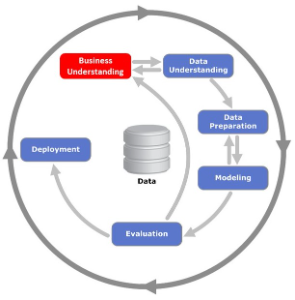

### **Introdução da etapa**

"***Tudo começa no negócio!***"


Entender as necessidades do negócio é fundamental para o alinhamento do produto gerado com às expectativas do cliente. Também possibilita uma boa definição do escopo do projeto e traz, como consequência, a economia de recursos como tempo e dinheiro.

Foi criada uma situação hipotética com o intuito de dar mais veracidade ao projeto. Serão mostradas informações como o contexto atual da empresa, o problema de negócio ao qual ela busca uma solução, os resultados esperados, as limitações de público, entre outros.

<br>

### **A empresa**

O **Banco JSC**, uma instituição financeira privada brasileira que trabalha com linhas de crédito para pessoas físicas e possui como principais produtos o Crédito Pessoal, o Crédito Imobiliário e o Crédito Automotivo.

Atualmente a empresa enfrenta desafios significativos, pois ainda não implementou soluções tecnológicas para a avaliação da concessão de crédito. A ausência de uma abordagem analítica robusta na concessão de empréstimos resulta em decisões baseadas em critérios subjetivos e modelos julgamentais, contribuindo para um **aumento significativo na inadimplência**. Além disso, **a carteira de clientes está em constante expansão**, intensificando a necessidade de uma abordagem mais eficiente.

Com sua matriz localizada na cidade de Juiz de Fora - MG, e classificado como banco de médio porte, a instituição mantém uma atuação regional consistente e também atende os estados do Rio de Janeiro e do Espírito Santo.

Em um horizonte de 4 anos, o Banco JSC planeja realizar uma Oferta Pública Inicial (IPO) na bolsa brasileira. Nesse contexto, torna-se crucial **organizar e otimizar sua carteira de clientes**, garantindo uma base sólida e confiável para atrair investidores e fortalecer sua posição no mercado financeiro. A implementação de soluções tecnológicas para avaliação de crédito é vital nesse processo, visando a **redução da inadimplência e o aprimoramento da eficiência operacional**.

Estima-se que o valor de mercado do Banco JSC seja de aproximadamente R$ 2 bilhões, refletindo seu posicionamento sólido no mercado financeiro regional. Essa avaliação destaca a confiança dos investidores no potencial da instituição e evidencia a importância de um IPO bem-sucedido para alavancar ainda mais o crescimento do banco nos próximos anos.

 <br>

### **O problema de negócio**

O Banco JSC enfrenta uma lacuna crítica na gestão de risco de crédito, afetando negativamente sua saúde financeira e a confiança dos investidores. A ausência de ferramentas tecnológicas adequadas resulta em processos morosos e falhas na identificação de padrões de inadimplência. Isso cria uma urgência para a implementação de um ferramental que permita uma **análise mais precisa e ágil dos riscos envolvidos na concessão de crédito**.

Além disso, o aumento constante na base de clientes intensifica a pressão sobre os processos de concessão de crédito, destacando a necessidade de uma abordagem escalável.

<br>


### **Solução esperada**

O Banco JSC espera receber como produto um modelo de Application Scoring. Este modelo é um modelo que classifica se um cliente será bom ou mau pagador para aquele crédito solicitado. É um modelo utilizado para a análise de crédito de novos credores, ou seja, **indivíduos que ainda não são clientes do banco**. De posse dessa informação, é crucial que o produto desenvolvido possua foco especial na **transparência e explicabilidade**.

A explicabilidade desempenha um papel vital na aceitação e confiança dos analistas, permitindo que eles entendam como as decisões são tomadas e como os modelos de risco operam. Isso não apenas facilita a aceitação da nova tecnologia, mas também promove um ambiente em que os analistas se sintam capacitados para ajustar e otimizar continuamente o sistema. Além disso, em um setor altamente regulamentado, **a explicabilidade é fundamental para garantir que a instituição esteja em conformidade com normas e regulamentos vigentes**, contribuindo no processo de IPO.

Como se trata de uma primeira oportunidade de implementação de um ferramental de concessão, **não é necessário que o modelo discrimine os tipos de produto presentes na carteira** (Créditos Pessoal, Imobiliário e Automotivo).

O intuito, a curto prazo, é o controle da inadimplência da carteira através de uma solução que seja, como já mencionado, **explicável** e **transparente**, **escalável** e, não menos importante, que seja de **baixo custo** de desenvolvimento e implantação.

Outro ponto que deve ser levado em conta no desenvolvimento do modelo que a carteira deverá ser segmentada em **10 faixas de scores** (pontuações), permitindo que a equipe de analistas possa definir corretamente as políticas de concessão de crédito para cada faixa (ou grupo de risco).

<br>

### **Público-Alvo**

O Banco entende que, nesta primeira tentativa de implementação de um ferramental, não há necessidade de limitar o público alvo. Com isso, é possível utilizar todos os dados disponíveis, sem necessidade de realizar filtagens de público ou produtos, reduzindo a complexidade de elaboração da solução.

<br>

### **Principais Métricas de Avaliação**

Antes de avaliar as métricas é necessário analisar se o modelo possui **ordenação das faixas de score** adequada.

Ao segmentar os clientes em 10 faixas é possível calcular a inadimplência média em cada uma delas. Se o modelo ordena as faixas de forma lógica, isto é, **se na medida que o cliente se torna "melhor pagador" a taxa de inadimplência cai**, presume-se que o modelo consegue ordenar adequadamente as faixas se score. A seguir um exemplo:

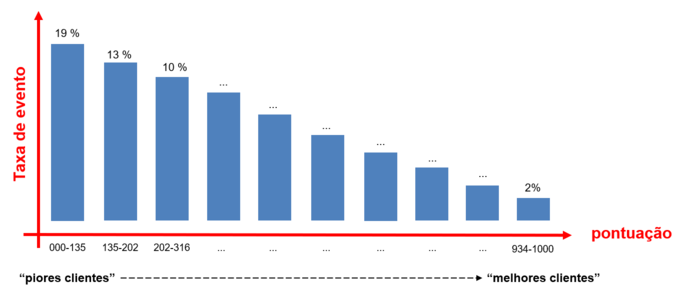


<br>

Constatado que o modelo possui resultados coerentes em relação a ordenação das faixas, avaliaremos as seguintes metricas:


* **Gini**: mede a capacidade discriminativa do modelo de crédito, fornecendo uma visão da eficácia na separação entre bons e maus pagadores.

* **KS (Kolmogorov-Smirnov)**: avalia a discrepância acumulativa entre a distribuição acumulada observada e prevista, indicando a robustez do modelo.

* **ROC-AUC (Área sob a Curva ROC)**: mede a capacidade de discriminação do modelo entre classes de risco, sendo uma métrica amplamente utilizada na avaliação de modelos de crédito.

#**Data Understanding**

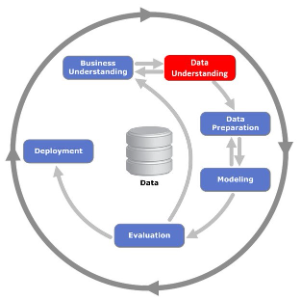

### **Introdução da etapa**

Nesta etapa serão abordadas as limitações aplicadas nas bases de dados disponibilizadas e o motivo de tal limitação. Também serão mostradas informações sobre a qualidade dos dados.

À partir de uma Análise Exploratória dos Dados será mostrado o panorama geral da carteira de clientes, trazendo as principais métricas que podem impactar o negócio.

<br>

#### **Tabelas existentes**

Existem oito tabelas disponibilizadas na plataforma do Kaggle para a solução da competição original:

* **application_train** e **application_test**: são as tabelas principais, onde a primeira possui a variável alvo disponibilizada e a segunda não a possui, sendo esta a base a ser submetida a avaliação após as predições serem realizadas. Estas tabelas possuem dados estáticos para todas as aplicações e cada linha representa um empréstimo.

* **bureau**: traz informações de todos os créditos anteriores de clientes concedidos por outras instituições financeiras que foram reportados ao Credit Bureau (para clientes que possuem empréstimo na amostra). Para cada empréstimo na amostra, há tantas linhas quanto o número de créditos que o cliente tinha no Credit Bureau antes da data da solicitação.

* **bureau_balance**: traz informações de saldos mensais de créditos anteriores no Credit Bureau. Esta tabela possui uma linha para cada mês de histórico de cada crédito anterior reportado ao Credit Bureau.

* **POS_CASH_balance**: Instantâneos mensais do saldo anterior de transações em pontos de venda (POS) e empréstimos em dinheiro que o solicitante teve com o banco. Esta tabela possui uma linha para cada mês de histórico de cada crédito anterior (crédito ao consumidor e empréstimos em dinheiro) relacionado aos empréstimos na amostra.

* **credit_card_balance**: Instantâneos mensais do saldo anterior de cartões de crédito que o solicitante possui com o banco. Esta tabela possui uma linha para cada mês de histórico de cada cartão de crédito anterior (crédito ao consumidor e empréstimos em dinheiro) relacionado aos empréstimos da amostra.

* **previous_application**: Traz todas as aplicações anteriores para empréstimos dos clientes que possuem registro no banco. Existe uma linha para cada aplicação anterior relacionada aos empréstimos na amostra de dados.

* **installments_payments**: é o histórico de pagamentos para os créditos previamente concedidos relacionados aos empréstimos da amostra. Há uma linha para cada pagamento realizado, além de uma linha para cada pagamento perdido. Uma linha é equivalente a um pagamento de uma parcela OU a uma parcela correspondente a um pagamento de um crédito anterior relacionado aos empréstimos em nossa amostra

<br>

#### **Limitação dos dados**

Atendendo às exigências do Banco JSC, **não utilizaremos as tabelas "bureau" e "bureau_balance"**, com o intuito de eliminar custos na aquisição de dados externos. Futuramente, caso o modelo não possua boa performance na pontuação de novos clientes, podemos avaliar, em conjunto com o time de negócios, o custo de aquisição de dados externos e o ganho de performance que esses dados trarão para o modelo.

Além disso, conforme mencionado no artigo anterior (entendimento do negócio), o objetivo principal é criar um modelo de **application**, isto é, um modelo que avalie o risco de crédito para clientes que **ainda não possuem histórico interno no banco**. Assim, devido á natureza do problema, não serão utilizados dados transacionais ou históricos nesse modelo específico, de forma que **as tabelas "POS_CASH_balance", "credit_card_balance", "previous_application" e "installments_payments" também não serão utilizadas**.

Ao evitar a incorporação de dados transacionais, simplificamos o modelo, tornando-o mais eficiente e direcionado para a análise do comportamento no momento da aplicação. Essa abordagem mais focada permite uma implementação mais rápida e menos complexa, adequada para a avaliação inicial de risco de crédito para novos solicitantes, sem a necessidade de informações históricas que não estão disponíveis para esse segmento específico de clientes.

Não utilizar dados transacionais também auxilia para que não ocorram possíveis "incoerências temporais" quando estes dados, que possuem informações de datas, são postos em conjunto com os dados de Safra criados artificialmente.

Em resumo, o problema será desenvolvido à partir de uma única base de dados: **"application_train"**

<br>

#### **Tabela "application_train**

Nesse cenário, as informações contidas na tabela "application_train" tornam-se fundamentais, pois refletem os dados fornecidos pelo cliente durante o processo de inscrição. O foco está na análise das características pessoais, financeiras e detalhes da aplicação para identificar padrões e indicadores que possam influenciar a probabilidade de inadimplência ou comportamento de pagamento do novo cliente. Este modelo visa prever a capacidade do cliente em honrar seus compromissos com base nas informações disponíveis no momento da aplicação.

<br>

#### **Tabela "application_test**

Por fim, a tabela application_test será utilizada para simular um cenário com dados inéditos, ou em produção, de forma que os scores de risco de crédito (ou pontuações) serão atribuídos a cada concessão solicitada nesta tabela.

<br>

#### **Dicionário de dados**

Além das bases, o dicionário de dados contendo o significado de cada variável também foi disponibilizado. Contudo, por existirem muitas variáveis, somente para as variáveis de interesse é que faremos a transcrição de seu significado. Mas caso haja neecessidade, o dicionário na íntegra ainda pode ser consultado na plataforma Kaggle ou no repositório do projeto no GitHub, com links já disponibilizados anteriormente.

<br>

#### **Variáveis de interesse inicial**

Sabendo de antemão, à partir de ma análise preliminar do dicionário de dados, que o conjunto possui 123 features, é necessário selecionar uma lista reduzida de variáveis de interesse para que a Análise Exploratória inicial seja realizada. Uma alternativa interessante seria realizar primeiro a etapa de preparação dos dados e elaborar a Análise Exploratória somente das features remanescentes do processo de Feature Selection. Dessa forma, a quantidade de informações se torna (humanamente) viável de ser gerada e analisada.

No nosso caso, como queremos obter um panorama geral da carteira de clientes antes mesmo de iniciar a modelagem, selecionaremos um conjunto reduzido de  variáveis, com base em conversas com a equipe de negócio, para fazermos uma analise mais aprofundada. As variáveis seleciondas e sua descrição, segundo o dicionário de dados disponibilizados, são:

<br>

* **SK_ID_CURR**: ID do cliente. Número único que o identifica na base de dados.

* **DATA_REF**: safra, período ao qual foi concedido o empréstimo. Não consta no dicionário de dados

* **TARGET**: variável alvo (1=inadimplente)

* **CNT_CHILDREN**: quantidade de filhos

* **AMT_CREDIT**: valor do crédito concedido

* **AMT_INCOME_TOTAL**: renda anual

* **DAYS_BIRTH**: idade em dias

* **DAYS_EMPLOYED**: quantidade de dias empregado

* **NAME_INCOME_TYPE**: origem da renda

* **OCCUPATON_TYPE**: ocupação

* **NAME_CONTRACT_TYPE**: tipo de de empréstimo

* **CODE_GENDER**: gênero

* **FLAG_OWN_CAR**: se possui carro próprio ou não (1=sim)

* **FLAG_OWN_REALTY**: se possui imóvel próprio ou não (1=sim)

* **NAME_EDUCATION_TYPE**: escolaridade

* **NAME_FAMILY_STATUS**: estado civil



### **Obtenção e leitura dos dados**

In [ ]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importando
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/01. Projetos de Ciência e Análise de Dados/Modelagem de risco de Crédito/Home Credit Default/application_train_safra.csv')

# Criando cópia para tabela analítica de dados
abt_00 = data.copy()

### **Metadados**

In [ ]:
# Limitando a lista de variáveis exibidas no quadro de metadados
# (calcula para todas, mas só mostra as da lista)
lista = ['SK_ID_CURR','DATA_REF','TARGET','CNT_CHILDREN','AMT_CREDIT',
         'AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','NAME_INCOME_TYPE',
         'OCCUPATION_TYPE','NAME_CONTRACT_TYPE',
         'CODE_GENDER', 'FLAG_OWN_CAR','FLAG_OWN_REALTY',
         'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS']

# Metadados - de todas as features
metadados_00 = report_data(abt_00)

# Visualizando
metadados_00[metadados_00['Feature'].isin(lista)]


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 67
Quantidade de features numéricas: 107             |    Quantidade de features categóricas 16
Cardinalidade total das categóricas: 140          |    Dataframe: 307511 linhas, 123 colunas



Feature     Tipo    Card  %Miss  %Out_sup  %Out_inf  \
0             SK_ID_CURR    int64  307511    0.0       0.0       0.0   
1                 TARGET    int64       2    0.0       8.1       0.0   
2     NAME_CONTRACT_TYPE   object       2    0.0       0.0       0.0   
3            CODE_GENDER   object       3    0.0       0.0       0.0   
4           FLAG_OWN_CAR   object       2    0.0       0.0       0.0   
5        FLAG_OWN_REALTY   object       2    0.0       0.0       0.0   
6           CNT_CHILDREN    int64      15    0.0       1.4       0.0   
7       AMT_INCOME_TOTAL  float64    2548    0.0       4.6       0.0   
8             AMT_CREDIT  float64    5603    0.0       2.1       0.0   
12      NAME_INCOME_TYPE   object       8    0.0       0.0       0.0   
13   NAME_EDUCATION_TYPE   object       5    0.0       0.0       0.0   
14    NAME_FAMILY_STATUS   object       6    0.0       0.0       0.0   
17            DAYS_BIRTH    int64   17460    0.0       0.0       0.0   
18         DAYS_EMPLOYED    int64   12574    0.0      18.0       5.5   
28       OCCUPATION_TYPE   object      18   31.3       0.0       0.0   
122             DATA_REF    int64      13    0.0       0.0       8.3   

     %Outliers                           Moda  %Freq  
0          0.0                       100002.0    0.0  
1          8.1                            0.0   91.9  
2          0.0                     Cash loans   90.5  
3          0.0                              F   65.8  
4          0.0                              N   66.0  
5          0.0                              Y   69.4  
6          1.4                            0.0   70.0  
7          4.6                       135000.0   11.6  
8          2.1                       450000.0    3.2  
12         0.0                        Working   51.6  
13         0.0  Secondary / secondary special   71.0  
14         0.0                        Married   63.9  
17         0.0                       -13749.0    0.0  
18        23.5                       365243.0   18.0  
28         0.0                       Laborers   17.9  
122        8.3                       202205.0    8.4

<br>

Observando o quadro de metadados podemos extrair algumas informações preliminares importantes sobre a qualidade dos dados:


* O conjunto conta com 307511 linhas e 123 colunas (features + ID + Safra + Target)

* O conjunto conta com 107 features numericas (incluindo ID, Safra e Target) e 16 features categóricas.

* A cardinalidade total das features categóricas é de 140. Isto é, existem 140 domínios diferentes somando-se todas estas features. Esta informação é importante momento de preparar a base criando variáveis dummys pois, caso todas estas features sejam convertidas, serão criadas 140 - 16 = 124 novas colunas dummyficadas, o que pode comprometer alguns modelos a depender do volume de linhas existente.

* No total, existem 66 features que possuem valores ausentes. Em etapa posterior, features com quantidade de nulos acima de determinado valor serão excluídas da modelagem.

<br>

### **Taxa de evento e volumetria em cada safra**

A análise da média de taxa de evento e da volumetria em cada safra é importante em muitos cenários, especialmente quando se lida com dados temporais ou por safra.

Ao analisar a média de taxa de evento ao longo das safras, é possível identificar **padrões temporais e tendências**. Isso ajuda a entender se há variações significativas nas taxas de evento ao longo do tempo.

Variações abruptas ou anômalas nas taxas de evento entre safras podem indicar problemas ou eventos especiais em determinados períodos. Essas anomalias podem ser investigadas para entender se há fatores externos que influenciam as taxas de inadimplência.

No desenvolvimento de modelos de crédito ou análise de risco, **é crucial que o modelo seja estável ao longo do tempo**. Se as características ou padrões de comportamento dos clientes mudarem drasticamente entre safras, isso pode afetar a eficácia do modelo.

A volumetria, ou o volume total de dados em cada safra, é importante para garantir que você tenha dados suficientes para análises estatísticas robustas. Variações significativas na volumetria podem impactar a confiabilidade das análises.

In [ ]:
# Verificando a taxa de evento e volumetria das safras
abt_00.groupby('DATA_REF').agg({'TARGET': 'mean' , 'DATA_REF':'count'}).rename(columns={'TARGET':'MED_TX_TEVENTO' , 'DATA_REF':'VOLUME'}).reset_index()

DATA_REF  MED_TX_TEVENTO  VOLUME
0     202112        0.067910   25622
1     202201        0.084157   22553
2     202202        0.079494   22618
3     202203        0.078147   22880
4     202204        0.080641   24330
5     202205        0.078107   25798
6     202206        0.077735   23130
7     202207        0.081684   22844
8     202208        0.086764   23316
9     202209        0.087703   23226
10    202210        0.084168   23976
11    202211        0.080138   24021
12    202212        0.084364   23197

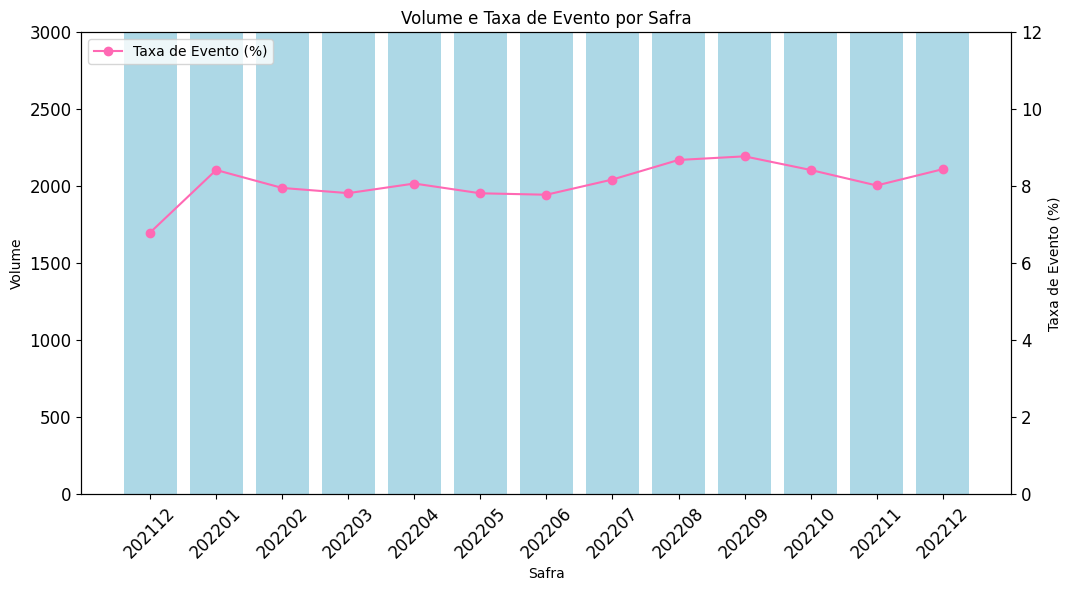

In [ ]:
# Plotando a taxa de evento e volumetria das safras em todo o conjunto
abt_00_tx_evento = plot_tx_event_volume_safra(abt_00, target='TARGET' , safra='DATA_REF', ymax_taxa_evento=12, ymax_volume=3000 , rot_label = 45)

Analisando a curva do gráfico pode-se concluir que existe estabilidade da taxa média de inadimplência (**conhecida como bad rate**) ao longo das safras. Este comportamento ja era esperado pois as safras foram criadas artificialmente de forma que houvesse estabilidade.

<br>

### **Análise exploratória preliminar**

Ainda com base no quadro de metadadados, podemos observar que:

<br>

* **TARGET**:
 * 91.9% das observações de empréstimos são adimplentes (valor 0).
 * Logo, **8.1% das observações são inadimplentes**, mostrando desbalanceamento nas observações.

* **NAME_CONTRACT_TYPE**:
 * 90.5 % da carteira toma empréstimos em dinheiro.

* **CODE_GENDER**:
 * 65.8% dos clientes da amostra são do gênero feminino.

* **FLAG_OWN_CAR**:
 * 66.0% dos clientes não possuem carro.

* **FLAG_OWN_REALTY**:
 * 69.4% dos clientes possuem imóvel próprio

* **CNT_CHILDREN**:
 * 70.0% dos clientes não possui filhos.
 * Há 15 domínios nesta variável, indicando uma faixa de quantidade de filhos extensa.
 * Há alguns outliers, mostrando que 1.4% das observações apresentam quantidade de filhos acima da maioria das observações.

* **AMT_INCOME_TOTAL**:
 * 11.6% dos clientes possui renda de 135000.0
 * Existe uma faixa muito ampla de renda (cardinalidade = 1613)
 * Há alguns outliers, mostrando que 4.6% das observações apresentam renda acima da maioria das observações.
 * Informações mais aprofundadas (como a distribuição da renda) serão obtidas a seguir.

* **AMT_CREDIT**:
 * 3.2% dos clientes tomaram empréstimo de 450000.0
 * Existe uma faixa muito ampla de valores solicitados (cardinalidade = 5603)
 * Há alguns outliers, mostrando que 2.1% das observações tomaram empréstimo acima da maioria das observações.
 * Informações mais aprofundadas (como a distribuição dos empréstimos) serão obtidas a seguir.

* **NAME_INCOME_TYPE**:
 * 51.6% dos clientes são trabalhadores (empregados ou autônomos)

* **NAME_EDUCATION_TYPE**:
 * 71.0% dos clientes possuem o Ensino Secundário (pode-se entender como Ensino médio)

* **NAME_FAMILY_STATUS**:
 * 63.9% dos clientes são casados

* **DAYS_BIRTH**:
 * Para esta variável a frequência indicada é igual a zero, o que causa estranheza.
 * Informações mais aprofundadas (como a distribuição da idade) serão obtidas a seguir.

* **DAYS_EMPLOYED**:
 * Fazendo a conversão para anos, 18.0% dos clientes estão empregados há 1001 anos 365243/365, o que torna o dado incoerente.
 * Informações mais aprofundadas (como a distribuição dos anos de trabalho) serão obtidas a seguir.

* **OCCUPATION_TYPE**:
 * 17.9% dos clientes são trabalhadores manuais ou operários
 * Possui 31.3% de valores faltantes (missing)

<br>

#### **Análise univariada das features numéricas**

In [ ]:
# Definindo dataframe auxiliar
df_num = abt_00[lista].select_dtypes(include=['int64' , 'float64']).drop(['SK_ID_CURR' , 'TARGET'] , axis=1).copy()

# Convertendo a idade para anos e convertendo para número positivo
df_num['DAYS_BIRTH'] = np.floor((-1) * df_num['DAYS_BIRTH'] / 365)
df_num.rename(columns={'DAYS_BIRTH' : 'YEARS_AGE'}, inplace=True)

# Convertendo a quantidade de dias empregado para anos
df_num['DAYS_EMPLOYED'] = np.floor((-1) * df_num['DAYS_EMPLOYED'] / 365)
df_num.rename(columns={'DAYS_EMPLOYED' : 'YEARS_EMPLOYED'}, inplace=True)

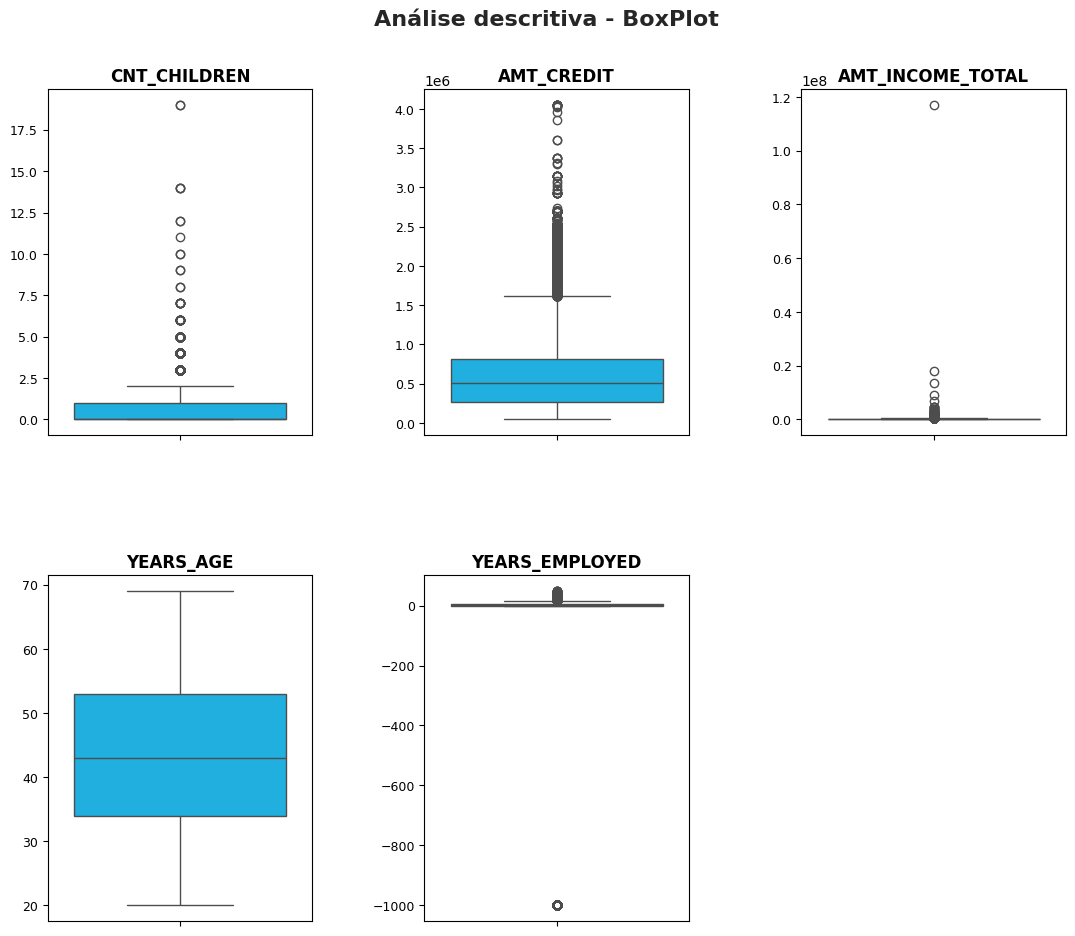

In [ ]:
# Boxplot
plot_batch_boxplot(df_num, cols=3 , b=12)

As variáveis AMT_INCOME_TOTAL e YEARS_EMPLOYED estão tendo suas distribuições comprometidas por outliers que, muito provavelmente, são oriundos de erros de imputação. Estes valores extremo serão investigados e tratados.

* Para a variável AMT_INCOME_TOTAL será criado um limite de valor de interesse
 igual a 1000000. Os valores acima desse limite serão substituídos pela mediana.

* Para a variável YEARS_EMPLOYED há valores negativos que serão substituídos
 pela mediana (pois a moda possivelmente é igual a estes próprios valores). Estes valores negativos podem representar alguma flag utilizada no momento da aplicação para representar que não há informações sobre o cliente.Esses valores serão novamente tratados na etapa de Preparação dos Dados.![formula normalizacao.PNG](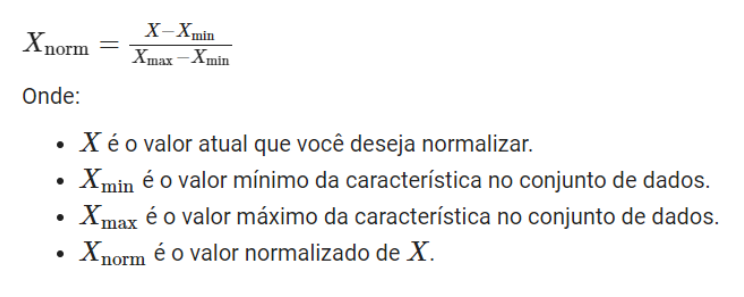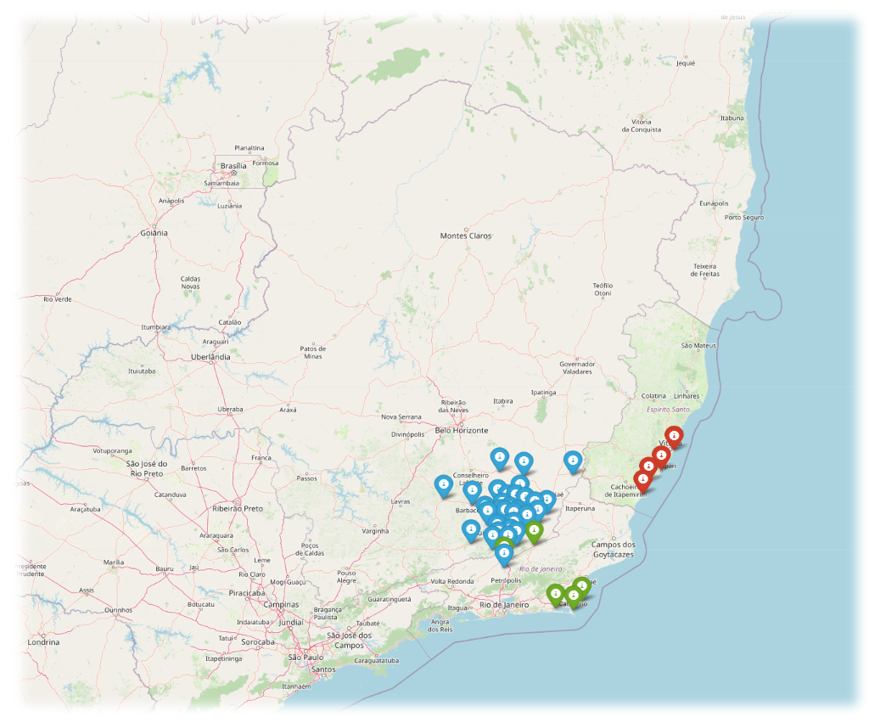)
<br>

In [ ]:
# Substituindo pela mediana


# Mediana para 'AMT_INCOME_TOTAL' para valores menores que 1000000
mediana = df_num.loc[df_num['AMT_INCOME_TOTAL'] < 1000000 , 'AMT_INCOME_TOTAL'].median()

# Substituindo
df_num.loc[df_num['AMT_INCOME_TOTAL']> 1000000 , 'AMT_INCOME_TOTAL'] = mediana


# Mediana para 'YEARS_EMPLOYED' sem os valores negativos:
mediana = df_num.loc[df_num['YEARS_EMPLOYED']>=0 , 'YEARS_EMPLOYED'].median()

# Substituindo
df_num.loc[df_num['YEARS_EMPLOYED']<0 , 'YEARS_EMPLOYED'] = mediana

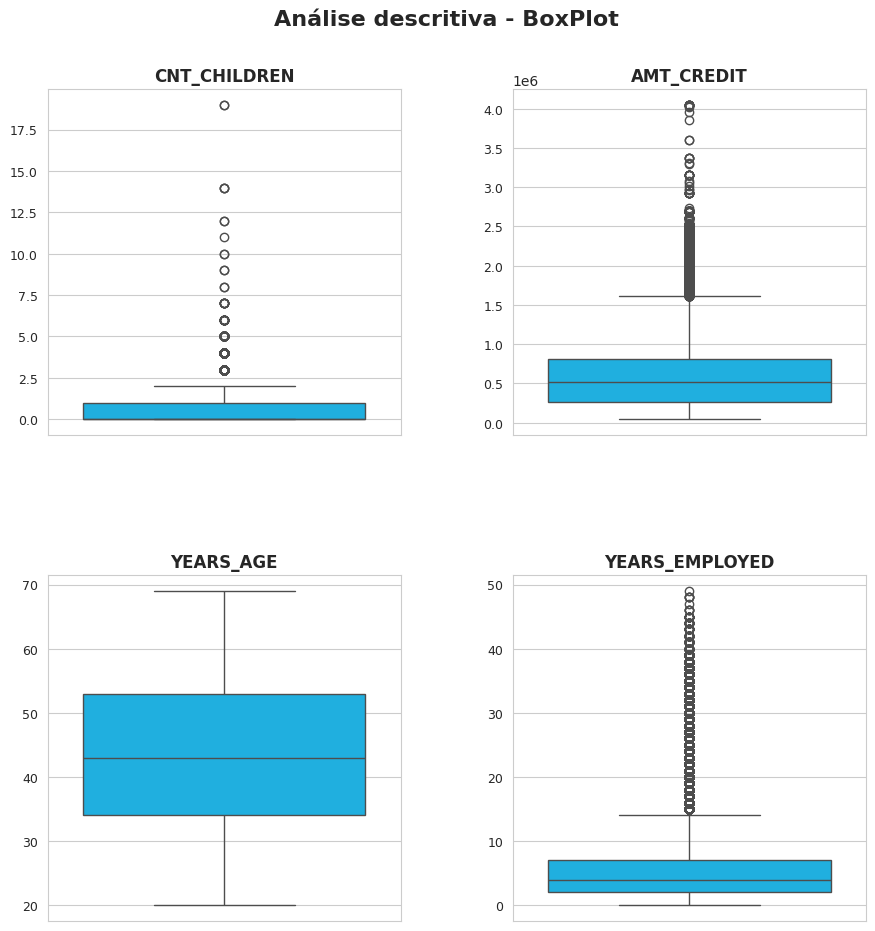

In [ ]:
# Verificando boxplot
plot_batch_boxplot(df_num.drop('AMT_INCOME_TOTAL' , axis=1), cols=2 , b=10)

* **CNT_CHILDREN**: existência de outliers. Distribuição assimétrica à direita, valores se concentram próximos a 1.

* **AMT_CREDIT**: existência de outliers. Distribuição assimétrica à direita, valores se concentram no intervalo aproximado de 300000 a 800000.

* **AMT_INCOME_TOTAL**: existência de outliers.
  Distribuição assimétrica à direita, valores se concentram próximos a 100000.

* **YEARS_AGE**: sem outliers.
 Distribuição muito próxima da normal. Mediana e média em torno de 43 anos.

* **YEARS_EMPLOYED**: existência de outliers.
 Distribuição assimétrica à direita, valores se concentram no intervalo aproximado de 3 a 8 anos.

In [ ]:
# Estatísticas descritivas
df_num.describe()

CNT_CHILDREN    AMT_CREDIT  AMT_INCOME_TOTAL      YEARS_AGE  \
count  307511.000000  3.075110e+05     307511.000000  307511.000000   
mean        0.417052  5.990260e+05     167162.051548      43.435968   
std         0.722121  4.024908e+05      89572.740240      11.954593   
min         0.000000  4.500000e+04      25650.000000      20.000000   
25%         0.000000  2.700000e+05     112500.000000      34.000000   
50%         0.000000  5.135310e+05     144000.000000      43.000000   
75%         1.000000  8.086500e+05     202500.000000      53.000000   
max        19.000000  4.050000e+06     990000.000000      69.000000   

       YEARS_EMPLOYED  
count    307511.00000  
mean          5.67020  
std           5.86224  
min           0.00000  
25%           2.00000  
50%           4.00000  
75%           7.00000  
max          49.00000

* **CNT_CHILDREN**: 75% dos clientes possuem até 1 filho

* **AMT_CREDIT**: a média de crédito solicitado pelos clientes é de 599026.0

* **AMT_INCOME_TOTAL**: a média de renda anual dos clientes é de 168798.0

* **YEARS_AGE**: a média de idade dos clientes é de 43.4 anos. 75% possuem 53 anos ou menos.

* **YEARS_EMPLOYED**: a média de tempo empregado dos clientes é de 5.7 anos. 75% possuem 7 anos ou menos.

<br>

#### **Análise bivariada das features numéricas**

A seguir, será investigada a relação entre duas variáveis numéricas com o objetivo de encontrar relações lineares entre elas.

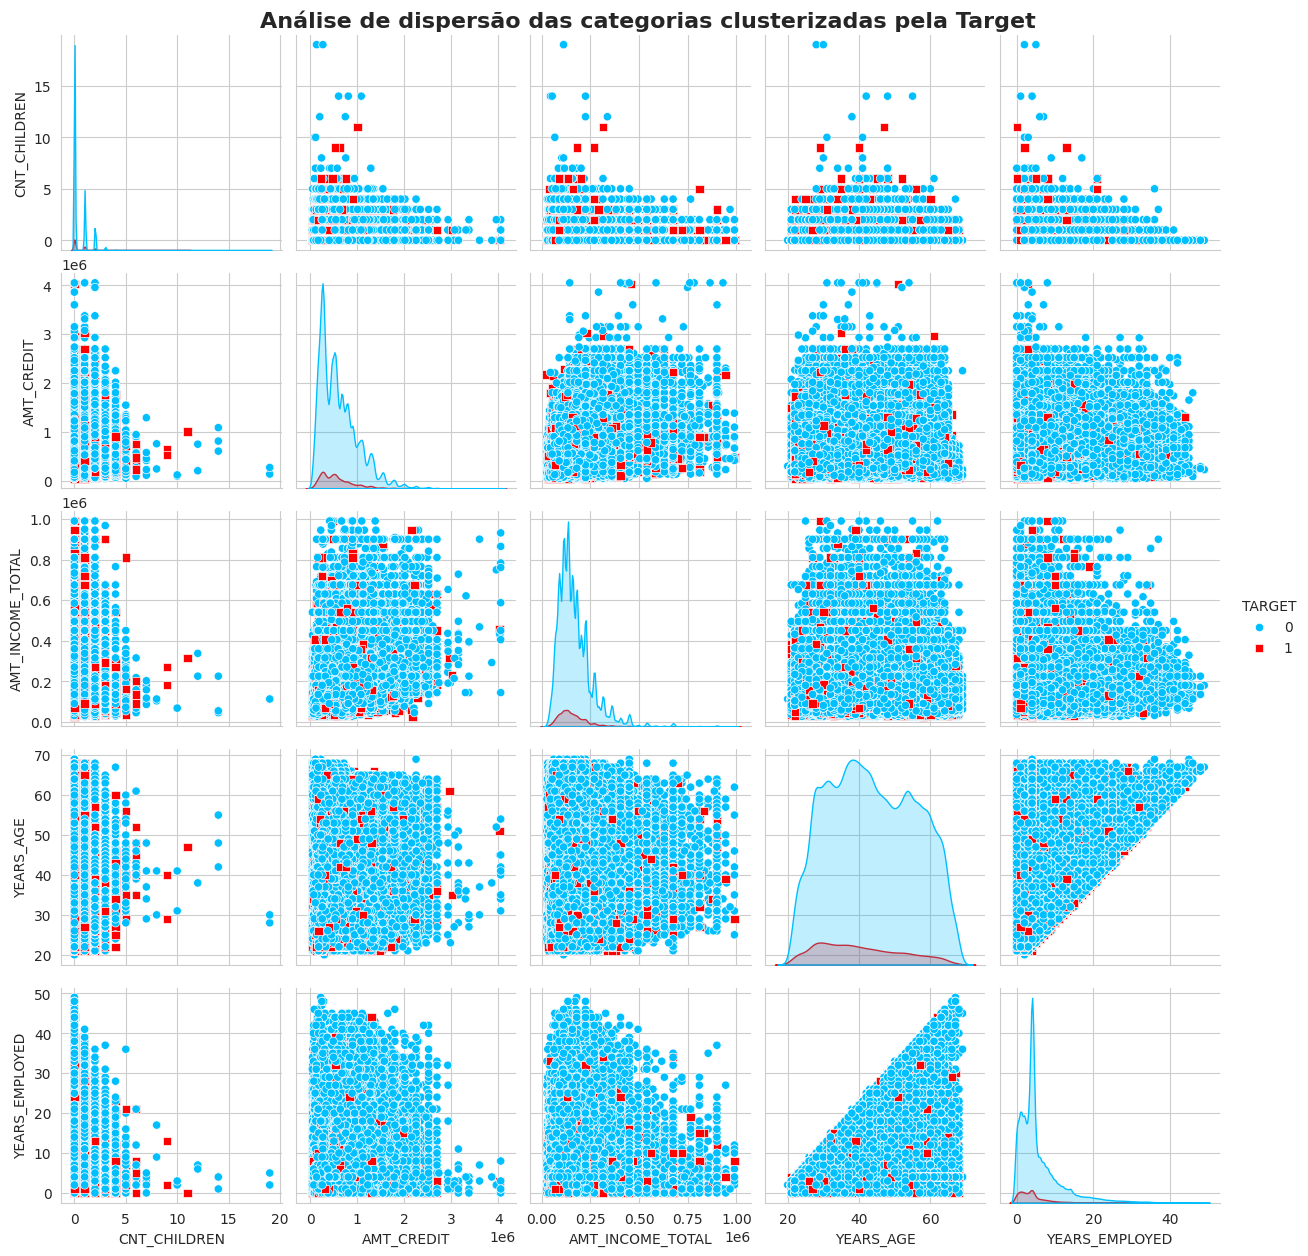

In [ ]:
# ScatterPlot - Clusterizado pela Target

# Criando dataframe auxiliar para manipular coluna 'AMT_INCOME_TOTAL',
# com intuito de mantermos o dataframe df_num inalterado
df_aux = df_num.copy()

# Retornando com a Target
df_aux['TARGET'] = abt_00['TARGET']

# Limitando os valores de 'AMT_INCOME_TOTAL'
mediana = df_aux.loc[df_aux['AMT_INCOME_TOTAL'] < 1e8, 'AMT_INCOME_TOTAL'].median()
df_aux.loc[df_aux['AMT_INCOME_TOTAL'] > 1e8, 'AMT_INCOME_TOTAL'] = mediana


# Visualizando
plot_pairplot(df_aux , hue= 'TARGET' , title = 'Análise de dispersão das categorias clusterizadas pela Target')

A única relação linear visualmente perceptível é entre as variáveis 'YEARS_EMPLOYED' e 'YEARS_AGE', onde aumentando a idade, o limite para os anos trabalhados também aumenta.

<br>

Não foi possível identificar correlação linear visível entre as demais variáveis numéricas.

<br>

#### **Análise univariada das features categóricas**

In [ ]:
# Definindo dataframe auxiliar
df_cat = abt_00[lista].select_dtypes(include=['object']).copy().drop('DATA_REF', axis=1)

In [ ]:
# Análise das categorias clusterizadas pela Target

# Dataframe auxiliar
df_aux=df_cat.copy()

#Limite de cardinalidade
lim_card = 6

# Lista de variáveis de baixa cardinalidade
baixa_card = [col for col in df_aux.columns if df_aux[col].nunique() <= lim_card]

# Dataframe de baixa cardinalidade
df_baixa_card = df_aux[baixa_card]
df_baixa_card['TARGET'] = abt_00['TARGET']

# Dataframe de alta cardinalidade
df_alta_card = df_aux.drop(baixa_card, axis=1)
df_alta_card['TARGET'] = abt_00['TARGET']

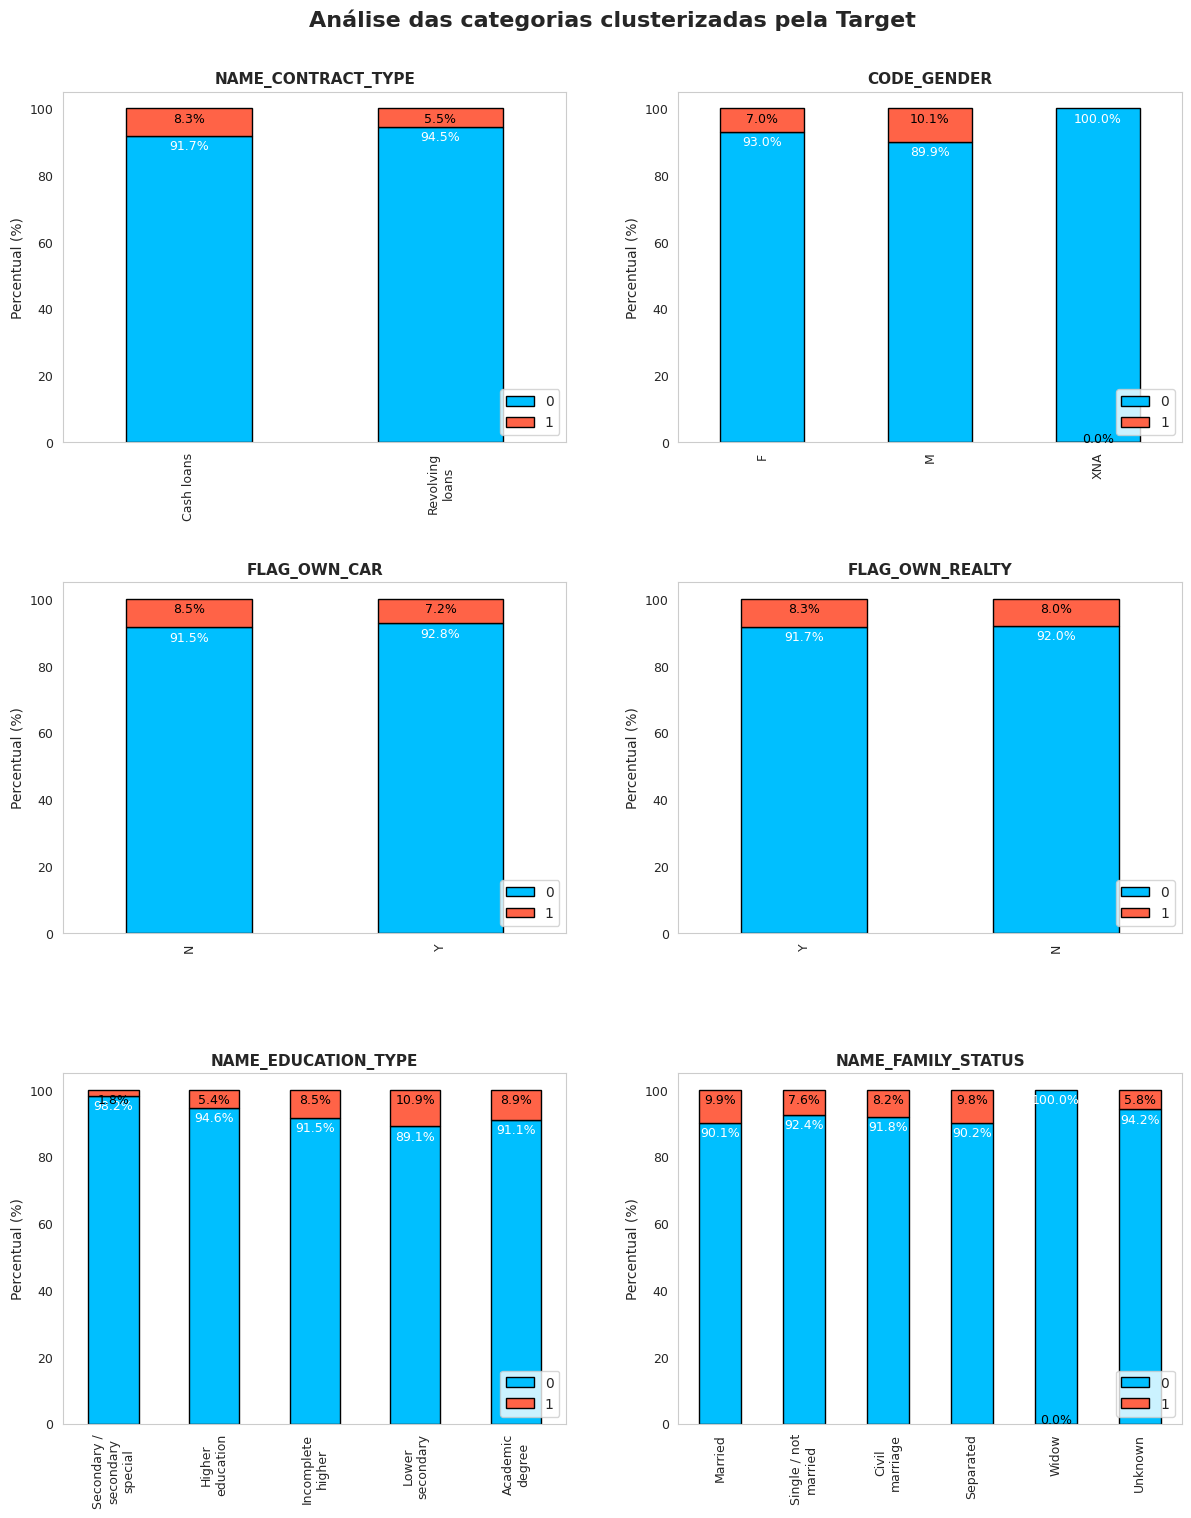

In [ ]:
# Exibindo o gráfico -features de baixa cardinalidade
plot_batch_bar_cluster(df_baixa_card , card_max=6 , hue='TARGET', cols=2  , grid=False, title = 'Análise das categorias clusterizadas pela Target' , b=13)

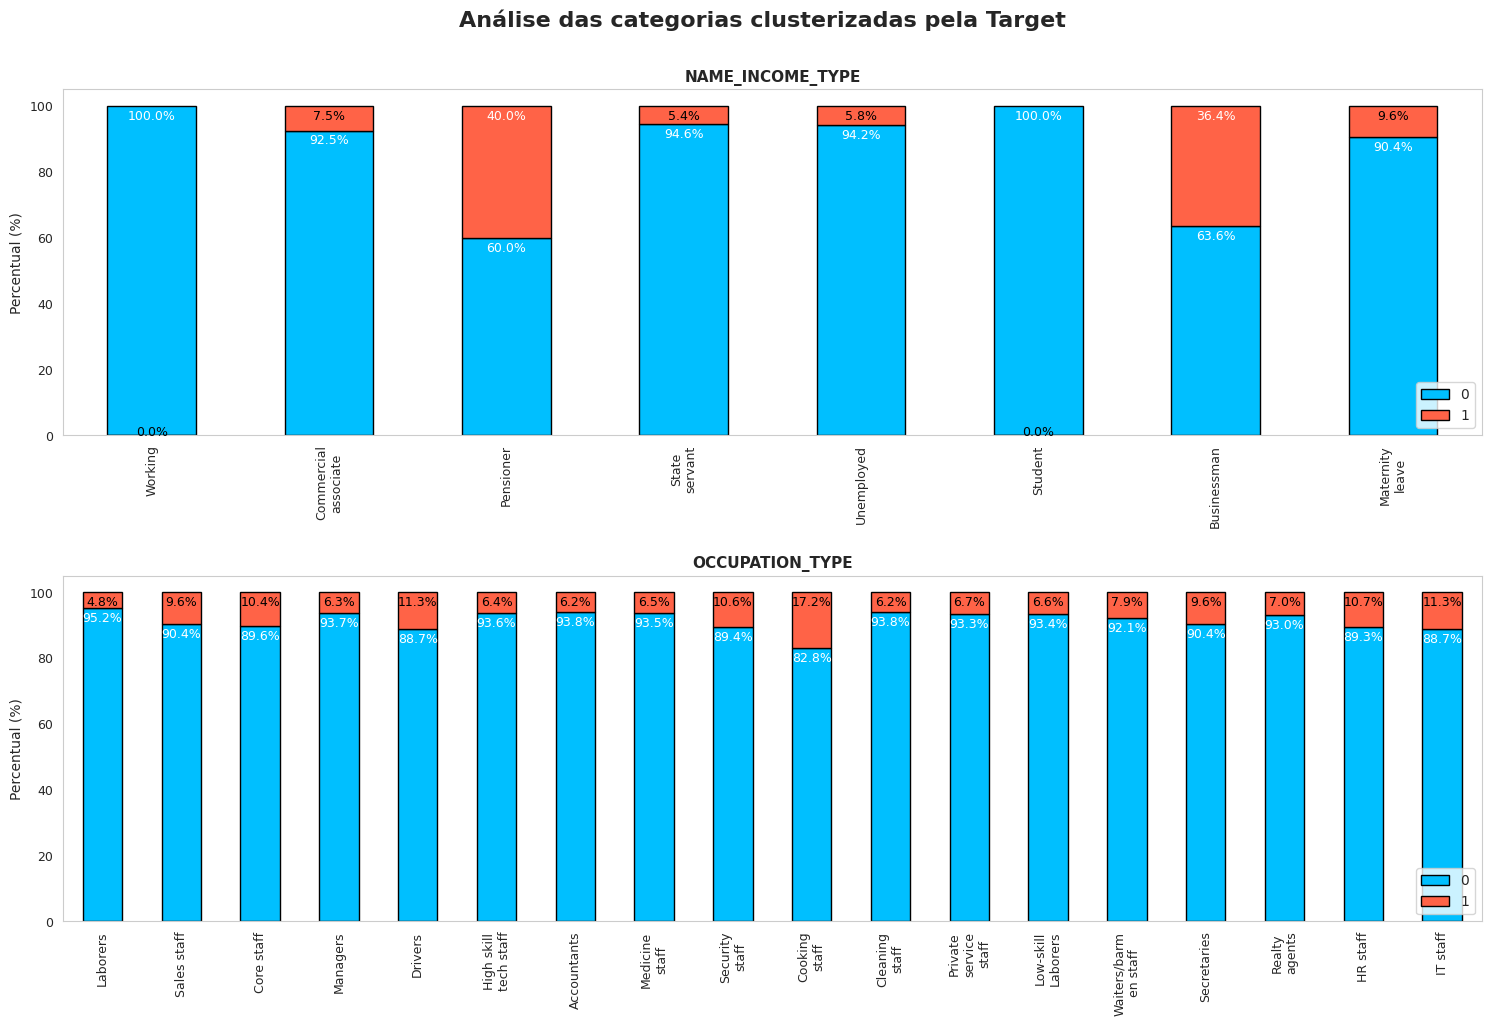

In [ ]:
# Exibindo o gráfico -features de baixa cardinalidade
plot_batch_bar_cluster(df_alta_card , card_max = 50, hue='TARGET', cols=1  , grid=False, title = 'Análise das categorias clusterizadas pela Target' , b=16)

* **NAME_CONTRACT_TYPE**: Taxa de inadimplência ligeiramente maior para empréstimo em dinheiro (8.3%) em relação ao crédito rotativo (5.5%).

* **CODE_GENDER**: Taxa de inadimplência ligeiramente maior entre as mulheres (10.1%) do que entre os homens (7.0%).

* **FLAG_OWN_CAR**: taxa de inadimplência 1.3% superior entre os que não possuem carro (8.5%) do que entre os que possuem (7.2%).

* **FLAG_OWN_REALTY**: taxa de inadimplência praticamente igual entre os que possuem imóvel próprio e os que não possuem.

* **NAME_INCOME_TYPE**: "Commercial associate" e "Businessman" apresentam alta taxa de inadimplência, chegando a 40.0% e 36.4%, respectivamente.

* **OCUPATION_TYPE**: "Cooking Staf" é a ocupação de maior inadimplência, atingindo o percentual de 17.2%.

* **NAME_FAMILY_STATUS**: Não hádiferença significativa entre casados, solteiros e divorciados. Contudo, a taxa de inadimplência é zero entre os viúvos.

* **NAME_EDUCATION_TYPE**: pessoas com baixo nível de escolaridade possuem as maiores taxas de inadimplência (10.9%).

<br><br>

Com isso, encerramos a etapa **Data Understanding**

<br>


#**Data Preparation**


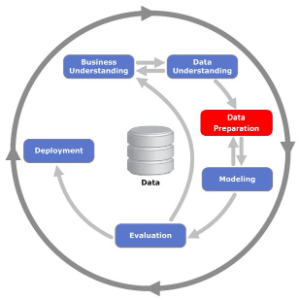

### **Introdução da etapa**

Conforme visto na etapa anterior (entendimento dos dados), algumas variáveis possuem valores nulos, outras são categóricas ("textuais") e, possívelmente, muitas outras variáveis são totalmente irrelevantes tanto para o poder preditivo do modelo quanto ponto de vista do negócio.

Isto traz a necessidade de ajustarmos a base disponível para que os dados possam ser utilizados e entendidos pelos algoritmos que usaremos na próxima etapa (modelagem).

Na preparação dos dados também é realizada, antes de quaisquer manipulações, a divisão dos dados em conjunto de treino e conjunto de teste. Isso nos garante que uma parcela dos dados será intocada até que o modelo esteja pronto para ser testado.

Por fim, é válido mencionar que uma parcela das features pode ser removida, utilizando alguns métodos específicos, para que o conjunto final possua apenas features de relevância e a complexidade do processamento seja reduzida.

<br>

#### **Aspectos éticos e legais**

Um modelo de risco de crédito é, por natureza, uma ferramenta discriminadora. No entanto, o uso de determinadas variáveis não é considerado aceitável, seja por questões legais ou éticas.

Certas variáveis, como gênero, estado civil e, em alguns casos, idade, são por vezes consideradas inadequadas para tomada de decisões, pois podem levar a discriminações injustiçadas. Por exemplo, a utilização dessas variáveis pode resultar em desvantagens para mulheres, pessoas solteiras ou mais velhas, o que viola princípios legais e éticos de igualdade e justiça.

Contudo, não sendo escopo deste projeto as discussões cabíveis sobre o tema, **será excluída apenas a variável gênero** da nossa base de dados.

<br>

#### **Dados de treino e dados de teste**

Temos intuito de separar os dados em dois conjuntos é evitar a ocorrência do chamado **data leakage**, que ocorre quando informações do conjunto de teste são acidentalmente incluídas (ou "vazadas") no conjunto de treinamento durante o processo de modelagem. Isso pode acontecer, por exemplo, se informações específicas do conjunto de teste forem usados para treinar o modelo. Como resultado, o modelo pode aprender padrões artificiais que não são generalizáveis para novos dados, levando a previsões imprecisas e uma avaliação otimista do desempenho do modelo. Resumindo, por exemplo, se um valor de média foi calculado no conjunto de treino para preenchimento de valores nulos, esse mesmo valor de média será utilizado para preencher os valores nulos no conjunto de teste (não sendo necessário calcular uma nova média com base nestes dados).

A estratégia de separar uma parcela dos dados é chamada de **holdout**. As duas formas de aplicação do holdout mais comuns são:
* **Out of Sample**: a divisão dos dados é feita de forma randômica, selecionando um percentual dos dados para treino e para teste. Esses dados representam observações "fora da amostra" e são usados para avaliar como o modelo se comporta em dados completamente novos e não vistos durante o treinamento. Geralmente é separado um percentual de 20 a 30% para dados de teste, sendo o restante destinado aos dados de treino.

* **Out of Time**: a divisão dos dados é feita através de um corte temporal. De posse das safras, seleciona-se aquelas que servirão de safras de treino e as safras de teste. Este tipo de separação ajuda a avaliar se o modelo é robusto o suficiente para lidar com mudanças sazonais, tendências ou outras variações temporais nos dados.

<br>

Uma vez que os dados deste projeto possuem as informações de safras, a **abordagem adotada será a Out of Time**, selecionando as 3 safras mais atuais como dados de teste pois estas safras **representam o comportamento atualizado do público** perante o mercado.

A divisão dos dados neste projeto fica:
* As 10 safras mais antigas, de DEZ/2021 até AGO/2022 para **treino**
* As 3 safras mais recentes, de SET/2022 até DEZ/2022 para **teste**

<br>

#### **Tratamento de valores nulos**

A ocorrência de valores ausentes (ou nulos) na base pode existir por diversos fatores, como:

* Um campo de endereço não preenchido em um formulário online devido à distração do usuário.
* Falha na leitura de um sensor de temperatura, resultando em valores ausentes em um conjunto de dados climáticos.
* Não resposta à pergunta sobre renda em uma pesquisa demográfica por motivos de privacidade ou esquecimento.
* Ausência de registros de vendas de um produto em determinado período de tempo devido a problemas no sistema de monitoramento.

A ocorrência de valores ausentes pode introduzir viés nos resultados e muitos algoritmos não são capazes de lidar diretamente com esses valores. Assim, podemos substituir os valores nulos por outros valores, como a média, mediana ou moda da distribuição daquela variável. Contudo, há variáveis que possuem um percentual alto de nulos. Estas variáveis podem ser removidas, caso a distribuição de nulos seja aleatória.

<br>

#### **Codificação de variáveis categóricas**

Os algoritmos de machine learning geralmente operam com dados numéricos, e não lidam bem com dados categóricos diretamente, sendo necessário aplicar técnicas de conversão destas variáveis na etapa de preparação dos dados.

O OneHotEncoder converte variáveis categóricas em vetores binários, o que é crucial para garantir que o modelo possa interpretar corretamente as diferentes categorias. Por exemplo, ao lidar com a variável "Futa", que possui os domínios "maçã", "banana" e "laranja", ou seja, N=3 domínios, o OneHotEncoder transforma os tipos de fruta em N-1 novas colunas com valores binários, indicando a presença ou ausência daquela categoria em cada linha.

Assim, a variável "Fruta" seria transformada em duas novas colunas binárias, fazendo com que cada coluna represente uma categoria única, e o valor "1" indica a presença daquela categoria na observação correspondente. Em observações onde ambos os valores são "0", representa que a observação não pertence a nenhuma das categorias das colunas criadas, sendo então pertencente à categoria que não possui colunas:

| Fruta_banana | Fruta_laranja |             notas              |
|--------------|---------------|--------------------------------|               
|     0        |       0       |  pertence à categoria "maçã"   |
|     1        |       0       | pertence à categoria "banana"  |
|     0        |       1       | pertence à categoria "laranja" |

<br>
<br>

Já o LabelEncoder, por sua vez, transforma categorias em números inteiros sequenciais. Com esta técnica teríamos apenas uma coluna com valores inteiros sequenciais:

|     Fruta     |             notas                      |
|---------------|----------------------------------------|
|       0       | "maçã" agora é representado por "0"    |
|       1       | "banana" agora é representado por "1"  |
|       2       | "laranja" agora é representado por "2" |

<br>

O problema do LabelEncoder é que ele pode introduzir uma ordem hierárquica artificial nos dados. Por exemplo, ao usar o LabelEncoder em uma variável categórica como "Tipo de Educação" com categorias "Primário", "Secundário" e "Terciário", os valores atribuídos (0, 1, 2) podem implicar uma ordem hierárquica que não existe na realidade. Isso pode confundir o modelo, especialmente em algoritmos sensíveis à ordem, como regressões lineares.

<br>

#### **Escalonamento dos dados**

O escalonamento é um processo usado na etapa de preparação dos dados para ajustar as escalas das variáveis em um conjunto de dados. Isso é feito para garantir que todas as variáveis tenham uma escala semelhante, buscando garantir que elas contribuam de forma equitativa para o modelo, evitando que variáveis com escalas maiores dominem o processo de treinamento.

O escalonamento pode incluir técnicas como padronização e normalização.

Na padronização, os dados são ajustados para que tenham uma média zero e um desvio padrão de um. Isso significa que os dados são transformados de forma que a média de cada característica seja 0 e a variância seja 1. A fórmula geral para padronização é:


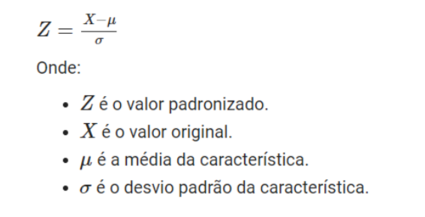


<br>

Na normalização, os dados são ajustados para que fiquem em uma escala comum. Isso geralmente é feito escalando os valores das características para que fiquem dentro de um intervalo específico, geralmente entre 0 e 1. A fórmula geral para normalização depende do intervalo desejado, mas uma das formas mais comuns é:

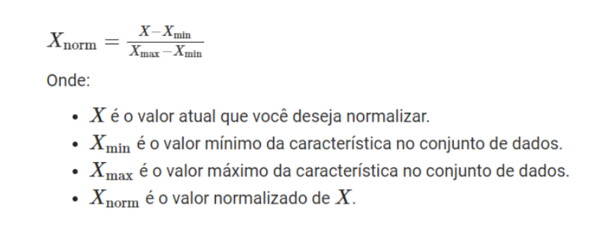


<br>

O quadro abaixo traz um exemplo de aplicação das duas técnicas de escalonamento:

| Valor | Valor_Padronizado | Valor_Normalizado |
|-------|-------------------|-------------------|
|   10  |     -1.486301     |        0.0        |
|   20  |     -1.156012     |        0.1        |
|   30  |     -0.825723     |        0.2        |
|   40  |     -0.495434     |        0.3        |
|   50  |     -0.165145     |        0.4        |
|   60  |      0.165145     |        0.5        |
|   70  |      0.495434     |        0.6        |
|   80  |      0.825723     |        0.7        |
|   90  |      1.156012     |        0.8        |
|  100  |      1.486301     |        1.0        |


<br>

### **Preparação de dados para Feature Selection**


À partir deste ponto, todos os ajustes necessários serão realizados primeiro nos dados de treino e replicados para os dados de teste. Os ajustes à seguir são necessários para que possamos realizar a etapa de **Feature Selection**, de forma a reduzir o número de variáveis do modelo, mantendo somente aquelas verdadeiramente relevantes. Os critério adotados nesta etapa são:

* Exclusão de variáveis com percentual de nulos maior ou igual a 70%.

* Variáveis **numéricas** terão seus valores nulos preenchidos com a **mediana** da distribuição.

* Variáveis **categóricas** terão seus valores nulos substituídos pela string **"sem-info"**.

* Em variáveis **categóricas** com carnalidade igual ou menor que **20 domínios** será utilizado o OneHotEncoder para a codificação. Nas demais variáveis, será utilizado o LabelEncoder.

* Não será aplicada nenhuma técnica de escalonamento dos dados pois o algoritmo utilizado na Feature Selection não demanda este tipo de tratamento.

<br>

In [ ]:
# Removendo o gênero da modelagem
abt_00.drop('CODE_GENDER' , axis=1, inplace=True)

In [ ]:
# Realizando a preparação dos dados.

# A função abaixo realiza :
# - Separação de treino e tete,com abordagem out-of-time
# - Imputação de valores missing em variáveis numéricas e categóricas
# - Exclusão de variáveis com alto percentual de missing
# - Codificação de variáveiscategóricas em numéricas
# - Padronização dos dados

dataprep_01 = dataprep_out_of_time(df=abt_00, target='TARGET', col_id='SK_ID_CURR', metadados=metadados_00,
                                  col_safra='DATA_REF', encoder_method='onehot+label', scaler=False,
                                  safra_min_train = '202112', safra_max_train='202208',
                                  safra_min_test='202209', safra_max_test='202212')

In [ ]:
# Resumo do dataprep
print(dataprep_01.resume)

Resumo dataprep:

      • Limite de cardinalidade adotado: 20
      • Limite de percentual de nulos adotado: 70%
      • Quantidade de variáveis dropadas por nulos: 0
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: 14
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: 1
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado


In [ ]:
# Restaurando a Tabela Analítica de Modelagem de TREINO
X_train_01 = dataprep_01.X_train_enc               # Restaura as variáveis explicativas
y_train_01 = dataprep_01.y_train                   # Restaura a target
id_train = dataprep_01.col_id_train                # Restaura o ID
safra_train = dataprep_01.col_safra_train          # Restaura a coluna de safra

abt_train_01 = pd.concat([X_train_01, y_train_01, id_train, safra_train] , axis=1)


# Restaurando a Tabela Analítica de Modelagem de TESTE
X_test_01 = dataprep_01.X_test_enc                 # Restaura as variáveis explicativas
y_test_01 = dataprep_01.y_test                     # Restaura a target
id_test = dataprep_01.col_id_test                  # Restaura o ID
safra_test = dataprep_01.col_safra_test            # Restaura a coluna de safra

abt_test_01 = pd.concat([X_test_01, y_test_01, id_test, safra_test] , axis=1)

# Tabela Analítica
abt_01 = pd.concat([abt_train_01 , abt_test_01] , axis=0)


In [ ]:
# Validando volumetrias
print(f'''
ABT_Treino: {abt_train_01.shape}
ABT_Teste:  {abt_test_01.shape}
ABT:        {abt_01.shape}''')


ABT_Treino: (213091, 179)
ABT_Teste:  (94420, 179)
ABT:        (307511, 179)


In [ ]:
# Metadados
metadados_01 = report_data(abt_01)
metadados_01


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 1
Quantidade de features numéricas: 178             |    Quantidade de features categóricas 1
Cardinalidade total das categóricas: 13           |    Dataframe: 307511 linhas, 179 colunas



Feature     Tipo    Card  %Miss  %Out_sup  \
0                          CNT_CHILDREN    int64      15    0.0       1.4   
1                      AMT_INCOME_TOTAL  float64    2548    0.0       4.6   
2                            AMT_CREDIT  float64    5603    0.0       2.1   
3                           AMT_ANNUITY  float64   13672    0.0       2.4   
4                       AMT_GOODS_PRICE  float64    1002    0.0       4.8   
..                                  ...      ...     ...    ...       ...   
174       EMERGENCYSTATE_MODE_Yes_dummy  float64       2    0.0       0.8   
175  EMERGENCYSTATE_MODE_sem-info_dummy  float64       2    0.0       0.0   
176                              TARGET    int64       2    0.0       8.1   
177                          SK_ID_CURR    int64  307511    0.0       0.0   
178                            DATA_REF   object      13    0.0       0.0   

     %Out_inf  %Outliers      Moda  %Freq  
0         0.0        1.4       0.0   70.0  
1         0.0        4.6  135000.0   11.6  
2         0.0        2.1  450000.0    3.2  
3         0.0        2.4    9000.0    2.1  
4         0.0        4.8  450000.0    8.6  
..        ...        ...       ...    ...  
174       0.0        0.8       0.0   99.2  
175       0.0        0.0       0.0   52.6  
176       0.0        8.1       0.0   91.9  
177       0.0        0.0  100002.0    0.0  
178       0.0        0.0    202205    8.4  

[179 rows x 9 columns]

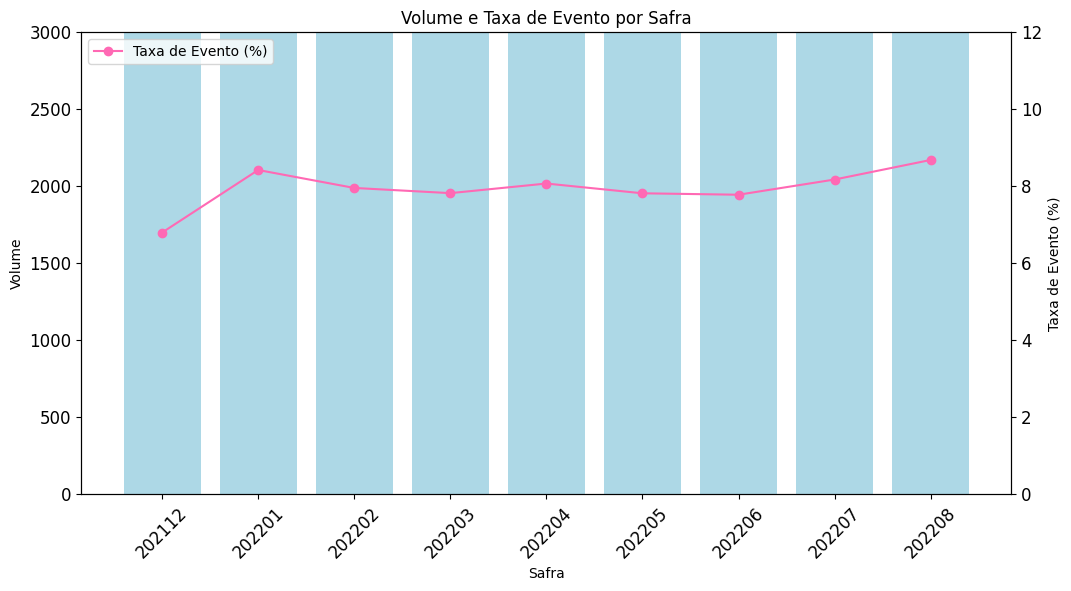

In [ ]:
# Verificando a taxa de evento nos dados de treino
df_taxa_evento_train = plot_tx_event_volume_safra(abt_train_01, target='TARGET', safra='DATA_REF', ymax_volume=3000, ymax_taxa_evento=12, rot_label = 45)

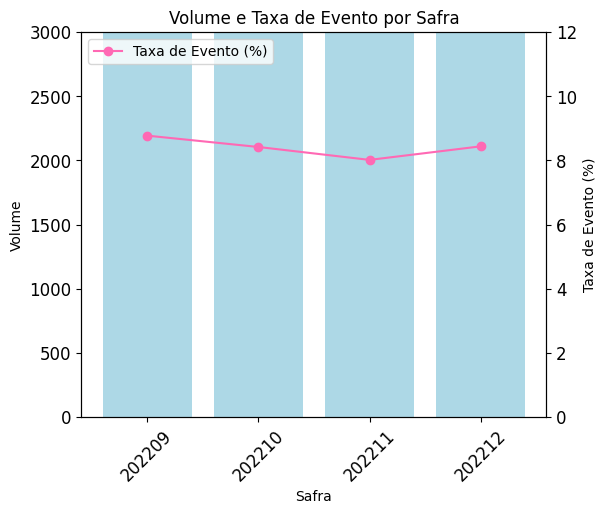

In [ ]:
# Verificando a taxa de evento nos dados de teste
df_taxa_evento_teste = plot_tx_event_volume_safra(abt_test_01, target='TARGET', safra='DATA_REF', ymax_volume=3000, ymax_taxa_evento=12, rot_label = 45 , figsize=(6,5))

### **Feature Selection**


Features removidas: 165
Features remanescentes: 11



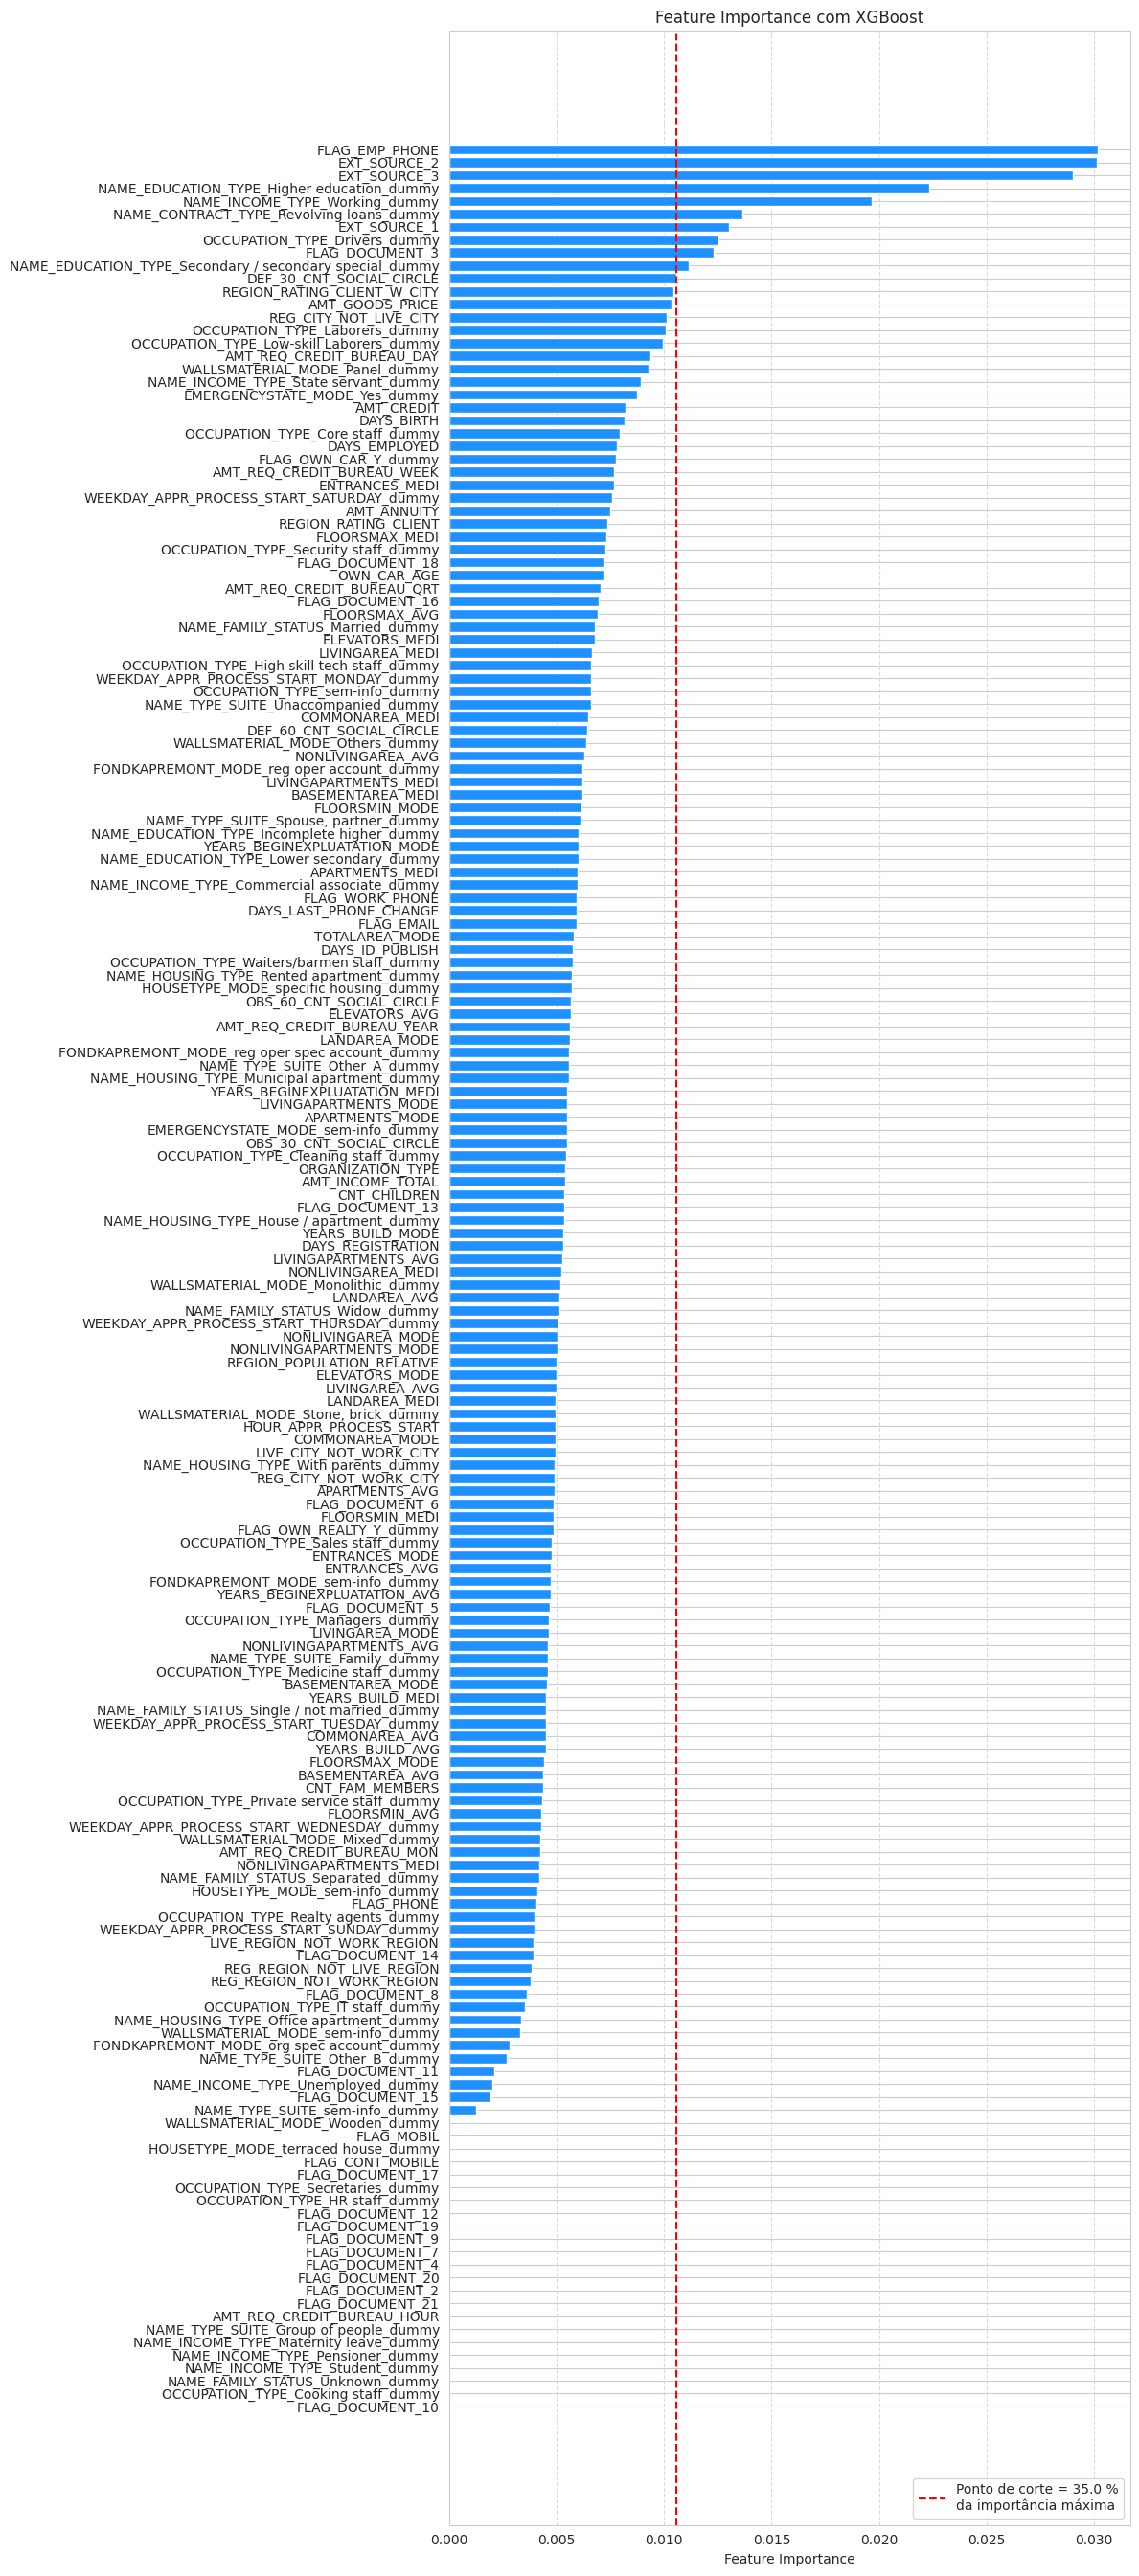

In [ ]:
# Feature selection por Feature Importance

from xgboost import XGBClassifier

# Instanciando o modelo
model=XGBClassifier(random_state=42)

lista_features_selecionadas = fs_importance(model = model, X=X_train_01, y=y_train_01,
                                            cutoff_importance=0.35, plot=True,
                                            figsize=(12,27),
                                            model_name='XGBoost')

####**Análise das Features remanescentes**

A seguir é feita uma análise sobre as features remanescentes e seu significado, do ponto de vista do negócio, para saber se faz sentido ou não utilizá-las na modelegem de risco de crédito:


* **FLAG_EMP_PHONE (Flag para telefone comercial informado)**:

 a presença de um telefone comercial informado pode indicar estabilidade financeira e uma conexão mais sólida com o mercado de trabalho, além de que o fornecimento do contato minimiza a probabilidaade de intenção de fraude por parte do solicitante. **Faz sentido utilizar esta variável**.

<br>

* **EXT_SOURCE_2 (Score externo da fonte 2)**:

 fornece uma medida da confiabilidade financeira do cliente com base em seu histórico de crédito e comportamento financeiro no mercado. Este score é gerado com base em informações de desabonos ou protestos em aberto junto a outras instituições. É uma potuação generalista, não levando em conta um mercado ou operação específica. **Faz sentido utilizar esta variável**.

<br>

* **EXT_SOURCE_3 (Score externo da fonte 3)**:

 idem ao EXT_SOURCE_2. **Faz sentido utilizar esta variável**.

<br>

* **NAME_EDUCATION_TYPE (Escolaridade)**:

 a escolaridade pode ser um indicador importante da estabilidade financeira e capacidade de pagamento do cliente. Presume-se que pessoas com níveis mais altos de educação tendem a ter uma renda mais estável e melhores habilidades de gerenciamento financeiro, o que pode influenciar positivamente sua capacidade de honrar compromissos de crédito. **Faz sentido utilizar esta variável**.

<br>

* **NAME_INCOME_TYPE (Origem da renda)**:

 a origem da renda é crucial para entender a fonte e a estabilidade financeira do cliente. Por exemplo, indivíduos com renda proveniente de empregos estáveis podem ser considerados menos arriscados do que aqueles com renda proveniente de trabalho autônomo ou de fontes menos estáveis. **Faz sentido utilizar esta variável**.

<br>

* **NAME_CONTRACT_TYPE (Tipo de empréstimo)**:

 o tipo de empréstimo pode fornecer insights sobre a natureza e os termos do contrato de crédito, o que pode influenciar a probabilidade de inadimplência. Por exemplo, empréstimos rotativos podem ter taxas de juros variáveis, tornando-os potencialmente mais arriscados para o mutuário. **Faz sentido utilizar esta variável**.

<br>

* **EXT_SOURCE_1 (Score externo da fonte 1)**:

 idem ao EXT_SOURCE_2 e EXT_SOURCE_2. **Faz sentido utilizar esta variável**.

<br>

* **OCCUPATION_TYPE (Ocupação)**:

 a ocupação do cliente pode fornecer insights sobre sua estabilidade financeira e capacidade de pagamento. Algumas ocupações podem indicar maior segurança financeira e estabilidade de emprego, enquanto outras podem ser mais voláteis. **Faz sentido utilizar esta variável**.

<br>

* **FLAG_DOCUMENT_3 (Flag para o documento 3)**:

 é importante entender por que esse documento específico foi incluído como uma variável de seleção de recursos. Dependendo do contexto e do conteúdo do documento, pode fornecer informações adicionais sobre a situação financeira do cliente ou seu histórico de crédito. Em se tratando de um case hipotético, ao qual não temos acesso à equipe de gestão dos dados pora que possamos entender melhor sobreo documento em questão, vamos manter esta variável e, caso a mesma causa problemas no decorrer do projeto, a excluiremos. **Portanto, faz sentido utilizar esta variável**.

<br>

* **DEF_30_CNT_SOCIAL_CIRCLE (Quantas observações do ambiente social do cliente foram inadimplentes em 30 dias de atraso)**:

 esta variável fornece informações sobre o comportamento de pagamento de pessoas do círculo social do cliente. Se muitas dessas observações estiverem inadimplentes, pode sugerir um ambiente social de maior risco e, consequentemente, um risco de crédito mais elevado para o cliente. **Faz sentido utilizar esta variável.**

<br>


In [ ]:
# Variáveis selecionadas
# Incluindo variáveis dummy
lista_features_selecionadas

['FLAG_EMP_PHONE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_3',
 'NAME_CONTRACT_TYPE_Revolving loans_dummy',
 'NAME_INCOME_TYPE_Working_dummy',
 'NAME_EDUCATION_TYPE_Higher education_dummy',
 'NAME_EDUCATION_TYPE_Secondary / secondary special_dummy',
 'OCCUPATION_TYPE_Drivers_dummy']

In [ ]:
# Removendo sufixo "_dummy" e mantendo apenas a parte anterior à penúltima '_'
lista = [item.rsplit('_', 2)[0] if item.endswith('_dummy') else item for item in lista_features_selecionadas]

# Convertendo para conjunto para remover duplicatas e convertendo novamente para lista
lista = list(set(lista))

# Exibindo a lista sem duplicatas
lista

['EXT_SOURCE_2',
 'NAME_CONTRACT_TYPE',
 'OCCUPATION_TYPE',
 'FLAG_DOCUMENT_3',
 'EXT_SOURCE_1',
 'FLAG_EMP_PHONE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_3',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE']

In [ ]:
# Criando nova tabela somente com as features selecionadas
abt_02 = abt_00[lista + ['TARGET', 'SK_ID_CURR' , 'DATA_REF']]

# Criando novo metadados
metadados_02 = report_data(abt_02)

# Visualizando
metadados_02


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 5
Quantidade de features numéricas: 8               |    Quantidade de features categóricas 5
Cardinalidade total das categóricas: 46           |    Dataframe: 307511 linhas, 13 colunas



Feature     Tipo    Card  %Miss  %Out_sup  %Out_inf  \
0               EXT_SOURCE_2  float64  119831    0.2       0.0       0.0   
1         NAME_CONTRACT_TYPE   object       2    0.0       0.0       0.0   
2            OCCUPATION_TYPE   object      18   31.3       0.0       0.0   
3            FLAG_DOCUMENT_3    int64       2    0.0       0.0       0.0   
4               EXT_SOURCE_1  float64  114584   56.4       0.0       0.0   
5             FLAG_EMP_PHONE    int64       2    0.0       0.0      18.0   
6   DEF_30_CNT_SOCIAL_CIRCLE  float64      10    0.3      11.4       0.0   
7               EXT_SOURCE_3  float64     814   19.8       0.0       0.0   
8           NAME_INCOME_TYPE   object       8    0.0       0.0       0.0   
9        NAME_EDUCATION_TYPE   object       5    0.0       0.0       0.0   
10                    TARGET    int64       2    0.0       8.1       0.0   
11                SK_ID_CURR    int64  307511    0.0       0.0       0.0   
12                  DATA_REF   object      13    0.0       0.0       0.0   

    %Outliers                           Moda  %Freq  
0         0.0                       0.285898    0.2  
1         0.0                     Cash loans   90.5  
2         0.0                       Laborers   17.9  
3         0.0                            1.0   71.0  
4         0.0                       0.356323    0.0  
5        18.0                            1.0   82.0  
6        11.5                            0.0   88.2  
7         0.0                         0.7463    0.5  
8         0.0                        Working   51.6  
9         0.0  Secondary / secondary special   71.0  
10        8.1                            0.0   91.9  
11        0.0                       100002.0    0.0  
12        0.0                         202205    8.4

In [ ]:
# Criando novo dataprep
dataprep_03 = dataprep_out_of_time(
    abt_02, target='TARGET', col_id = 'SK_ID_CURR' , metadados = metadados_02,
    scaled=False, encoder_method=None, col_safra='DATA_REF',
    safra_min_train = '202112', safra_max_train='202208',
    safra_min_test='202209', safra_max_test='202212')

Nesta etapa, caso houvessem variáveis categóricas, as mesmas não passariam pelo processo de transformação em dummys (aplicação de encoder), pois seriam transformadas em etapa posterior junto das variáveis numéricas categorizadas.

In [ ]:
# Resumo do dataprep
print(dataprep_03.resume)

Resumo dataprep:

      • Limite de percentual de nulos adotado: 70%
      • Quantidade de variáveis dropadas por nulos: 0
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado


In [ ]:
# Restaurando os dados de treino (redução do nome para facilidade)

# Treino
X_train_03 = dataprep_03.X_train
y_train_03 = dataprep_03.y_train
id_train = dataprep_03.col_id_train
safra_train = dataprep_03.col_safra_train

# Teste
X_test_03 = dataprep_03.X_test
y_test_03 = dataprep_03.y_test
id_test = dataprep_03.col_id_test
safra_test = dataprep_03.col_safra_test


# Montando a tabela analítica adicionando target e ID

# Treino
abt_train_03 = X_train_03.copy()
abt_train_03['TARGET'] = y_train_03.tolist()
abt_train_03['SK_ID_CURR'] = id_train.tolist()
abt_train_03['DATA_REF'] = safra_train.tolist()

# Teste
abt_test_03 = X_test_03.copy()
abt_test_03['TARGET'] = y_test_03.tolist()
abt_test_03['SK_ID_CURR'] = id_test.tolist()
abt_test_03['DATA_REF'] = safra_test.tolist()


# Concatenando
abt_03 = pd.concat([abt_train_03 , abt_test_03] , axis=0, ignore_index=True)

# Exibindo
abt_03.sample(3)

EXT_SOURCE_2 NAME_CONTRACT_TYPE OCCUPATION_TYPE  FLAG_DOCUMENT_3  \
38892      0.621310         Cash loans        Laborers                1   
38937      0.624464         Cash loans      Core staff                1   
75820      0.671416         Cash loans     Sales staff                1   

       EXT_SOURCE_1  FLAG_EMP_PHONE  DEF_30_CNT_SOCIAL_CIRCLE  EXT_SOURCE_3  \
38892      0.412453               1                       0.0      0.336062   
38937      0.589541               1                       0.0      0.533482   
75820      0.364233               1                       0.0      0.535276   

      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  TARGET  SK_ID_CURR  \
38892          Working  Secondary / secondary special       0      293647   
38937          Working               Higher education       0      343687   
75820          Working  Secondary / secondary special       0      436470   

      DATA_REF  
38892   202112  
38937   202202  
75820   202112

In [ ]:
# Metadados
metadados_03 = report_data(abt_03)
metadados_03


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 0
Quantidade de features numéricas: 8               |    Quantidade de features categóricas 5
Cardinalidade total das categóricas: 47           |    Dataframe: 307511 linhas, 13 colunas



Feature     Tipo    Card  %Miss  %Out_sup  %Out_inf  \
0               EXT_SOURCE_2  float64  119831    0.0       0.0       0.0   
1         NAME_CONTRACT_TYPE   object       2    0.0       0.0       0.0   
2            OCCUPATION_TYPE   object      19    0.0       0.0       0.0   
3            FLAG_DOCUMENT_3    int64       2    0.0       0.0       0.0   
4               EXT_SOURCE_1  float64  114585    0.0      21.8      21.8   
5             FLAG_EMP_PHONE    int64       2    0.0       0.0      18.0   
6   DEF_30_CNT_SOCIAL_CIRCLE  float64      10    0.0      11.4       0.0   
7               EXT_SOURCE_3  float64     814    0.0       0.0       1.4   
8           NAME_INCOME_TYPE   object       8    0.0       0.0       0.0   
9        NAME_EDUCATION_TYPE   object       5    0.0       0.0       0.0   
10                    TARGET    int64       2    0.0       8.1       0.0   
11                SK_ID_CURR    int64  307511    0.0       0.0       0.0   
12                  DATA_REF   object      13    0.0       0.0       0.0   

    %Outliers                           Moda  %Freq  
0         0.0                       0.285898    0.2  
1         0.0                     Cash loans   90.5  
2         0.0                       sem-info   31.3  
3         0.0                            1.0   71.0  
4        43.6                        0.50625   56.4  
5        18.0                            1.0   82.0  
6        11.4                            0.0   88.6  
7         1.4                       0.535276   20.1  
8         0.0                        Working   51.6  
9         0.0  Secondary / secondary special   71.0  
10        8.1                            0.0   91.9  
11        0.0                       100002.0    0.0  
12        0.0                         202205    8.4

<Axes: >

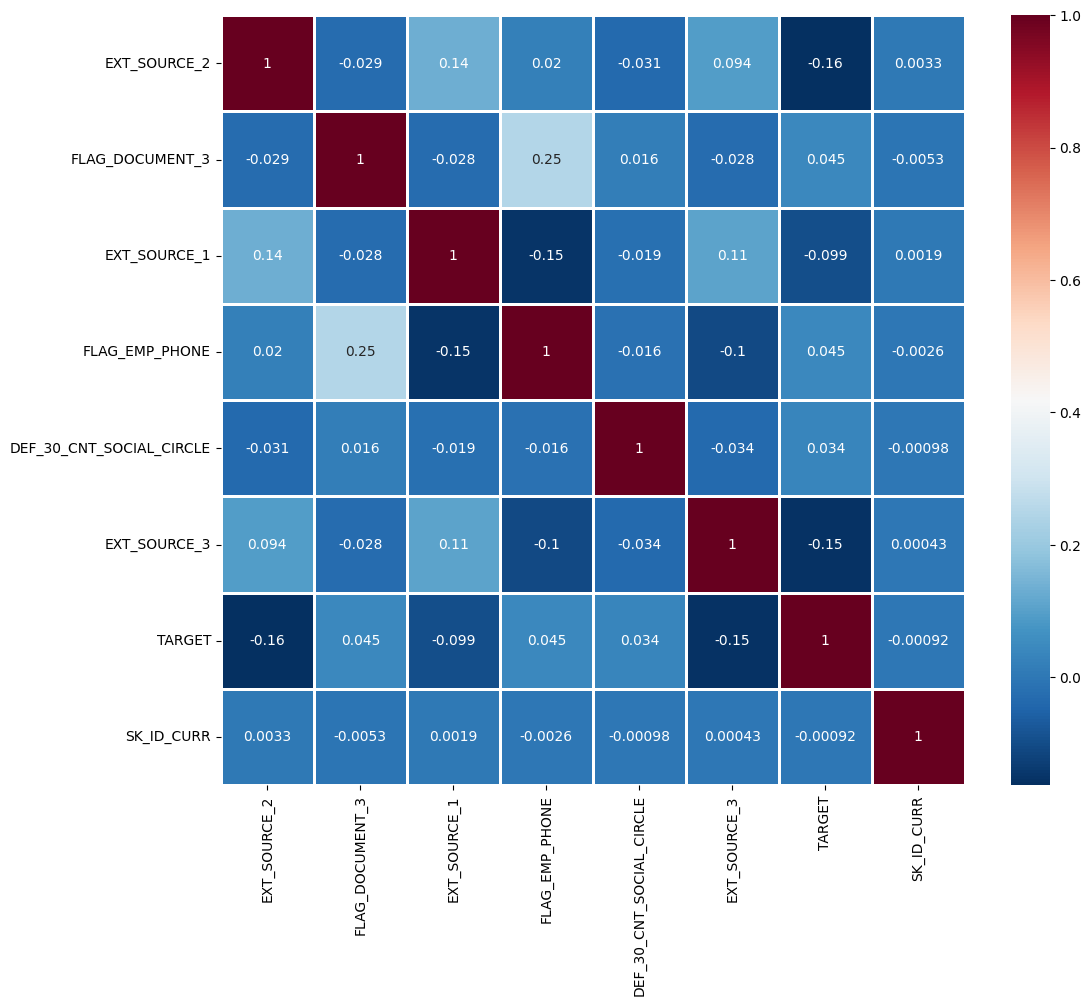

In [ ]:
# Verificando o mapa de correlação de Pearson
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(abt_train_03.corr() , annot = True , linewidths=1 , cmap = 'RdBu_r')


# TABELA DE CORRELAÇÃO
# # Verificando a correlação entre as variáveis selecionadas
# df_aux = X_train_03.copy()
# df_aux['TARGET'] = y_train_03


# # Calcula a matriz de correlação
# correlation_matrix = df_aux.corr()

# # Transforma a matriz em um DataFrame com a descrição desejada
# correlation_df = pd.DataFrame(columns=['Variável 1 x Variável 2', 'Correlação'])
# added_combinations = set()

# for col1 in correlation_matrix.columns:
#     for col2 in correlation_matrix.index:
#         if col1 != col2 and (col1, col2) not in added_combinations and (col2, col1) not in added_combinations:
#             correlation_df = correlation_df.append({
#                 'Variável 1 x Variável 2': f'{col1} x {col2}',
#                 'Correlação': correlation_matrix.loc[col2, col1]  # Correção na ordem das variáveis
#             }, ignore_index=True)
#             added_combinations.add((col1, col2))

# # Ordena o DataFrame por ordem decrescente de correlação
# correlation_df = correlation_df.sort_values(by='Correlação', ascending=False)

# # Exibe o resultado
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# correlation_df.head(20)

In [ ]:
# Dropando uma feature com correlação acima de 0.80

# abt_train_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)
# abt_test_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)
# X_train_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)
# X_test_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)

# lista_features_selecionadas.remove('LIVINGAREA_MEDI')
# lista('LIVINGAREA_MEDI')

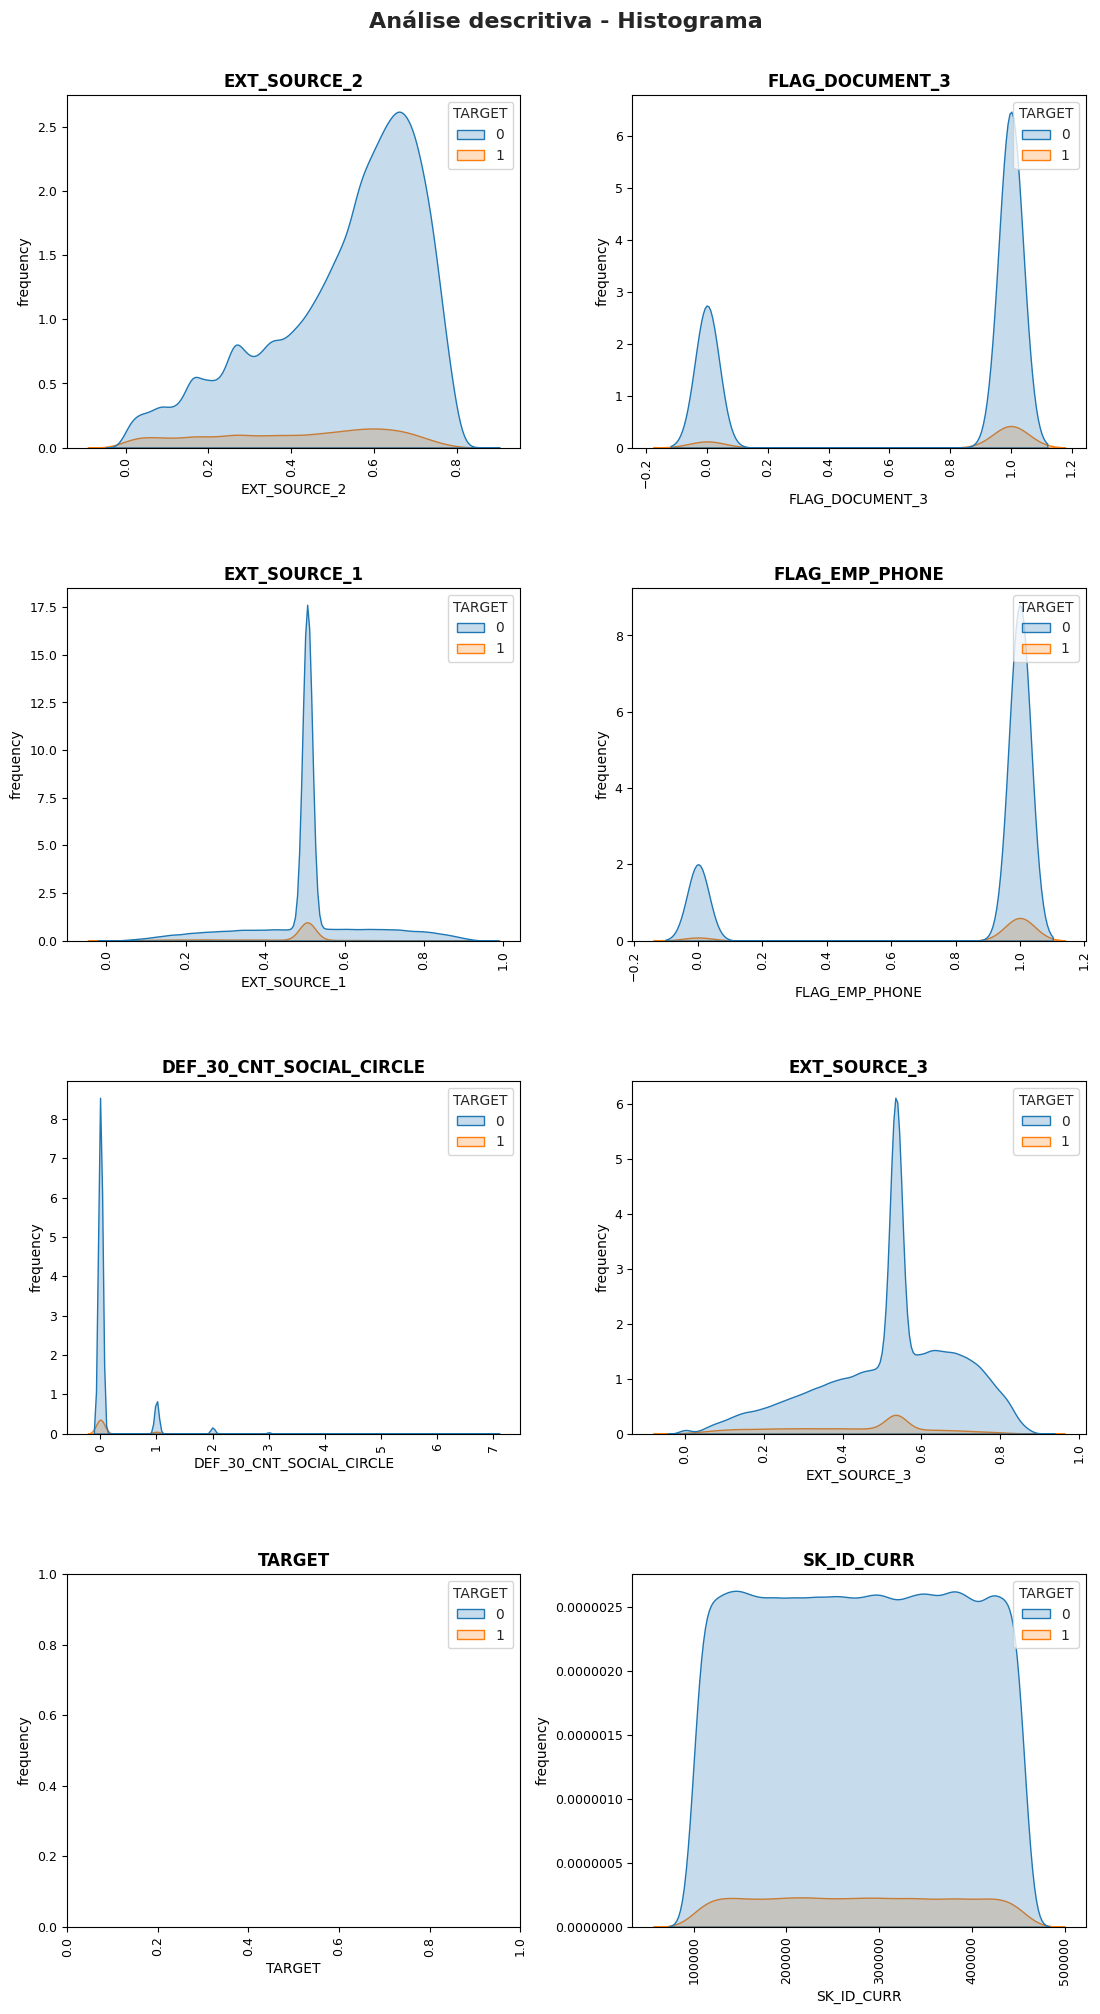

In [ ]:
# Visualizando a distribuição das features seleciondas em relação à target
plot_batch_histogram(abt_train_03, hue='TARGET', cols=2, b=12)

Observação: a análise dos preditores será feita somente após a primeira modelagem, para que se verifique o desempenho do modelo. Sendo assim, todas as features serão mantidas no modelo baseline.

##Categorizando as Features de baixa cardinalidade

In [ ]:
# Ponto de corte de cardinalidade - 20 domínios
# Menor que 20 domínios - analisar se são ordinais
# Precisa ter ordenação da taxa de evento em relação as categorias
# Precisa ser estável ao longo do tempo: linhas não podem se cruzar nas safras

corte_card = 20

In [ ]:
# Extraindo as features com cardinalidade abaixo do corte

# filtro: cardinalidade menor ou igual a 20 e tipo igual a 'int32/64' ou 'float32/64'
# verificar a existência de outros formatos de inteiros ou float (exemplo: int8, float8)

vars_ordinais = list(metadados_03.loc[ (metadados_03['Card'] <= corte_card) &
                                       ((metadados_03['Tipo']=='int32') |
                                       (metadados_03['Tipo']=='int64') |
                                       (metadados_03['Tipo']=='float32') |
                                       (metadados_03['Tipo']=='float64')), 'Feature'])

# Removendo a target e a safra
if 'TARGET' in vars_ordinais:
  vars_ordinais.remove('TARGET')
if 'DATA_REF' in vars_ordinais:
  vars_ordinais.remove('DATA_REF')
if 'SK_ID_CURR' in vars_ordinais:
  vars_ordinais.remove('SK_ID_CURR')

# Exibindo
vars_ordinais

['FLAG_DOCUMENT_3', 'FLAG_EMP_PHONE', 'DEF_30_CNT_SOCIAL_CIRCLE']

In [ ]:
# ==============================================
# TESTE DE AGRUPAMENTO DAS CATEGÓRICAS ORIGINAIS
# ==============================================

vars_ordinais.append('NAME_EDUCATION_TYPE')
vars_ordinais.append('OCCUPATION_TYPE')
vars_ordinais.append('NAME_INCOME_TYPE')

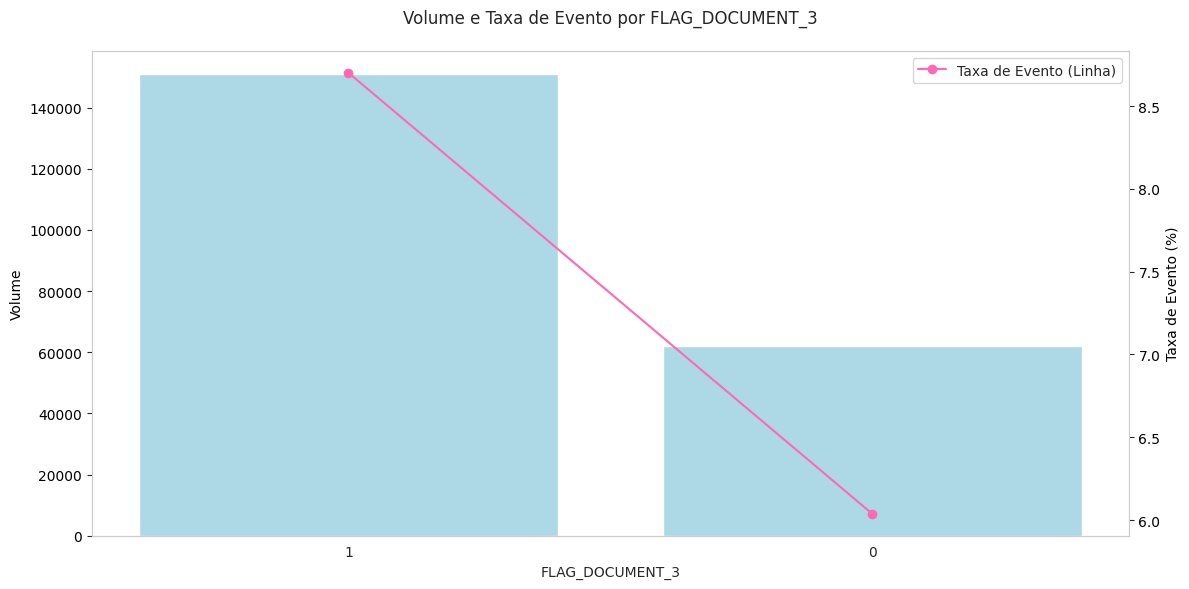

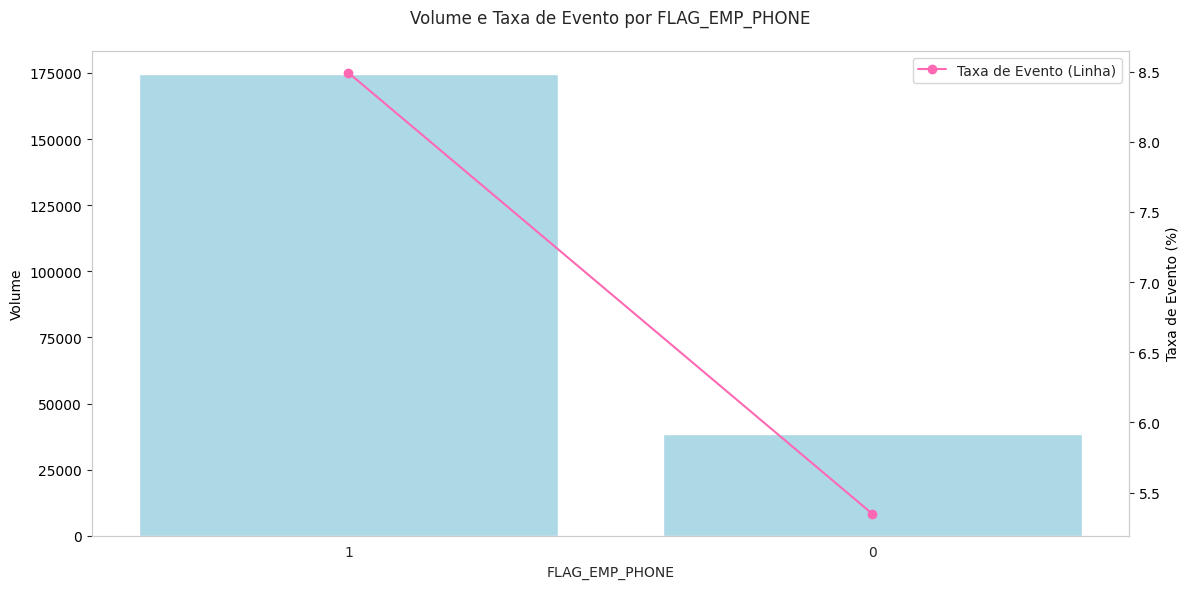

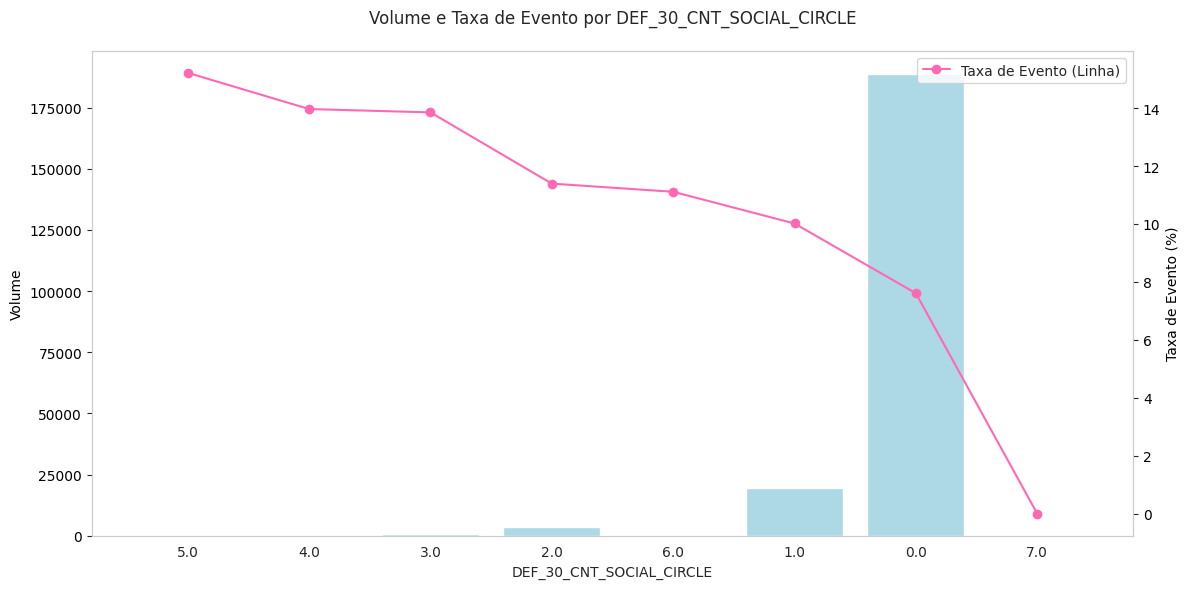

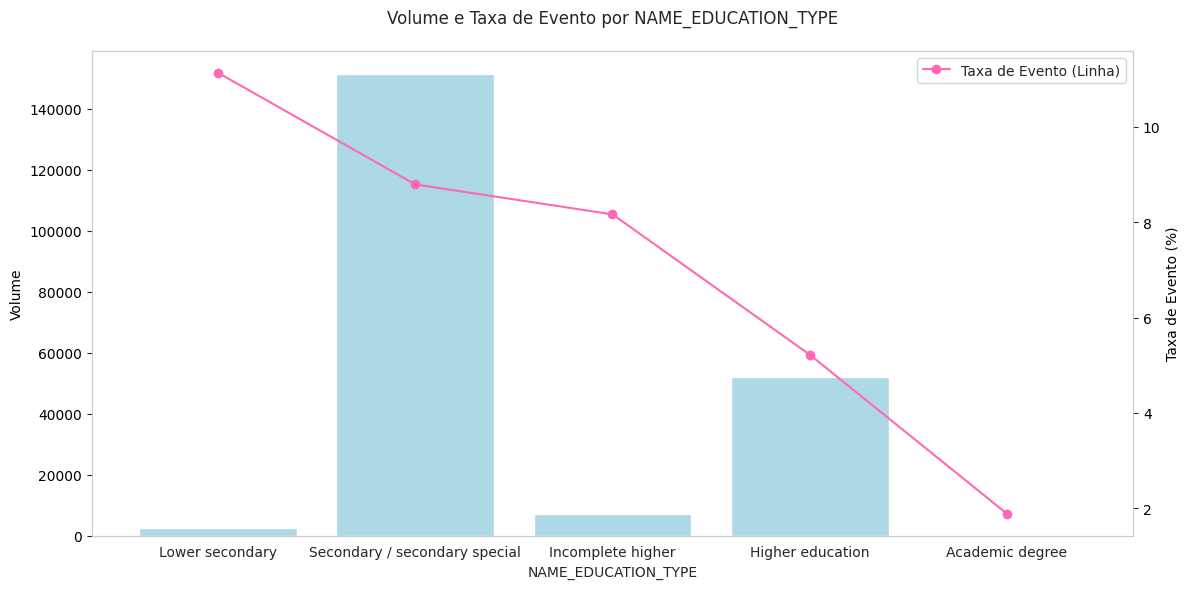

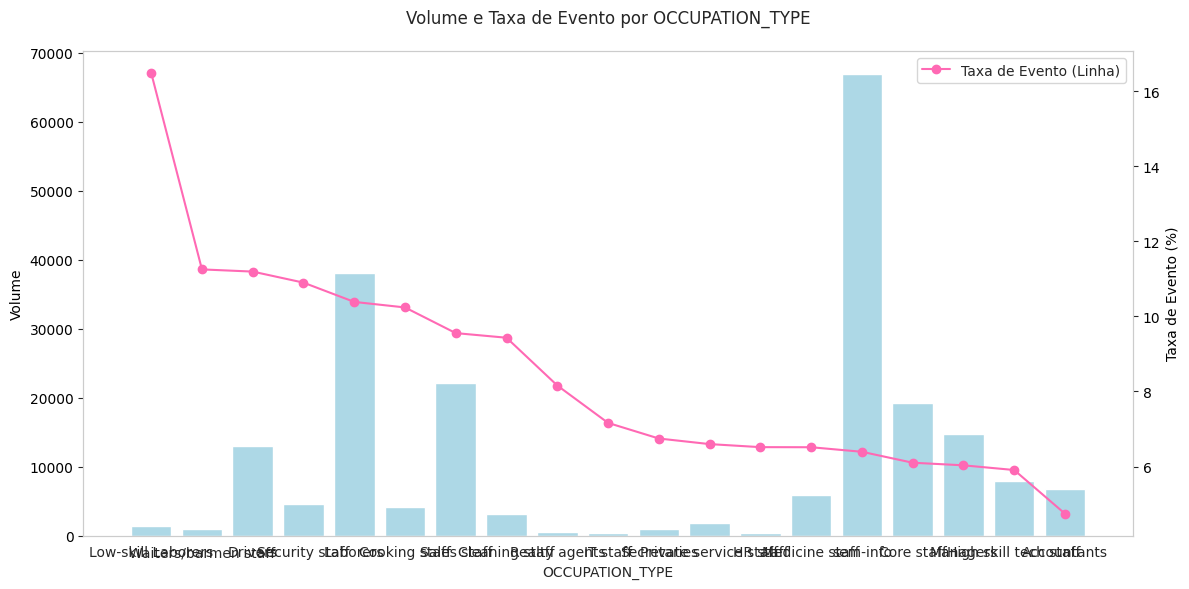

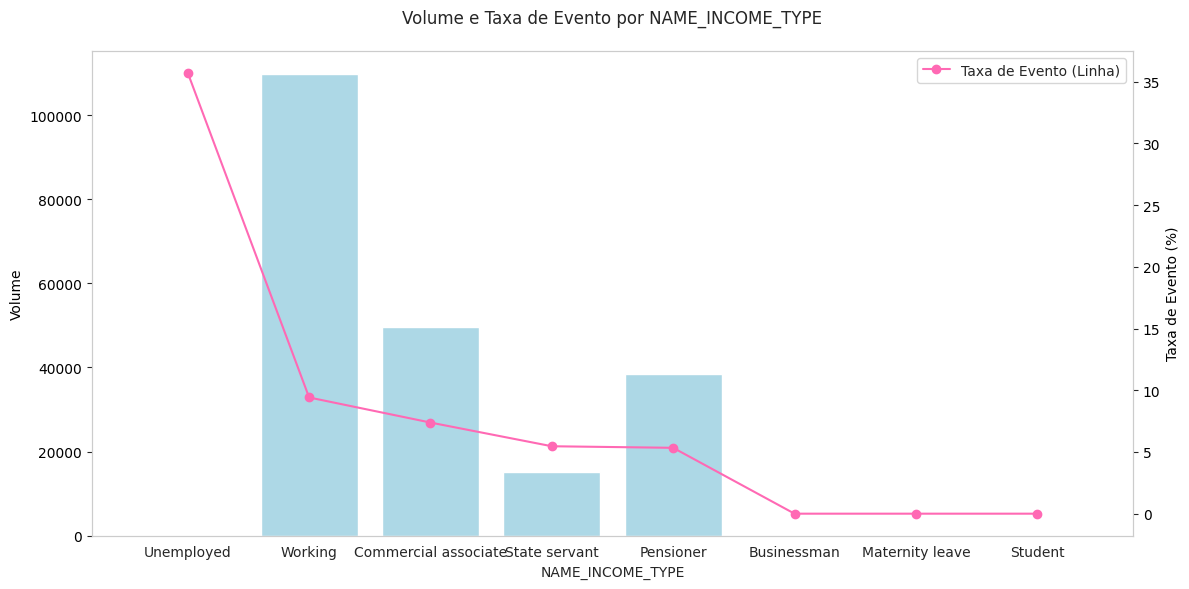

In [ ]:
# Verificando a taxa de evento de acordo com a categoria da Feature

# Iterando na lista de variáveis ordinais e gerando uma análise pra cada
for var in vars_ordinais:
  result = analyze_variable(abt_train_03, var, "TARGET")

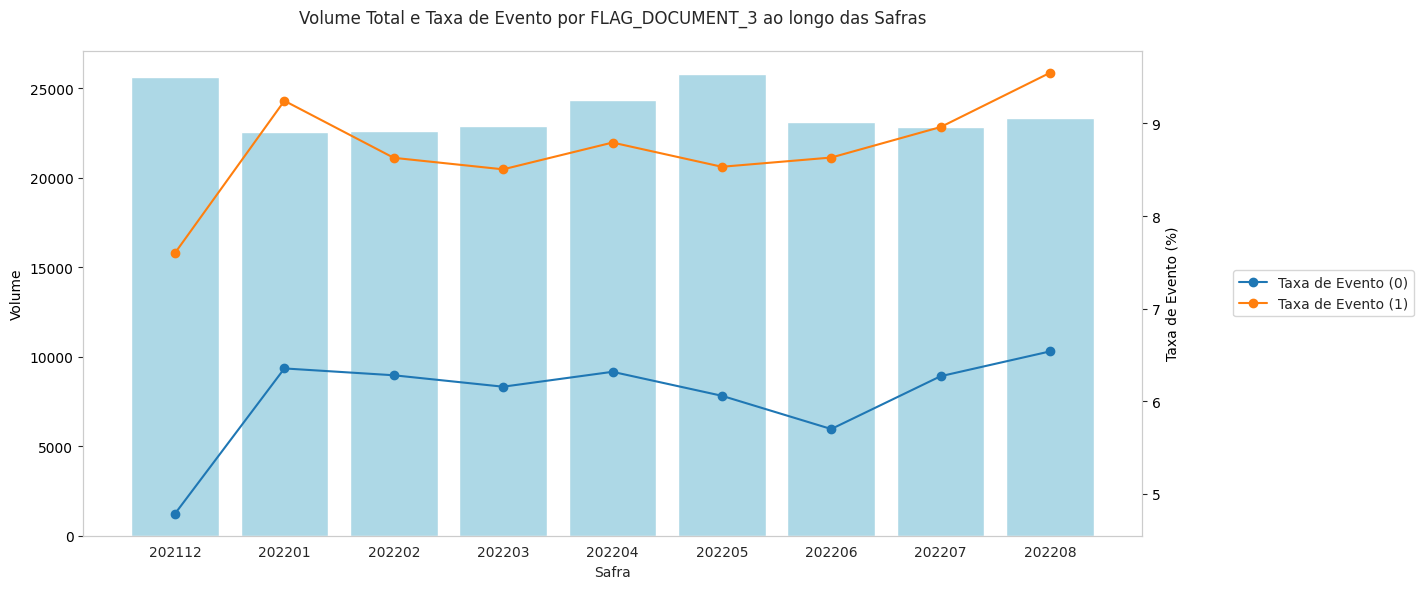

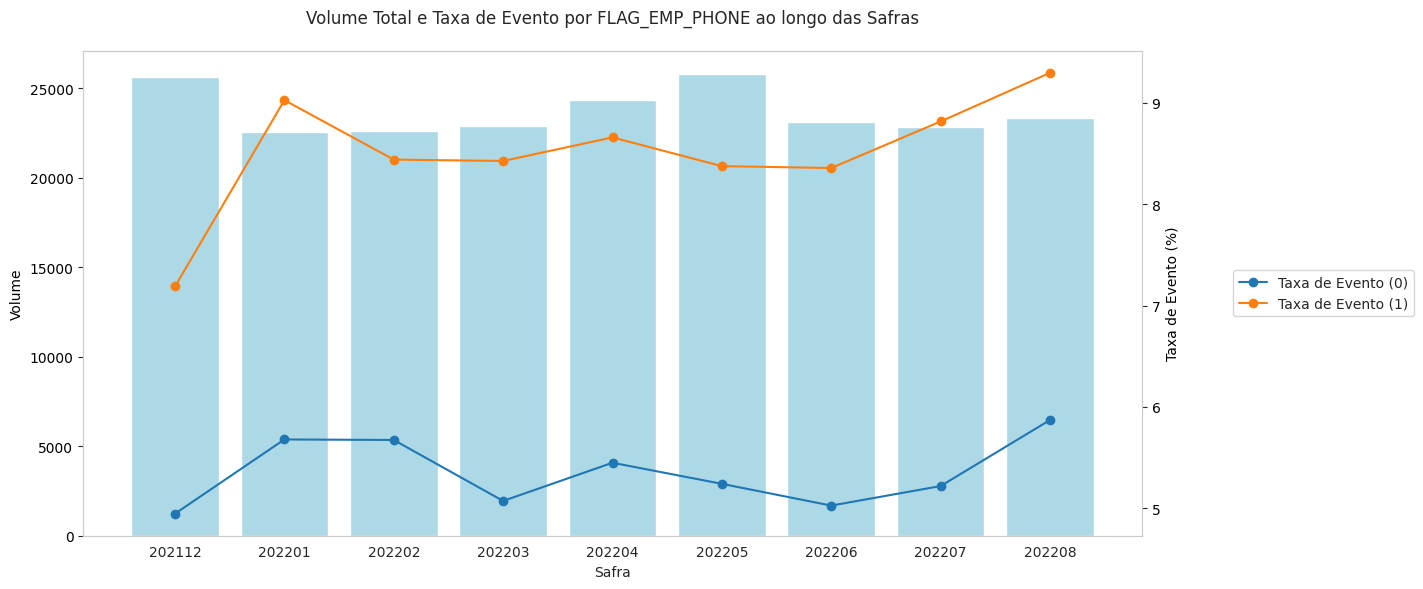

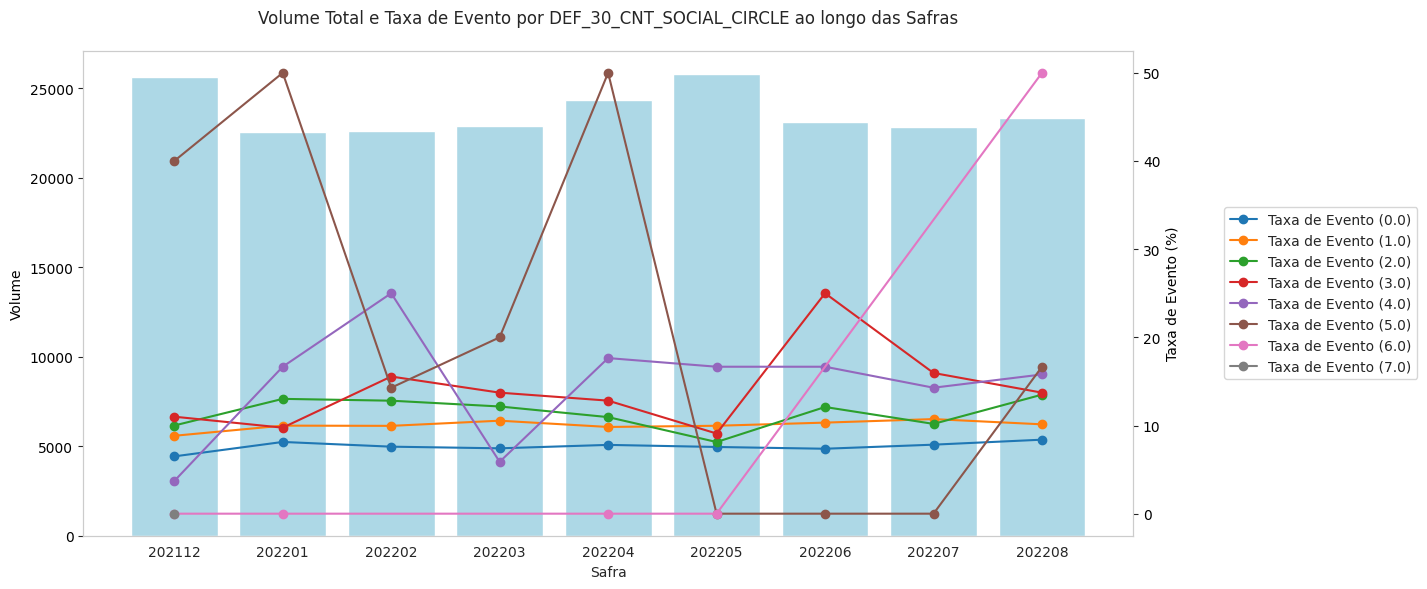

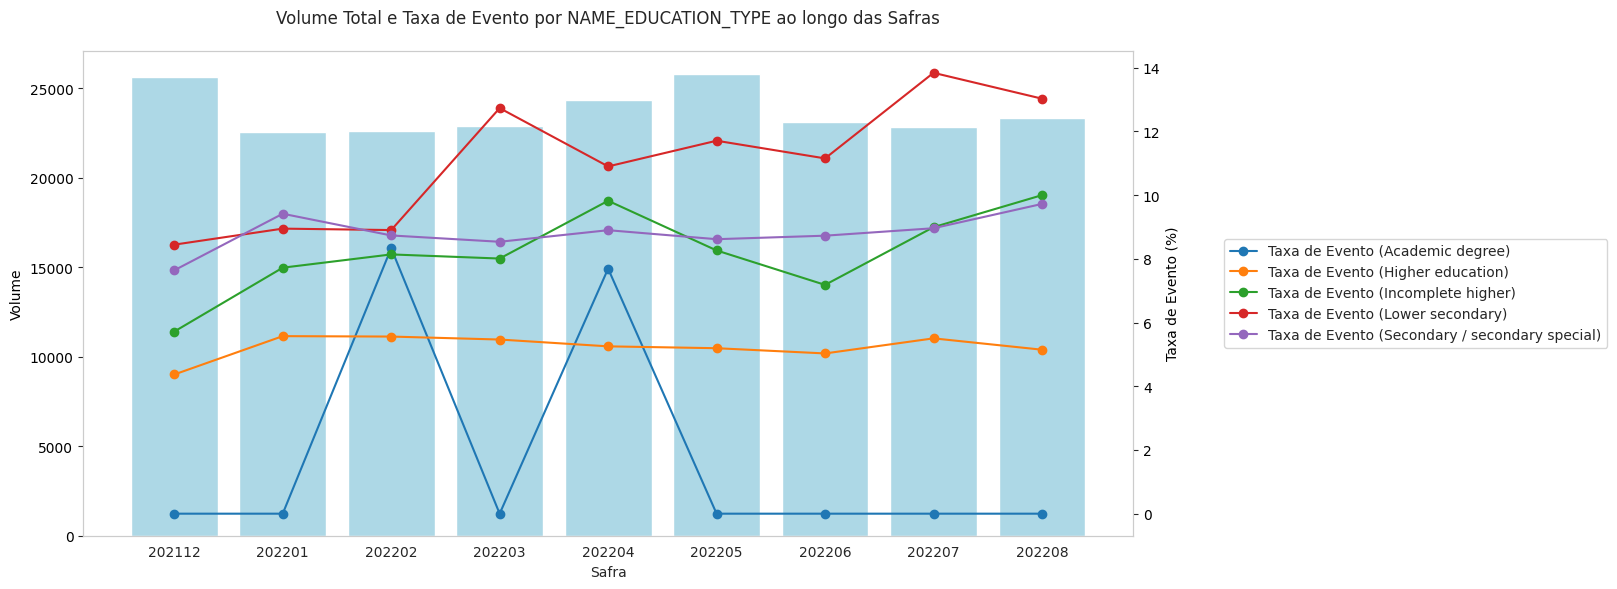

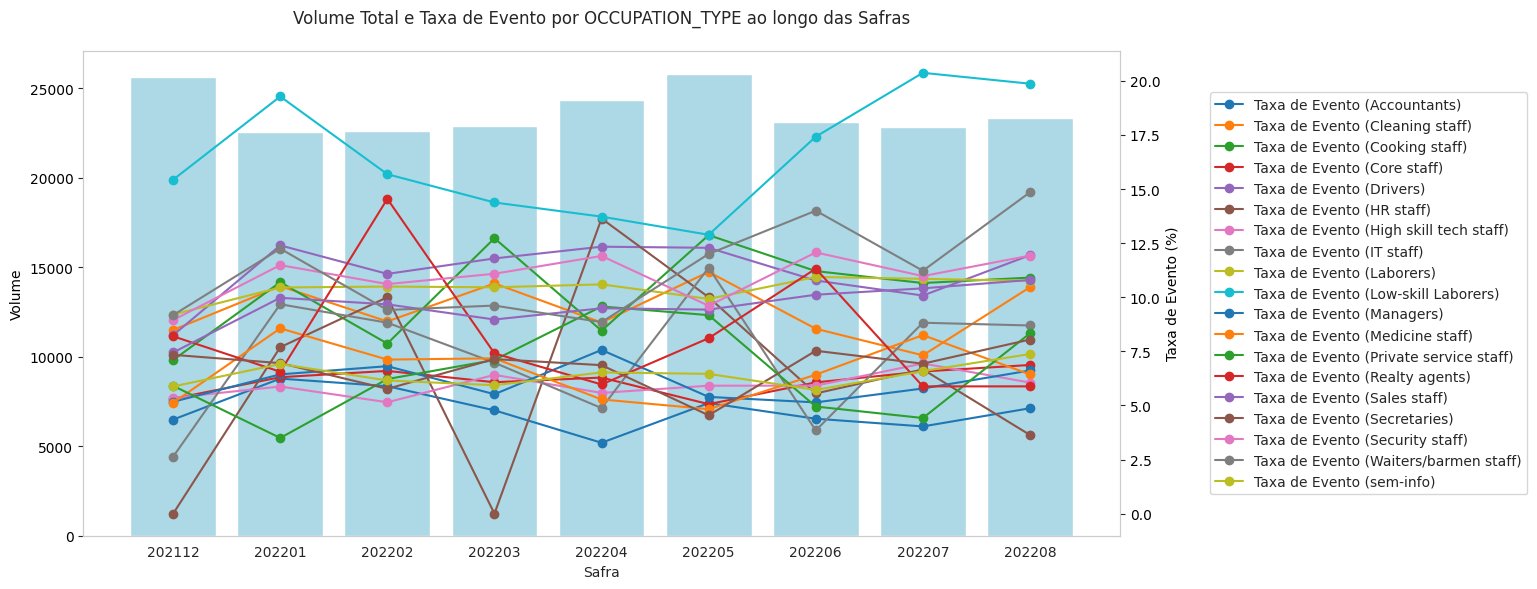

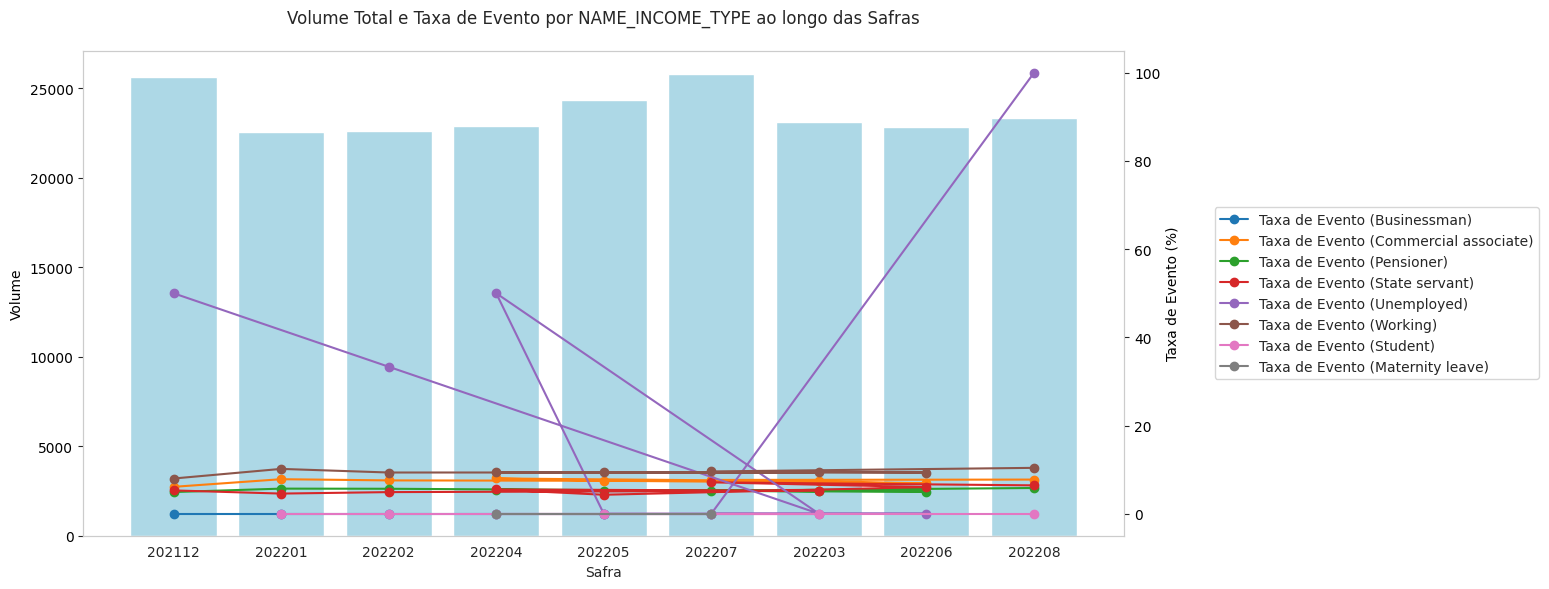

In [ ]:
# Verificando a estabilidade da taxa de evento por categoria e por safra

# Iterando pela lista das variáveis e plotando os gráficos
for var in vars_ordinais:
  plot_by_safra(abt_train_03, "TARGET", var, "DATA_REF")

###Agrupamento de categorias da feature DEF_30_CNT_SOCIAL_CIRCLE

In [ ]:
# Gerando o dicionário de domínios

unique_values = abt_train_03['DEF_30_CNT_SOCIAL_CIRCLE'].unique()
domain_map = {value: value for value in unique_values}

print("domain_map = {")
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print("              }")

domain_map = {
               '0.0': '0.0',
               '2.0': '2.0',
               '1.0': '1.0',
               '3.0': '3.0',
               '5.0': '5.0',
               '4.0': '4.0',
               '6.0': '6.0',
               '7.0': '7.0',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios

# O nome do domínio agrupado pode ser definido nos vaores do dicionário:
# Exemplo 1: agrupar categorias 3 e 4:
#     --> '3.0':'3.0_+_4.0' | '4.0':'3.0_ou_4.0'
# Exemplo 2: agrupar categorias Pintor e Gesseiro:
#     --> 'Pintor':'Pintor_Gesseiro' | 'Gesseiro':'Pintor_Gesseiro'

# Agrupar categorias com a mesma taxa de evento observada
# no gráfico de ordenação equivale a utilizar o método "Quociente B/M"
# Mostrado no livro Credit Scoring (categorias com mesmo percentual de Bons e Maus)

# Em variáveis quantitativas ordinais (idade, renda, etc),
# agrupar somente categorias adjacentes.
# Exemplo: Anos de estudo: '3-5' agrupar com '6-9', e não com '13-15'



domain_map = {
               '0.0': '0.0',
               '2.0': '2.0',
               '1.0': '2.0',
               '3.0': '2.0',
               '5.0': '2.0',
               '4.0': '2.0',
               '6.0': '2.0',
               '7.0': '0.0',
              }

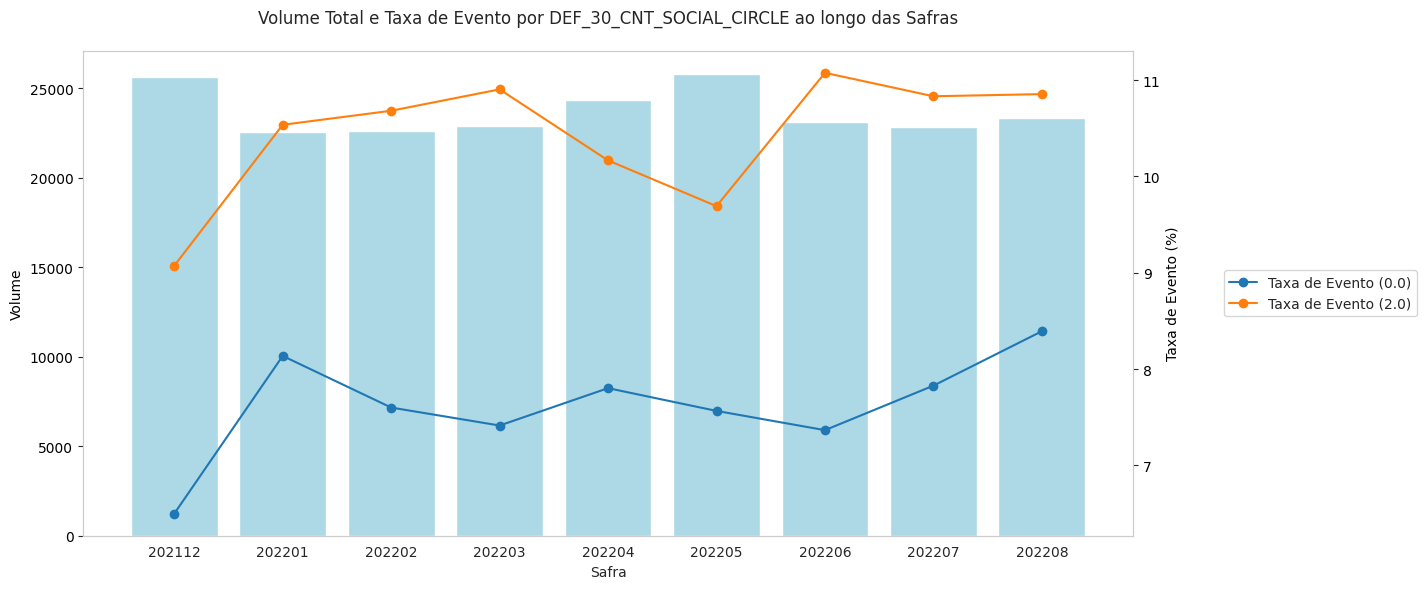

In [ ]:
# Visualizando a estabilidade temporal
transformation = group_and_plot_by_safra(abt_train_03, "TARGET", "DEF_30_CNT_SOCIAL_CIRCLE", "DATA_REF", domain_map)

In [ ]:
# Aplicando as transformações e (criando novas tabelas)

# Aplica nos dados de treino
abt_train_04 = apply_grouping(abt_train_03, transformation, "DEF_30_CNT_SOCIAL_CIRCLE")

# Aplica nos dados de teste
abt_test_04 = apply_grouping(abt_test_03, transformation, "DEF_30_CNT_SOCIAL_CIRCLE")

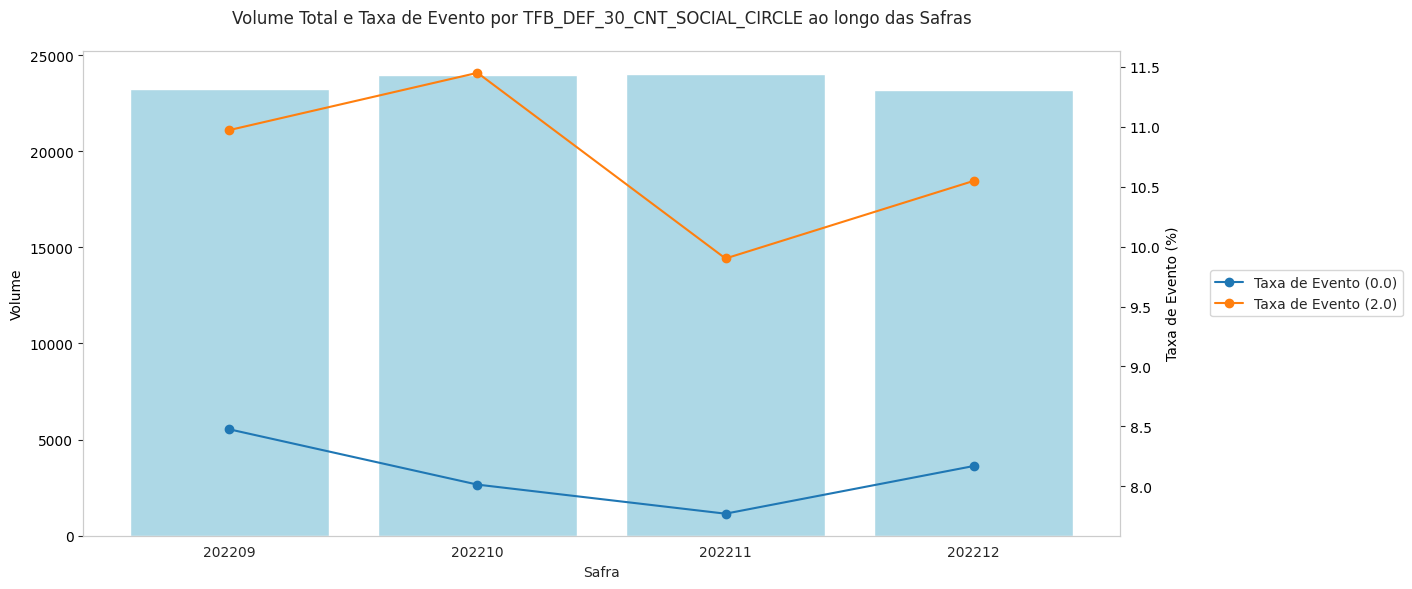

In [ ]:
# Visualizando a estabilidade temporal nos dados de teste
plot_by_safra(abt_test_04, "TARGET", 'TFB_DEF_30_CNT_SOCIAL_CIRCLE', "DATA_REF")

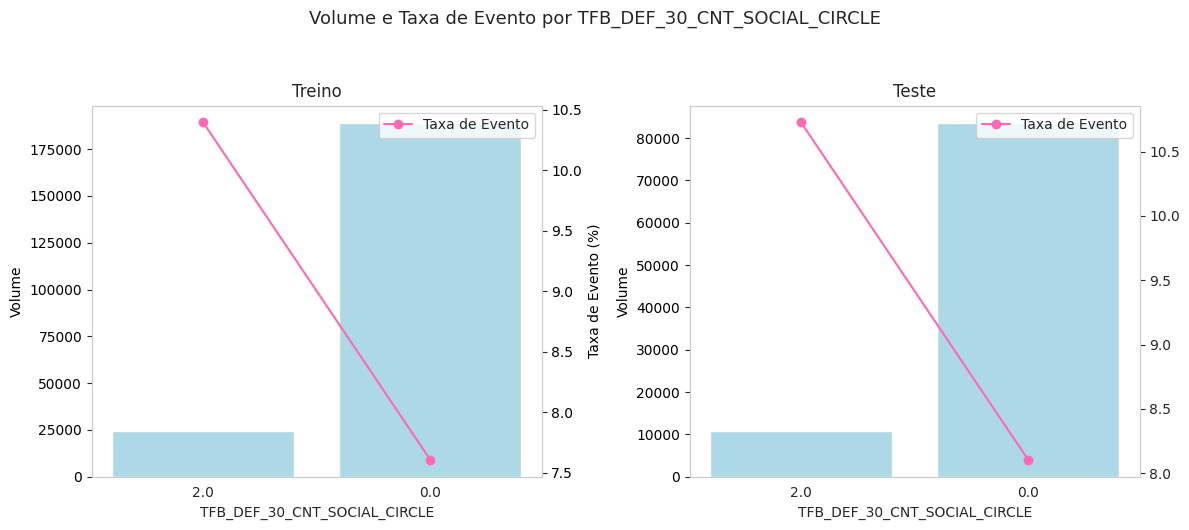

In [ ]:
# Visualizando a ordenação nos dados de treino e test
result = analyze_variable_train_and_test(abt_train_04, abt_test_04, 'TFB_DEF_30_CNT_SOCIAL_CIRCLE', "TARGET")

In [ ]:
# Restaurando a tabela analítica completa

# abt_04 = pd.concat([abt_train_04 , abt_test_04], axis=0)
# abt_04.sample(3)

EXT_SOURCE_2 NAME_CONTRACT_TYPE OCCUPATION_TYPE FLAG_DOCUMENT_3  \
19181       0.635464         Cash loans        Laborers               0   
78452       0.501062    Revolving loans        Managers               0   
141488      0.563015         Cash loans        sem-info               0   

        EXT_SOURCE_1 FLAG_EMP_PHONE  EXT_SOURCE_3 NAME_INCOME_TYPE  \
19181        0.50625              1      0.535276          Working   
78452        0.79890              1      0.499272          Working   
141488       0.50625              0      0.558507        Pensioner   

                  NAME_EDUCATION_TYPE  TARGET  SK_ID_CURR DATA_REF  \
19181   Secondary / secondary special       0      166391   202211   
78452                Higher education       0      155632   202209   
141488  Secondary / secondary special       0      284736   202205   

       TFB_DEF_30_CNT_SOCIAL_CIRCLE  
19181                           0.0  
78452                           0.0  
141488                          2.0

### Teste de agrupamento das variáveis categóricas - NAME_EDUCATION_TYPE


In [ ]:
# Gerando o dicionário de domínios

unique_values = abt_train_03['NAME_EDUCATION_TYPE'].unique()
domain_map = {value: value for value in unique_values}

print("domain_map = {")
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print("              }")

domain_map = {
               'Secondary / secondary special': 'Secondary / secondary special',
               'Higher education': 'Higher education',
               'Lower secondary': 'Lower secondary',
               'Incomplete higher': 'Incomplete higher',
               'Academic degree': 'Academic degree',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios

# O nome do domínio agrupado pode ser definido nos vaores do dicionário:
# Exemplo 1: agrupar categorias 3 e 4:
#     --> '3.0':'3.0_+_4.0' | '4.0':'3.0_ou_4.0'
# Exemplo 2: agrupar categorias Pintor e Gesseiro:
#     --> 'Pintor':'Pintor_Gesseiro' | 'Gesseiro':'Pintor_Gesseiro'

# Agrupar categorias com a mesma taxa de evento observada
# no gráfico de ordenação equivale a utilizar o método "Quociente B/M"
# Mostrado no livro Credit Scoring (categorias com mesmo percentual de Bons e Maus)

# Em variáveis quantitativas ordinais (idade, renda, etc),
# agrupar somente categorias adjacentes.
# Exemplo: Anos de estudo: '3-5' agrupar com '6-9', e não com '13-15'


domain_map = {
               'Secondary / secondary special': 'Secondary / secondary special',
               'Higher education': 'Higher education',
               'Lower secondary': 'Lower secondary',
               'Incomplete higher': 'Secondary / secondary special',
               'Academic degree': 'Higher education',
              }

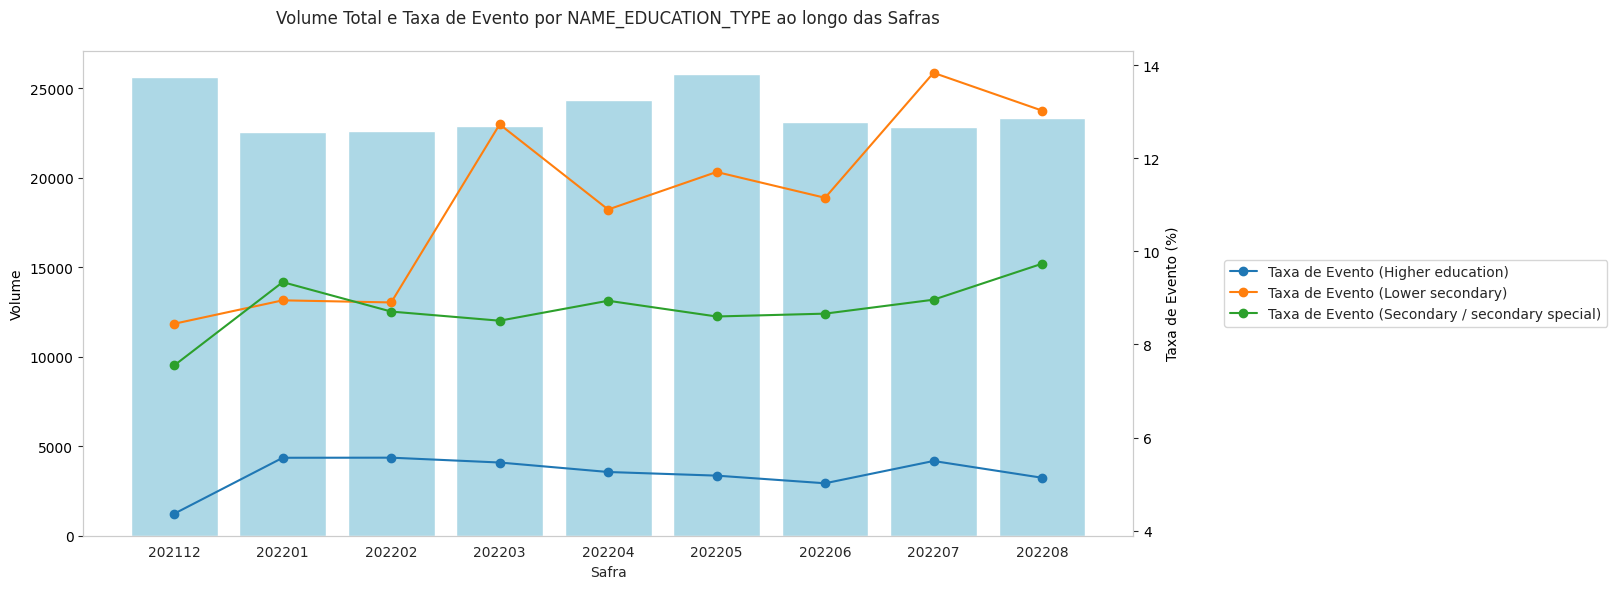

In [ ]:
# Visualizando a estabilidade temporal
transformation = group_and_plot_by_safra(abt_train_03, "TARGET", "NAME_EDUCATION_TYPE", "DATA_REF", domain_map)

In [ ]:
# Aplicando as transformações e (criando novas tabelas)

# Aplica nos dados de treino
abt_train_04 = apply_grouping(abt_train_04, transformation, "NAME_EDUCATION_TYPE") # --<< atenção para a referência da tabela que será transformada

# Aplica nos dados de teste
abt_test_04 = apply_grouping(abt_test_04, transformation, "NAME_EDUCATION_TYPE")

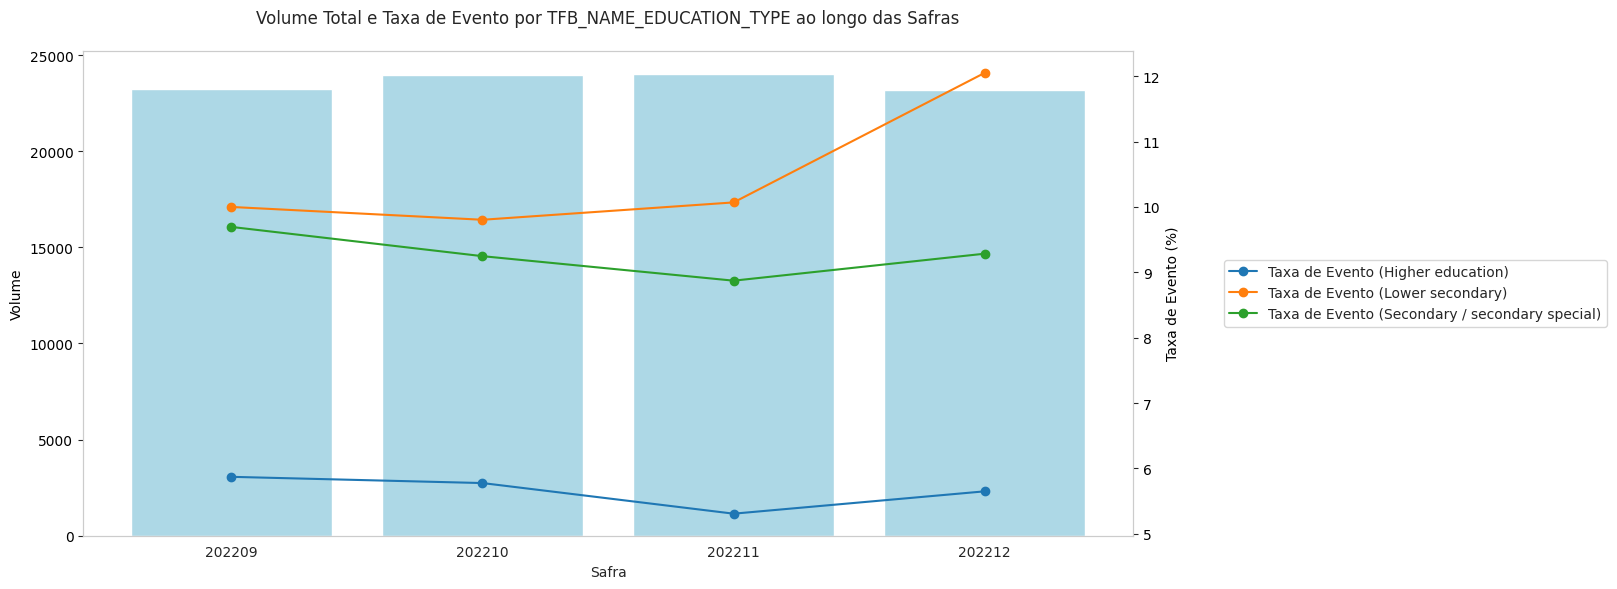

In [ ]:
# Visualizando a estabilidade temporal nos dados de teste
plot_by_safra(abt_test_04, "TARGET", 'TFB_NAME_EDUCATION_TYPE', "DATA_REF")

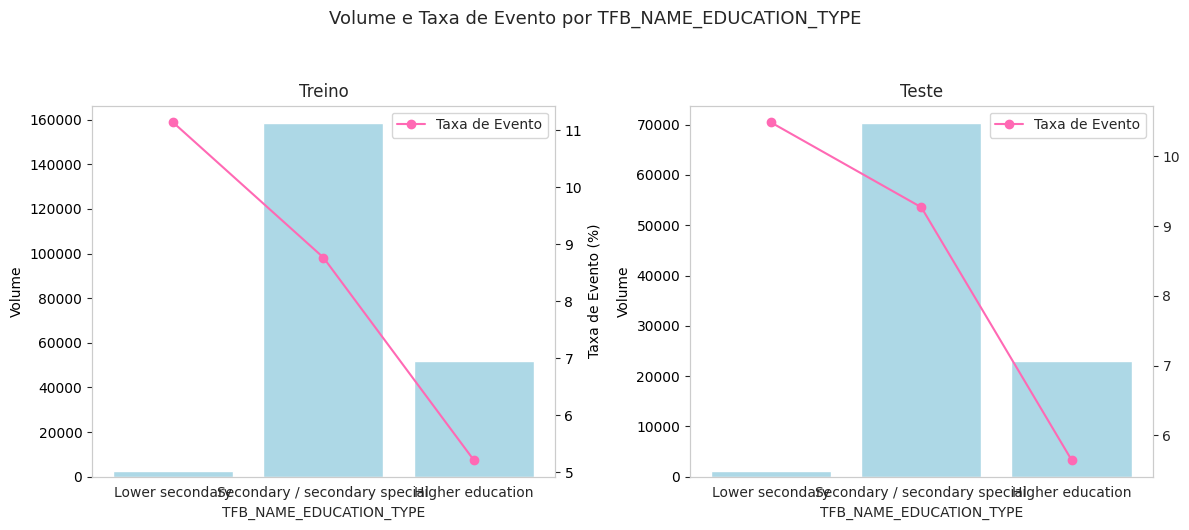

In [ ]:
# Visualizando a ordenação nos dados de treino e test
result = analyze_variable_train_and_test(abt_train_04, abt_test_04, 'TFB_NAME_EDUCATION_TYPE', "TARGET")

### Restaurando a tabela analítica completa

In [ ]:
# Restaurando a tabela analítica completa

abt_04 = pd.concat([abt_train_04 , abt_test_04], axis=0)
abt_04.sample(3)

EXT_SOURCE_2 NAME_CONTRACT_TYPE OCCUPATION_TYPE FLAG_DOCUMENT_3  \
62475      0.740712         Cash loans     Accountants               1   
30195      0.593741         Cash loans  Security staff               1   
33587      0.614112    Revolving loans        Managers               0   

       EXT_SOURCE_1 FLAG_EMP_PHONE  EXT_SOURCE_3      NAME_INCOME_TYPE  \
62475      0.491116              1      0.401407  Commercial associate   
30195      0.506250              1      0.535276               Working   
33587      0.506250              1      0.719491  Commercial associate   

       TARGET  SK_ID_CURR DATA_REF TFB_DEF_30_CNT_SOCIAL_CIRCLE  \
62475       0      189443   202208                          0.0   
30195       0      453645   202208                          0.0   
33587       0      315131   202208                          0.0   

             TFB_NAME_EDUCATION_TYPE  
62475               Higher education  
30195  Secondary / secondary special  
33587  Secondary / secondary special

###Demais variáveis numéricas de baixa cardinalidade

In [ ]:
# Transformando as demais variáveis de baixa cardinalidade e
# que não serão argupadas para o tipo "object"

# Copiando a lista de variáveis de baixa cardinalidade
resto_vars = vars_ordinais.copy()

# Removendo da lista as variáveis que já foram categorizadas
resto_vars.remove('DEF_30_CNT_SOCIAL_CIRCLE')
resto_vars.remove('NAME_EDUCATION_TYPE')

# Transformando(não será inserido o prefixo "TFB")
for i in resto_vars:
  abt_train_04[i] = abt_train_04[i].apply(lambda x: str(x))
  abt_test_04[i] = abt_test_04[i].apply(lambda x: str(x) )
  abt_04[i] = abt_04[i].apply(lambda x: str(x))

# abt_train_04[resto_vars] = abt_train_04[resto_vars].astype('object')
# abt_test_04[resto_vars] = abt_test_04[resto_vars].astype('object')
# abt_04[resto_vars] = abt_04[resto_vars].astype('object')

# Atualizando o metadados
metadados_04 = report_data(abt_test_04)
metadados_04


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 1
Quantidade de features numéricas: 5               |    Quantidade de features categóricas 8
Cardinalidade total das categóricas: 42           |    Dataframe: 94420 linhas, 13 colunas



Feature     Tipo   Card  %Miss  %Out_sup  %Out_inf  \
0                   EXT_SOURCE_2  float64  63210    0.0       0.0       0.0   
1             NAME_CONTRACT_TYPE   object      2    0.0       0.0       0.0   
2                OCCUPATION_TYPE   object     19    0.0       0.0       0.0   
3                FLAG_DOCUMENT_3   object      2    0.0       0.0       0.0   
4                   EXT_SOURCE_1  float64  39181    0.0      21.8      21.9   
5                 FLAG_EMP_PHONE   object      2    0.0       0.0       0.0   
6                   EXT_SOURCE_3  float64    764    0.0       0.0       1.3   
7               NAME_INCOME_TYPE   object      8    0.0       0.0       0.0   
8                         TARGET    int64      2    0.0       8.4       0.0   
9                     SK_ID_CURR    int64  94420    0.0       0.0       0.0   
10                      DATA_REF   object      4    0.0       0.0       0.0   
11  TFB_DEF_30_CNT_SOCIAL_CIRCLE   object      2    0.0       0.0       0.0   
12       TFB_NAME_EDUCATION_TYPE   object      3    0.0       0.0       0.0   

    %Outliers                           Moda  %Freq  
0         0.0                       0.285898    0.2  
1         0.0                     Cash loans   90.6  
2         0.0                       sem-info   31.2  
3         0.0                              1   71.3  
4        43.7                        0.50625   56.3  
5         0.0                              1   82.0  
6         1.3                       0.535276   20.0  
7         0.0                        Working   51.8  
8         8.4                            0.0   91.6  
9         0.0                       100011.0    0.0  
10        0.0                         202211   25.4  
11        0.0                            0.0   88.5  
12        0.0  Secondary / secondary special   74.4

##Categorizando as Features de alta cardinalidade

In [ ]:
# Validando volumetrias
print(f'''
ABT_03: {abt_03.shape}
ABT_04: {abt_04.shape}''')


ABT_03: (307511, 13)
ABT_04: (307511, 13)


In [ ]:
# Extraindo as features com cardinalidade acima do corte

# filtro: cardinalidade maior ou igual a 20 e tipo igual a 'int32/64' ou 'float32/64'
# verificar a existência de outros formatos de inteiros ou float (exemplo: int8, float8)

vars_alta_card = list(metadados_03.loc[ (metadados_03['Card'] > corte_card) &
                                       ((metadados_03['Tipo']=='int32') |
                                       (metadados_03['Tipo']=='int64') |
                                       (metadados_03['Tipo']=='float32') |
                                       (metadados_03['Tipo']=='float64')), 'Feature'])

# Removendo a target e a safra
if 'TARGET' in vars_alta_card:
  vars_alta_card.remove('TARGET')
if 'DATA_REF' in vars_alta_card:
  vars_alta_card.remove('DATA_REF')
if 'SK_ID_CURR' in vars_alta_card:
  vars_alta_card.remove('SK_ID_CURR')

# Exibindo
vars_alta_card

['EXT_SOURCE_2', 'EXT_SOURCE_1', 'EXT_SOURCE_3']

In [ ]:
# Criar um dicionário onde as chaves são os valores da lista e os valores são todos iguais a 4
map = {valor: 4 for valor in vars_alta_card}

# Exibir o dicionário resultante
print("map = {")
for key, value in map.items():
    print(f"      '{key}': '{value}',")
print("     }")

map = {
      'EXT_SOURCE_2': '4',
      'EXT_SOURCE_1': '4',
      'EXT_SOURCE_3': '4',
     }


In [ ]:
# Definição dos domínios de forma manual

# Copiar o 'map' printado acima e colar aqui

# Ajustar para que a quantidade de categorias tenha
# pelo menos 500 observações (FONTE: Livro Credit Scoring - Laredo Sicsu)

# O nome do domínio agrupado pode ser definido nos vaores do dicionário:
# Exemplo 1: agrupar categorias 3 e 4:
#     --> '3.0':'3.0_+_4.0' | '4.0':'3.0_ou_4.0'
# Exemplo 2: agrupar categorias Pintor e Gesseiro:
#     --> 'Pintor':'Pintor_Gesseiro' | 'Gesseiro':'Pintor_Gesseiro'

# Agrupar categorias com a mesma taxa de evento observada
# no gráfico de ordenação equivale a utilizar o método "Quociente B/M"
# Mostrado no livro Credit Scoring (categorias com mesmo percentual de Bons e Maus)

# Em variáveis quantitativas ordinais (idade, renda, etc),
# agrupar somente categorias adjacentes.
# Exemplo: Anos de estudo: '3-5' agrupar com '6-9', e não com '13-15'

# Verificar se as árvores estãoagrupando categorias adjacentes nas variáveis ordinais


map = {
      'EXT_SOURCE_1': '3',
      'EXT_SOURCE_3': '3',
      'EXT_SOURCE_2': '2',
     }

In [ ]:
# Tabelas auxiliares
abt_train_aux = abt_train_04.copy()
abt_test_aux = abt_test_04.copy()

# Isolando o ID de treino
id_train_aux = abt_train_aux['SK_ID_CURR']
abt_train_aux.drop('SK_ID_CURR', axis=1 , inplace=True)

# Isolando o ID de teste
id_test_aux = abt_test_aux['SK_ID_CURR']
abt_test_aux.drop('SK_ID_CURR', axis=1 , inplace=True)

# Isolando a target (Não é necessário removê-la. As funções abaixo já o isolam)
y_train_aux = abt_train_aux['TARGET']
y_test_aux = abt_test_aux['TARGET']

# Fazendo um loop pelas variáveis de alta cardinalidade
for i in vars_alta_card:

    # Categorizando
    n_categories = int(map[i])  # Puxando do dicionário

    # Exibindo a volumetria e os limites
    result = categorize_with_decision_tree(abt_train_aux, n_categories=n_categories, target='TARGET', numeric_var=i)
    print('='*60)
    print(f'{i}')
    print('='*60)
    print(result)
    print('\n\n')

    # Aplica a categorização com Decision Tree e obtém os bins para os dados de treino
    abt_train_05 = apply_tree_bins(abt_train_aux, result, numeric_var=i)
    abt_train_05[f'TFT_{i}'] = abt_train_05[f'TFT_{i}'].astype(object) # converte pra object

    # Aplica a categorização com Decision Tree e obtém os bins para os dados de teste
    abt_test_05 = apply_tree_bins(abt_test_aux, result, numeric_var=i)
    abt_test_05[f'TFT_{i}'] = abt_test_05[f'TFT_{i}'].astype(object) # Converte pra object

    # Atualizando as tabelas
    abt_train_aux = abt_train_05.copy()
    abt_test_aux = abt_test_05.copy()


EXT_SOURCE_2
   Leaf  Taxa_de_Evento  Volume  Lower_Bound  Upper_Bound
0     1        0.141553   54022         -inf     0.397369
1     2        0.058094  159069     0.397374          inf



EXT_SOURCE_1
   Leaf  Taxa_de_Evento  Volume  Lower_Bound  Upper_Bound
0     1        0.152964   15690         -inf     0.271482
1     3        0.083214  151069     0.271486     0.507286
2     4        0.041375   46332     0.507290          inf



EXT_SOURCE_3
   Leaf  Taxa_de_Evento  Volume  Lower_Bound  Upper_Bound
0     1        0.166645   30928         -inf     0.313917
1     3        0.084990   96788     0.315472     0.535276
2     4        0.041089   85375     0.537070          inf





In [ ]:
# Restaurando os ID's
abt_train_05['SK_ID_CURR'] = id_train_aux
abt_test_05['SK_ID_CURR'] = id_test_aux

# Restaurando a target
abt_train_05['TARGET'] = y_train_aux
abt_test_05['TARGET'] = y_test_aux

# Restaurando a tabela analítica de modelagem completa
abt_05 = pd.concat([abt_train_05 , abt_test_05], axis=0)

# Visualizando
abt_05.sample(3)

NAME_CONTRACT_TYPE OCCUPATION_TYPE FLAG_DOCUMENT_3 FLAG_EMP_PHONE  \
130395         Cash loans        sem-info               1              1   
91063          Cash loans        sem-info               1              1   
82039          Cash loans        sem-info               0              1   

            NAME_INCOME_TYPE  TARGET DATA_REF TFB_DEF_30_CNT_SOCIAL_CIRCLE  \
130395         State servant       0   202204                          0.0   
91063                Working       0   202204                          0.0   
82039   Commercial associate       0   202205                          0.0   

              TFB_NAME_EDUCATION_TYPE TFT_EXT_SOURCE_2 TFT_EXT_SOURCE_1  \
130395  Secondary / secondary special                0                1   
91063                Higher education                1                1   
82039                Higher education                1                1   

       TFT_EXT_SOURCE_3  SK_ID_CURR  
130395                1      354887  
91063                 2      301401  
82039                 2      338134

In [ ]:
# Validando volumetrias
print(f'''
ABT_04: {abt_04.shape}
ABT_05: {abt_05.shape}''')


ABT_04: (307511, 13)
ABT_05: (307511, 13)


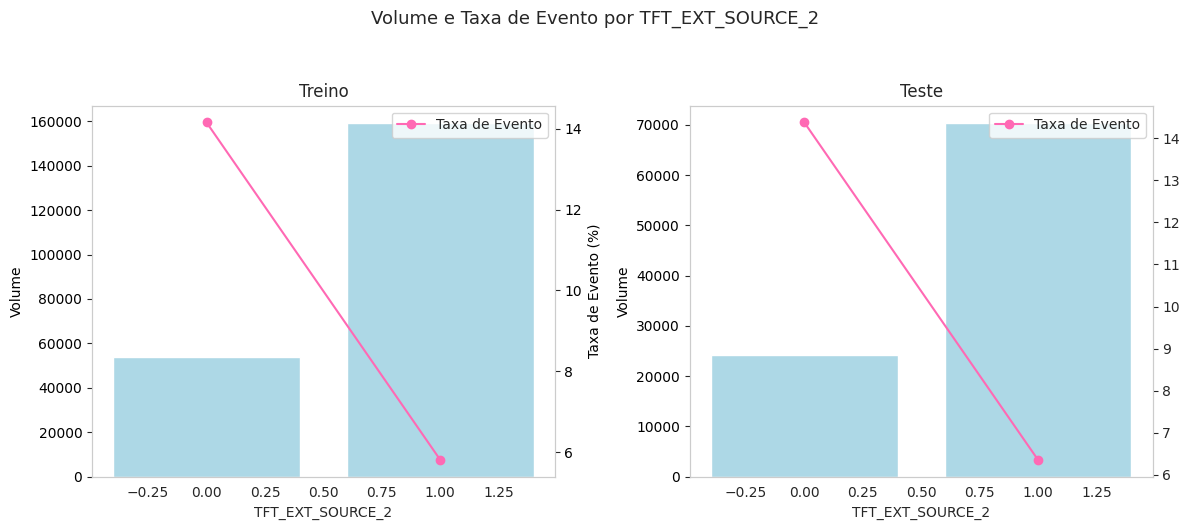

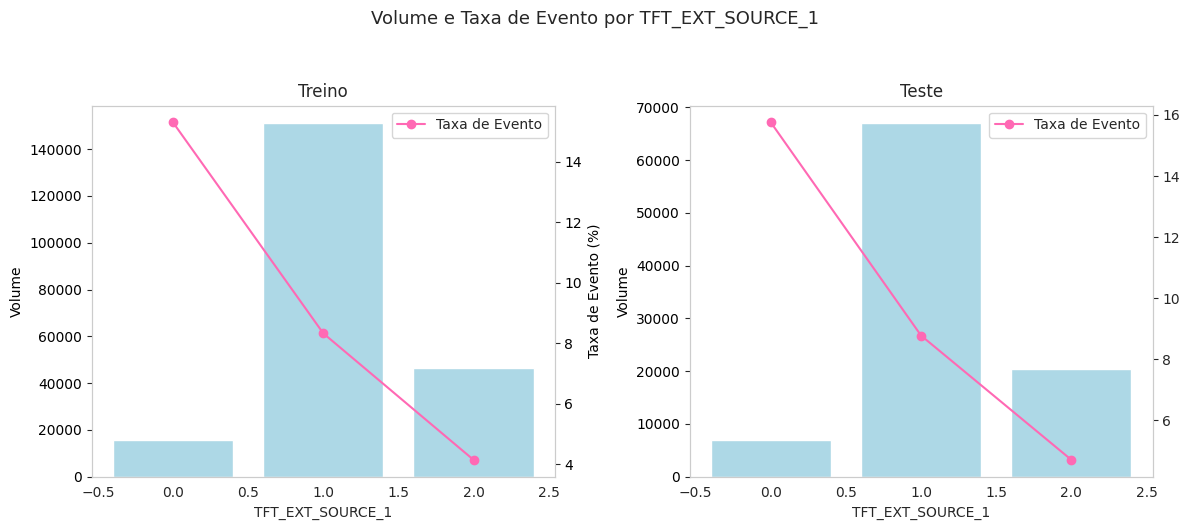

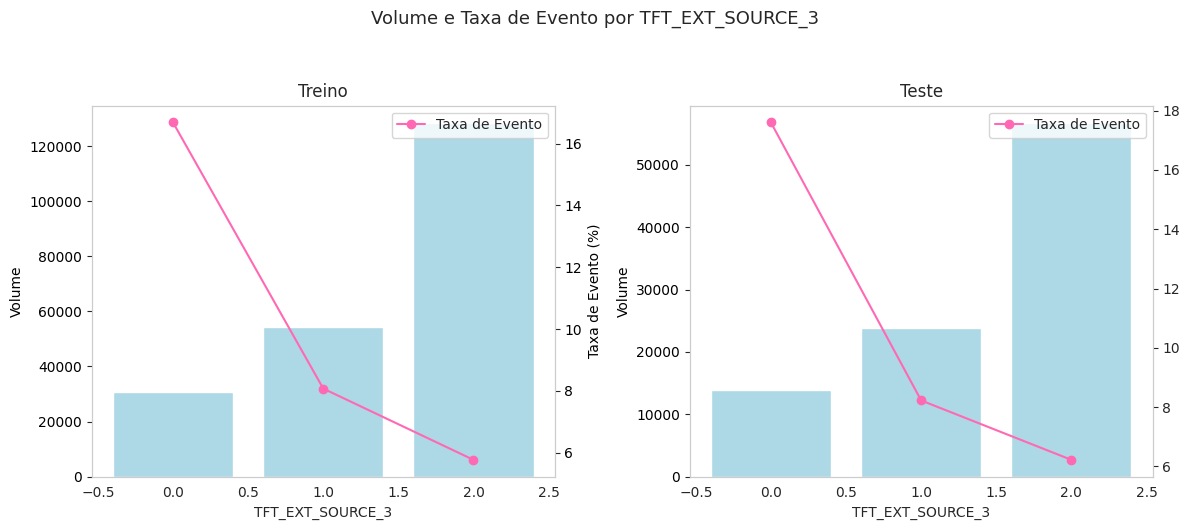

In [ ]:
# Visualizando a ordenação das categorias criadas
# Exibe para os dados de treino e de teste
for i in vars_alta_card:
  result = analyze_variable_train_and_test(abt_train_05, abt_test_05, f'TFT_{i}', "TARGET")    #f-string na definição do nome da variável

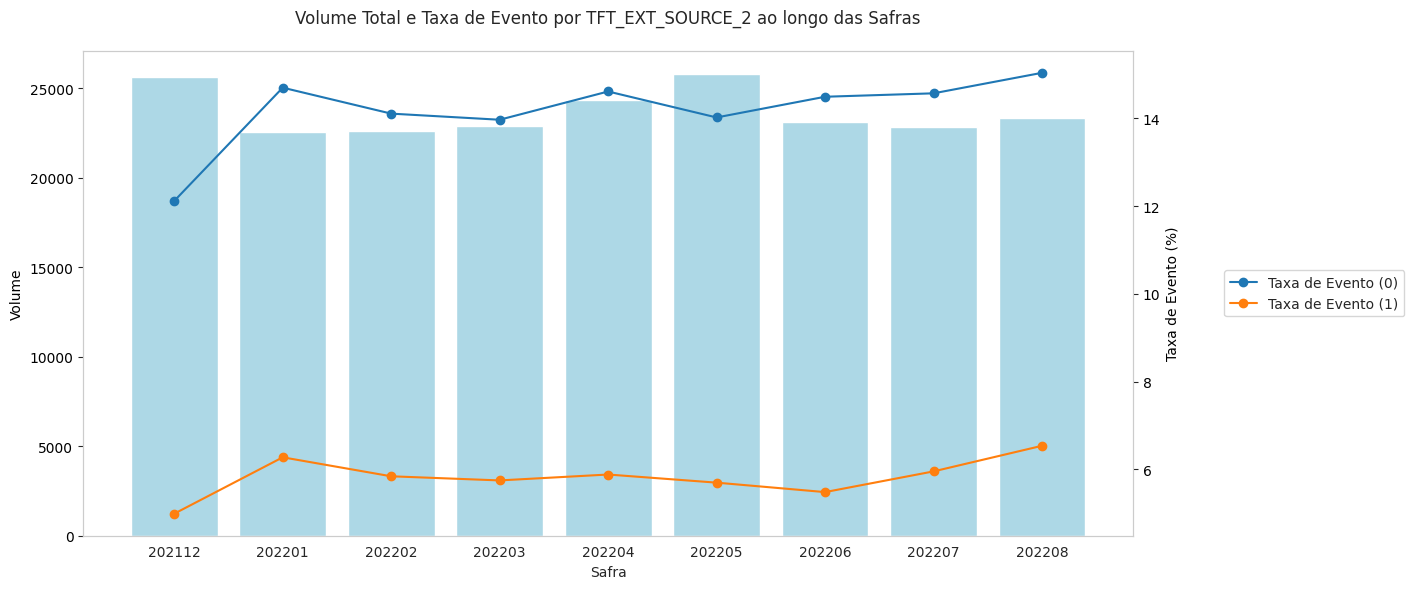

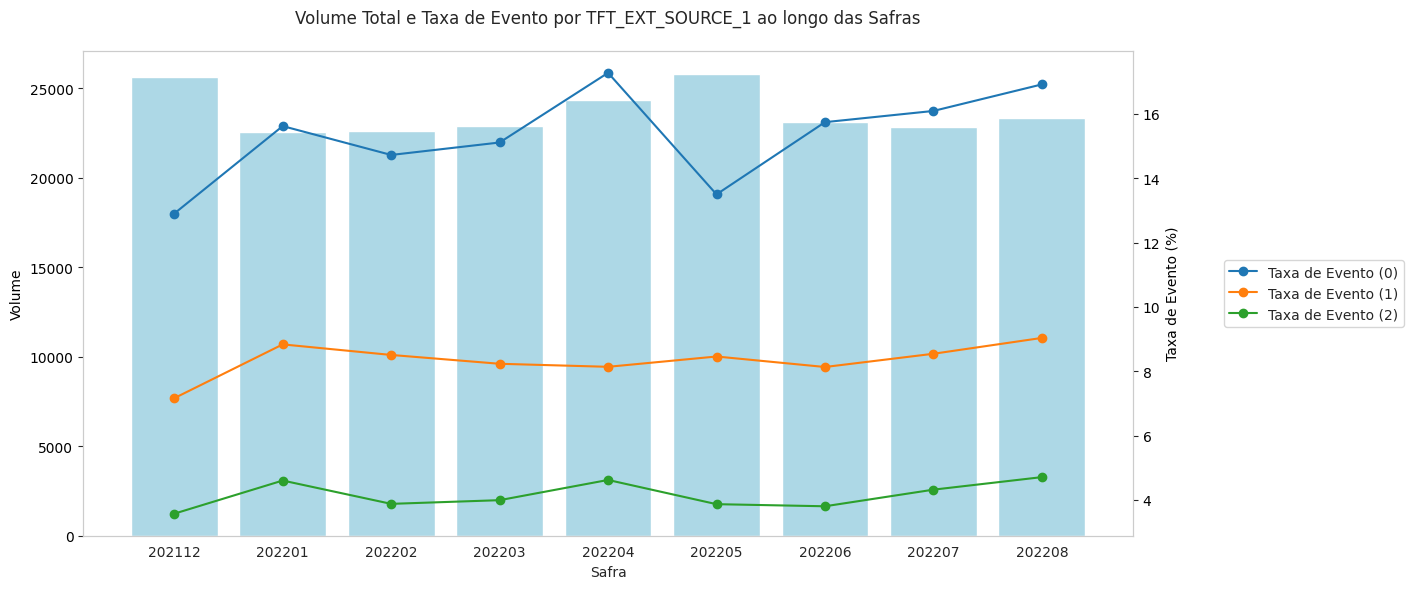

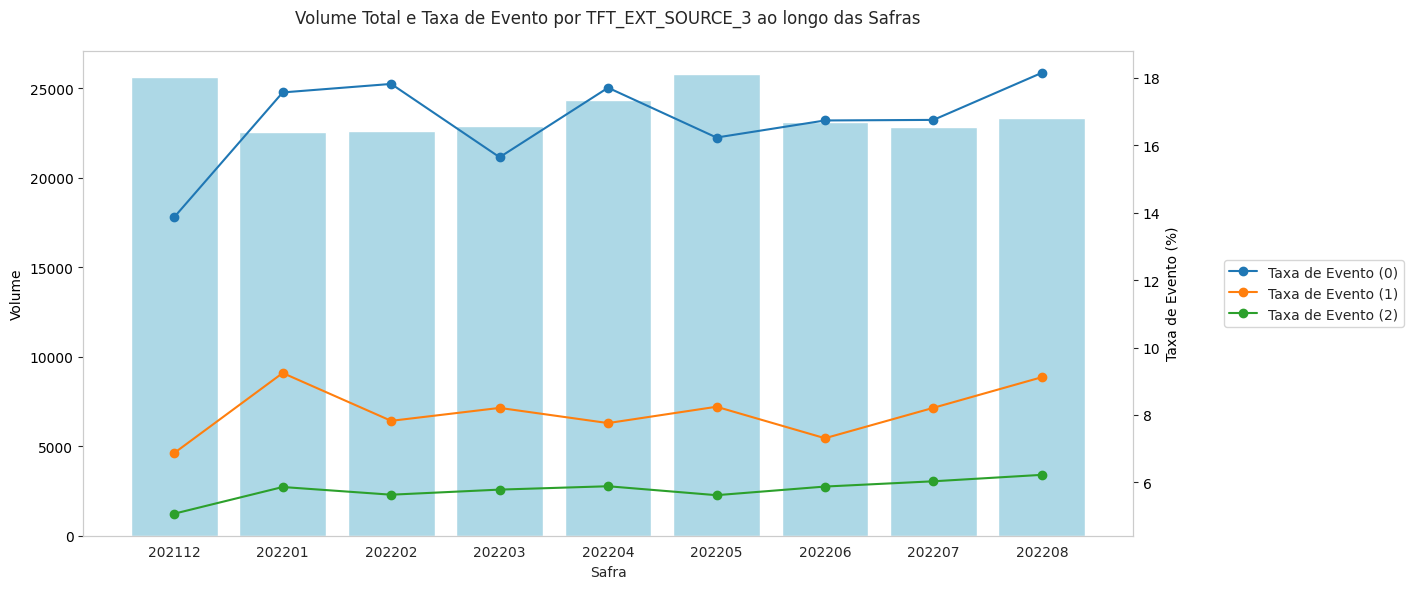

In [ ]:
# Verificando a estabilidade da taxa de evento por categoria e por safra

# Iterando pela lista das variáveis e plotando os gráficos
for var in vars_alta_card:
  plot_by_safra(abt_train_05, "TARGET", f'TFT_{var}', "DATA_REF")

In [ ]:
# Metadados
metadados_05 = report_data(abt_05)
metadados_05


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 1
Quantidade de features numéricas: 2               |    Quantidade de features categóricas 11
Cardinalidade total das categóricas: 59           |    Dataframe: 307511 linhas, 13 colunas



Feature    Tipo    Card  %Miss  %Out_sup  %Out_inf  \
0             NAME_CONTRACT_TYPE  object       2    0.0       0.0       0.0   
1                OCCUPATION_TYPE  object      19    0.0       0.0       0.0   
2                FLAG_DOCUMENT_3  object       2    0.0       0.0       0.0   
3                 FLAG_EMP_PHONE  object       2    0.0       0.0       0.0   
4               NAME_INCOME_TYPE  object       8    0.0       0.0       0.0   
5                         TARGET   int64       2    0.0       8.1       0.0   
6                       DATA_REF  object      13    0.0       0.0       0.0   
7   TFB_DEF_30_CNT_SOCIAL_CIRCLE  object       2    0.0       0.0       0.0   
8        TFB_NAME_EDUCATION_TYPE  object       3    0.0       0.0       0.0   
9               TFT_EXT_SOURCE_2  object       2    0.0       0.0       0.0   
10              TFT_EXT_SOURCE_1  object       3    0.0       0.0       0.0   
11              TFT_EXT_SOURCE_3  object       3    0.0       0.0       0.0   
12                    SK_ID_CURR   int64  307511    0.0       0.0       0.0   

    %Outliers                           Moda  %Freq  
0         0.0                     Cash loans   90.5  
1         0.0                       sem-info   31.3  
2         0.0                              1   71.0  
3         0.0                              1   82.0  
4         0.0                        Working   51.6  
5         8.1                            0.0   91.9  
6         0.0                         202205    8.4  
7         0.0                            0.0   88.6  
8         0.0  Secondary / secondary special   74.4  
9         0.0                            1.0   74.6  
10        0.0                            1.0   70.9  
11        0.0                            2.0   60.1  
12        0.0                       100002.0    0.0

#Regressão Logística

In [ ]:
# # Valores missing nos dados de teste causados pelo
# fato de essas categorias não estarem presentes
# nos dados de treino
# Para verificar, veja as categorias no gráfico de ordenação
# de treino e no gráfico de ordenação de teste.

print(abt_test_05[lista_onehot_categorizacao].isnull().sum())

NAME_CONTRACT_TYPE              0
OCCUPATION_TYPE                 0
FLAG_DOCUMENT_3                 0
FLAG_EMP_PHONE                  0
NAME_INCOME_TYPE                0
TFB_DEF_30_CNT_SOCIAL_CIRCLE    2
TFB_NAME_EDUCATION_TYPE         0
TFT_EXT_SOURCE_2                0
TFT_EXT_SOURCE_1                0
TFT_EXT_SOURCE_3                0
dtype: int64


In [ ]:
# Encontrando o indice dos valores NaN para subtituí-los
abt_test_05.loc[abt_test_05['TFB_DEF_30_CNT_SOCIAL_CIRCLE'].isna() == True , ['SK_ID_CURR','TFB_DEF_30_CNT_SOCIAL_CIRCLE']]

SK_ID_CURR TFB_DEF_30_CNT_SOCIAL_CIRCLE
68237      329624                          NaN
69823      272071                          NaN

In [ ]:
# Substituindo por categorias
abt_test_05.loc[68237,'TFB_DEF_30_CNT_SOCIAL_CIRCLE']='2.0'
abt_test_05.loc[69823	,'TFB_DEF_30_CNT_SOCIAL_CIRCLE']='2.0'

In [ ]:
# Isolando o ID
id_train = abt_train_05['SK_ID_CURR']
id_test = abt_test_05['SK_ID_CURR']

# Isolando a Safra
safra_train = abt_train_05['DATA_REF']
safra_test = abt_test_05['DATA_REF']

# Separando novamente dados X e y de treino e teste
X_train_05 = abt_train_05.drop(['SK_ID_CURR' , 'TARGET' , 'DATA_REF'] , axis=1) # Se colocar 'inplace' vai dropar na abt
X_test_05 = abt_test_05.drop(['SK_ID_CURR' , 'TARGET' , 'DATA_REF'] , axis=1) # Se colocar 'inplace' vai dropar na abt
y_train_05 = abt_train_05['TARGET']
y_test_05 = abt_test_05['TARGET']


# Lista de variáveis que passarão por OneHotEcoder (todas, menos coluna de TRAGET e de ID)
lista_onehot_categorizacao = list(X_train_05.columns)
print('Lista de vars para OneHot Encoding:\n')
for i in lista_onehot_categorizacao:
  print(f'- {i}')


# Instanciando o encoder
from sklearn.preprocessing import OneHotEncoder
encoder_categorizacao = OneHotEncoder(drop='first', sparse_output=False)

# Aplicando o one-hot encoding nos dados de treino
encoded_data = encoder_categorizacao.fit_transform(X_train_05[lista_onehot_categorizacao])
encoded_cols = encoder_categorizacao.get_feature_names_out(lista_onehot_categorizacao)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=X_train_05.index)
X_train_06 = pd.concat([X_train_05.drop(lista_onehot_categorizacao, axis=1), encoded_df], axis=1)

# Aplicando o one-hot encoding nos dados de teste
encoded_data_test = encoder_categorizacao.transform(abt_test_05[lista_onehot_categorizacao])
encoded_cols_test = encoder_categorizacao.get_feature_names_out(lista_onehot_categorizacao)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=X_test_05.index)
X_test_06 = pd.concat([X_test_05.drop(lista_onehot_categorizacao, axis=1), encoded_df_test], axis=1)

# Restaurando a Target
y_train_06 = y_train_05.copy()
y_test_06 = y_test_05.copy()

Lista de vars para OneHot Encoding:

- NAME_CONTRACT_TYPE
- OCCUPATION_TYPE
- FLAG_DOCUMENT_3
- FLAG_EMP_PHONE
- NAME_INCOME_TYPE
- TFB_DEF_30_CNT_SOCIAL_CIRCLE
- TFB_NAME_EDUCATION_TYPE
- TFT_EXT_SOURCE_2
- TFT_EXT_SOURCE_1
- TFT_EXT_SOURCE_3


In [ ]:
# Criando as tabelas analíticas de treino e teste
abt_train_06 = X_train_06.copy()
abt_test_06 = X_test_06.copy()

# Restaurando os ID's
abt_train_06['SK_ID_CURR'] = id_train
abt_test_06['SK_ID_CURR'] = id_test

# Restaurando as Safras
abt_train_06['DATA_REF'] = safra_train
abt_test_06['DATA_REF'] = safra_test


# Restaurando a target
abt_train_06['TARGET'] = y_train_06
abt_test_06['TARGET'] = y_test_06


# Restaurando a tabela analítica de modelagem completa
abt_06 = pd.concat([abt_train_06 , abt_test_06], axis=0)

#Metadados
metadados_06 = report_data(abt_06)
metadados_06


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 0
Quantidade de features numéricas: 38              |    Quantidade de features categóricas 1
Cardinalidade total das categóricas: 13           |    Dataframe: 307511 linhas, 39 colunas



Feature     Tipo    Card  %Miss  \
0                  NAME_CONTRACT_TYPE_Revolving loans  float64       2    0.0   
1                      OCCUPATION_TYPE_Cleaning staff  float64       2    0.0   
2                       OCCUPATION_TYPE_Cooking staff  float64       2    0.0   
3                          OCCUPATION_TYPE_Core staff  float64       2    0.0   
4                             OCCUPATION_TYPE_Drivers  float64       2    0.0   
5                            OCCUPATION_TYPE_HR staff  float64       2    0.0   
6               OCCUPATION_TYPE_High skill tech staff  float64       2    0.0   
7                            OCCUPATION_TYPE_IT staff  float64       2    0.0   
8                            OCCUPATION_TYPE_Laborers  float64       2    0.0   
9                  OCCUPATION_TYPE_Low-skill Laborers  float64       2    0.0   
10                           OCCUPATION_TYPE_Managers  float64       2    0.0   
11                     OCCUPATION_TYPE_Medicine staff  float64       2    0.0   
12              OCCUPATION_TYPE_Private service staff  float64       2    0.0   
13                      OCCUPATION_TYPE_Realty agents  float64       2    0.0   
14                        OCCUPATION_TYPE_Sales staff  float64       2    0.0   
15                        OCCUPATION_TYPE_Secretaries  float64       2    0.0   
16                     OCCUPATION_TYPE_Security staff  float64       2    0.0   
17               OCCUPATION_TYPE_Waiters/barmen staff  float64       2    0.0   
18                           OCCUPATION_TYPE_sem-info  float64       2    0.0   
19                                  FLAG_DOCUMENT_3_1  float64       2    0.0   
20                                   FLAG_EMP_PHONE_1  float64       2    0.0   
21              NAME_INCOME_TYPE_Commercial associate  float64       2    0.0   
22                   NAME_INCOME_TYPE_Maternity leave  float64       2    0.0   
23                         NAME_INCOME_TYPE_Pensioner  float64       2    0.0   
24                     NAME_INCOME_TYPE_State servant  float64       2    0.0   
25                           NAME_INCOME_TYPE_Student  float64       2    0.0   
26                        NAME_INCOME_TYPE_Unemployed  float64       2    0.0   
27                           NAME_INCOME_TYPE_Working  float64       2    0.0   
28                   TFB_DEF_30_CNT_SOCIAL_CIRCLE_2.0  float64       2    0.0   
29            TFB_NAME_EDUCATION_TYPE_Lower secondary  float64       2    0.0   
30  TFB_NAME_EDUCATION_TYPE_Secondary / secondary ...  float64       2    0.0   
31                                 TFT_EXT_SOURCE_2_1  float64       2    0.0   
32                                 TFT_EXT_SOURCE_1_1  float64       2    0.0   
33                                 TFT_EXT_SOURCE_1_2  float64       2    0.0   
34                                 TFT_EXT_SOURCE_3_1  float64       2    0.0   
35                                 TFT_EXT_SOURCE_3_2  float64       2    0.0   
36                                         SK_ID_CURR    int64  307511    0.0   
37                                           DATA_REF   object      13    0.0   
38                                             TARGET    int64       2    0.0   

    %Out_sup  %Out_inf  %Outliers      Moda  %Freq  
0        9.5       0.0        9.5       0.0   90.5  
1        1.5       0.0        1.5       0.0   98.5  
2        1.9       0.0        1.9       0.0   98.1  
3        9.0       0.0        9.0       0.0   91.0  
4        6.0       0.0        6.0       0.0   94.0  
5        0.2       0.0        0.2       0.0   99.8  
6        3.7       0.0        3.7       0.0   96.3  
7        0.2       0.0        0.2       0.0   99.8  
8       17.9       0.0       17.9       0.0   82.1  
9        0.7       0.0        0.7       0.0   99.3  
10       6.9       0.0        6.9       0.0   93.1  
11       2.8       0.0        2.8       0.0   97.2  
12       0.9       0.0        0.9       0.0   99.1  
13       0.2       0.0        0.2       0.0   99.8  
14      10

In [ ]:
import statsmodels.api as sm

def logistic_regression_with_scorecard(data, target_var, features):
    # Adicionando uma constante ao dataset (intercepto)
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística
    # model = sm.Logit(data[target_var], data[features + ['const']]).fit()
    model = sm.Logit(data[target_var], data[features + ['const']]).fit_regularized(alpha=1.0, method='l1')   #Regularizado

    # Coletando p-valores e estatísticas de Wald
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard

In [ ]:
# Lista das Features da Regressão Logística
features_reg_log = list(X_train_06.columns)

# Chamando modelo
model, scorecard = logistic_regression_with_scorecard(abt_train_06, 'TARGET', features_reg_log)

# Salva o scorecard em excel
scorecard.to_excel('scorecard.xlsx')

# Visualiza
scorecard

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.25473131848102737
            Iterations: 603
            Function evaluations: 603
            Gradient evaluations: 603


/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 12 out of 37 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


Beta Coefficient  \
TFT_EXT_SOURCE_3_2                                     -1.096852e+00   
TFT_EXT_SOURCE_2_1                                     -8.474559e-01   
TFT_EXT_SOURCE_3_1                                     -7.515417e-01   
TFT_EXT_SOURCE_1_2                                     -9.991400e-01   
TFT_EXT_SOURCE_1_1                                     -4.414054e-01   
TFB_NAME_EDUCATION_TYPE_Secondary / secondary s...      3.294038e-01   
TFB_DEF_30_CNT_SOCIAL_CIRCLE_2.0                        2.460733e-01   
NAME_CONTRACT_TYPE_Revolving loans                     -3.356188e-01   
TFB_NAME_EDUCATION_TYPE_Lower secondary                 5.489116e-01   
FLAG_DOCUMENT_3_1                                       1.718401e-01   
OCCUPATION_TYPE_Drivers                                 4.686969e-01   
OCCUPATION_TYPE_Low-skill Laborers                      6.777559e-01   
OCCUPATION_TYPE_Laborers                                3.411989e-01   
OCCUPATION_TYPE_Security staff                          4.209223e-01   
OCCUPATION_TYPE_Sales staff                             3.072082e-01   
OCCUPATION_TYPE_Cooking staff                           3.025231e-01   
OCCUPATION_TYPE_Waiters/barmen staff                    3.656717e-01   
OCCUPATION_TYPE_sem-info                                1.801536e-01   
OCCUPATION_TYPE_Cleaning staff                          2.354544e-01   
OCCUPATION_TYPE_Managers                                1.406998e-01   
OCCUPATION_TYPE_Realty agents                           3.065948e-01   
OCCUPATION_TYPE_IT staff                                3.071732e-01   
OCCUPATION_TYPE_HR staff                                2.250786e-01   
OCCUPATION_TYPE_Secretaries                             1.357454e-01   
FLAG_EMP_PHONE_1                                       -7.787210e-01   
OCCUPATION_TYPE_Private service staff                   7.827512e-02   
OCCUPATION_TYPE_Core staff                              3.012120e-02   
NAME_INCOME_TYPE_Unemployed                             1.098466e+00   
NAME_INCOME_TYPE_Pensioner                             -1.036634e+00   
const                                                  -4.880213e-01   
NAME_INCOME_TYPE_State servant                         -2.109363e-01   
OCCUPATION_TYPE_Medicine staff                         -5.974304e-03   
NAME_INCOME_TYPE_Student                               -1.830731e-01   
NAME_INCOME_TYPE_Working                                1.120316e-01   
OCCUPATION_TYPE_High skill tech staff                   8.251430e-18   
NAME_INCOME_TYPE_Commercial associate                   8.826093e-18   
NAME_INCOME_TYPE_Maternity leave                        4.425971e-19   

                                                          P-Value  \
TFT_EXT_SOURCE_3_2                                   0.000000e+00   
TFT_EXT_SOURCE_2_1                                   0.000000e+00   
TFT_EXT_SOURCE_3_1                                  8.248882e-244   
TFT_EXT_SOURCE_1_2                                  1.341685e-194   
TFT_EXT_SOURCE_1_1                                   2.160645e-68   
TFB_NAME_EDUCATION_TYPE_Secondary / secondary s...   1.120337e-44   
TFB_DEF_30_CNT_SOCIAL_CIRCLE_2.0                     1.339879e-25   
NAME_CONTRACT_TYPE_Revolving loans                   1.028415e-18   
TFB_NAME_EDUCATION_TYPE_Lower secondary              9.535472e-16   
FLAG_DOCUMENT_3_1                                    1.874127e-13   
OCCUPATION_TYPE_Drivers                              5.015329e-13   
OCCUPATION_TYPE_Low-skill Laborers                   5.038495e-13   
OCCUPATION_TYPE_Laborers                             1.731380e-08   
OCCUPATION_TYPE_Security staff                       2.618402e-08   
OCCUPATION_TYPE_Sales staff                          8.287694e-07   
OCCUPATION_TYPE_Cooking staff                        1.162756e-04   
OCCUPATION_TYPE_Waiters/barmen staff                 2.747712e-03   
OCCUPATION_TYPE_sem-info                             3.519046e-03   
OCCU

In [ ]:
# Verificando a correlação entre as variáveis selecionadas

df_aux = X_train_06.copy()
df_aux['TARGET'] = y_train_06

# Calcula a matriz de correlação
correlation_matrix = df_aux.corr()

# Transforma a matriz em um DataFrame com a descrição desejada
correlation_df = pd.DataFrame(columns=['Variável 1 x Variável 2', 'Correlação'])
added_combinations = set()

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.index:
        if col1 != col2 and (col1, col2) not in added_combinations and (col2, col1) not in added_combinations:
            correlation_df = correlation_df.append({
                'Variável 1 x Variável 2': f'{col1} x {col2}',
                'Correlação': correlation_matrix.loc[col2, col1]  # Correção na ordem das variáveis
            }, ignore_index=True)
            added_combinations.add((col1, col2))

# Ordena o DataFrame por ordem decrescente de correlação
correlation_df = correlation_df.sort_values(by='Correlação', ascending=False)

# Exibe o resultado
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
correlation_df.head(10)

Variável 1 x Variável 2  \
499            OCCUPATION_TYPE_sem-info x NAME_INCOME_TYPE_Pensioner   
536                      FLAG_EMP_PHONE_1 x NAME_INCOME_TYPE_Working   
530         FLAG_EMP_PHONE_1 x NAME_INCOME_TYPE_Commercial associate   
513                             FLAG_DOCUMENT_3_1 x FLAG_EMP_PHONE_1   
125      OCCUPATION_TYPE_Core staff x NAME_INCOME_TYPE_State servant   
271                      OCCUPATION_TYPE_Laborers x FLAG_EMP_PHONE_1   
278              OCCUPATION_TYPE_Laborers x NAME_INCOME_TYPE_Working   
520                     FLAG_DOCUMENT_3_1 x NAME_INCOME_TYPE_Working   
418                   OCCUPATION_TYPE_Sales staff x FLAG_EMP_PHONE_1   
353  OCCUPATION_TYPE_Medicine staff x NAME_INCOME_TYPE_State servant   

     Correlação  
499    0.692925  
536    0.483621  
530    0.258577  
513    0.248423  
125    0.225352  
271    0.218536  
278    0.202875  
520    0.162691  
418    0.159791  
353    0.151935

In [ ]:
# Criando um corte na quantidade de variáveis do Scorecard
# corte_variaveis = list(scorecard.index[scorecard.index.map(lambda x: isinstance(x, str))][:num])

# if 'const' in corte_variaveis:
#   corte_variaveis.remove('const')

# # corte_variaveis

# Lista das Features da Regressão Logística
# features_reg_log = corte_variaveis.copy()


# # Chamando modelo
# model, scorecard = logistic_regression_with_scorecard(abt_train_06, 'TARGET', features_reg_log)
# # scorecard

In [ ]:
# Aplicando valor constante
X_train_06['const'] = 1.0
X_test_06['const'] = 1.0

# Obtendo probabilidade de ser EVENTO
abt_train_06['Score_1'] = model.predict(X_train_06[features_reg_log + ['const']]).round(4)
abt_test_06['Score_1'] = model.predict(X_test_06[features_reg_log+ ['const']]).round(4)

# Obtendo probabilidade de ser NÃO-EVENTO
abt_train_06['Score_0'] = 1- model.predict(X_train_06[features_reg_log + ['const']]).round(4)
abt_test_06['Score_0'] = 1 - model.predict(X_test_06[features_reg_log+ ['const']]).round(4)

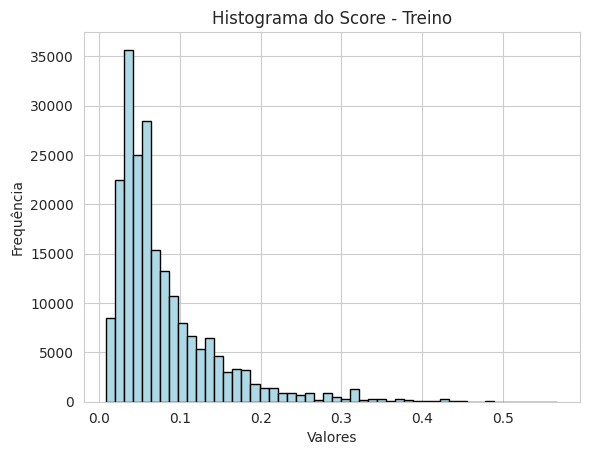

In [ ]:
# Plotando o histograma de treino
plt.hist(abt_train_06.Score_1, color='lightblue', bins=50, edgecolor='black')
plt.title("Histograma do Score - Treino")
plt.xlabel("Valores")
plt.ylabel("Frequência")
plt.show()

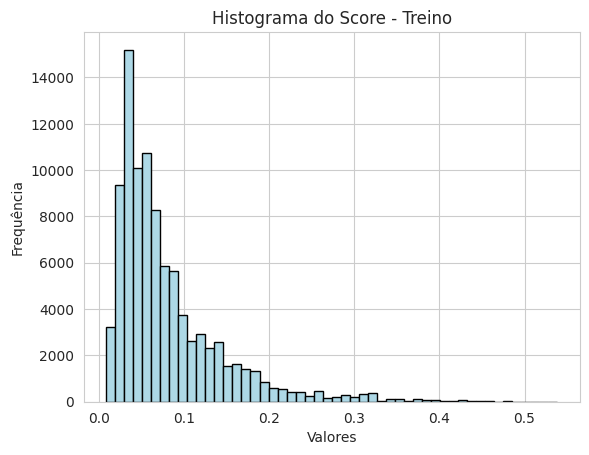

In [ ]:
# Plotando o histograma de teste
plt.hist(abt_test_06.Score_1, color='lightblue', bins=50, edgecolor='black')
plt.title("Histograma do Score - Treino")
plt.xlabel("Valores")
plt.ylabel("Frequência")
plt.show()

#Gráficos

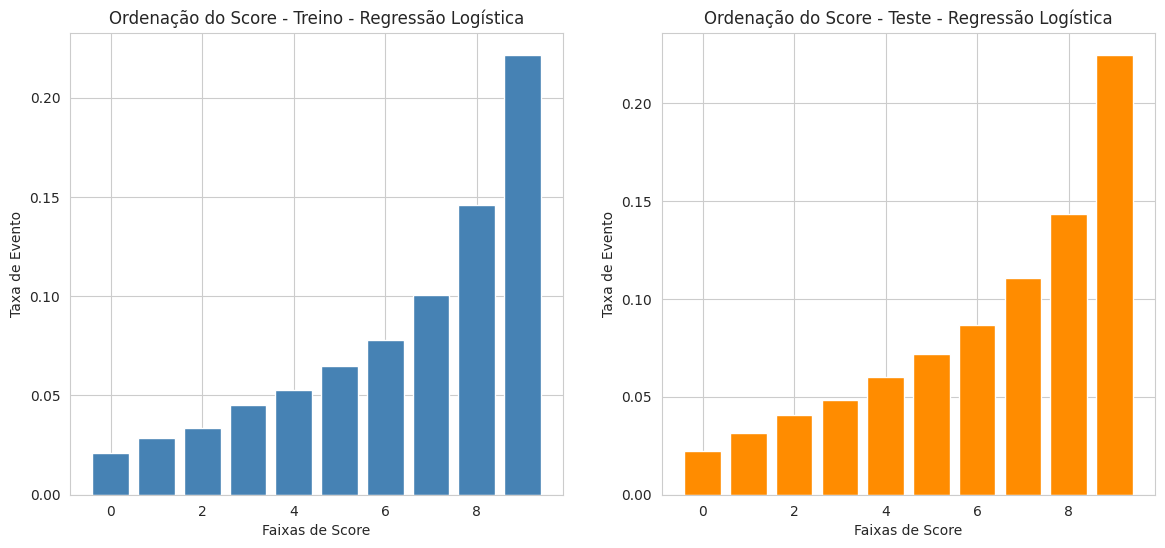

In [ ]:
# Visualizando aordenação dos scores - probabilidade de ser EVENTO
ordena_score2("Regressão Logística",
              X_train_06,
              X_test_06,
              y_train_06,
              y_test_06,
              abt_train_06['Score_1'],
              abt_test_06['Score_1'])

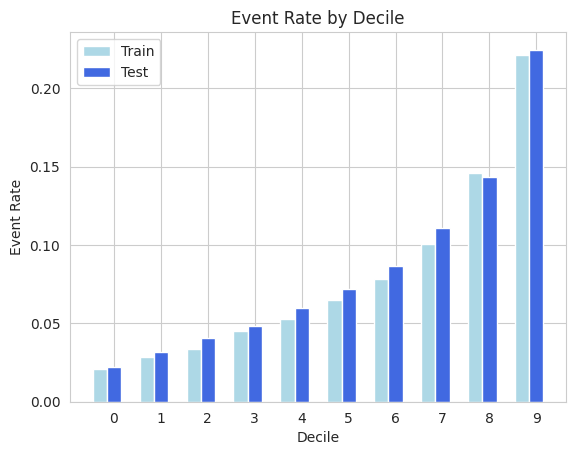

Metric  Train Value  Test Value
0     KS     0.320693    0.301511
1    AUC     0.714401    0.703656
2   Gini     0.428801    0.407312

In [ ]:
# Ordenaçao de Scores - probabilidade de ser NÂO-EVENTO
metrics, ord_score_train,ord_score_test = calculate_metrics2(abt_train_06, abt_test_06, 'Score_1', 'TARGET', bins=10)
metrics

In [ ]:
# Tabela de faixas de crédito - TREINO
ord_score_train

decile  min_score  max_score  event_rate  volume
0       0   0.008514   0.026417    0.020507   21310
1       1   0.026417   0.033591    0.029190   21309
2       2   0.033591   0.040780    0.033319   21309
3       3   0.040781   0.050069    0.044723   21309
4       4   0.050069   0.060495    0.053311   21309
5       5   0.060495   0.071258    0.064433   21309
6       6   0.071258   0.087082    0.078371   21309
7       7   0.087084   0.115625    0.101272   21309
8       8   0.115625   0.160082    0.145338   21309
9       9   0.160082   0.568103    0.222066   21309

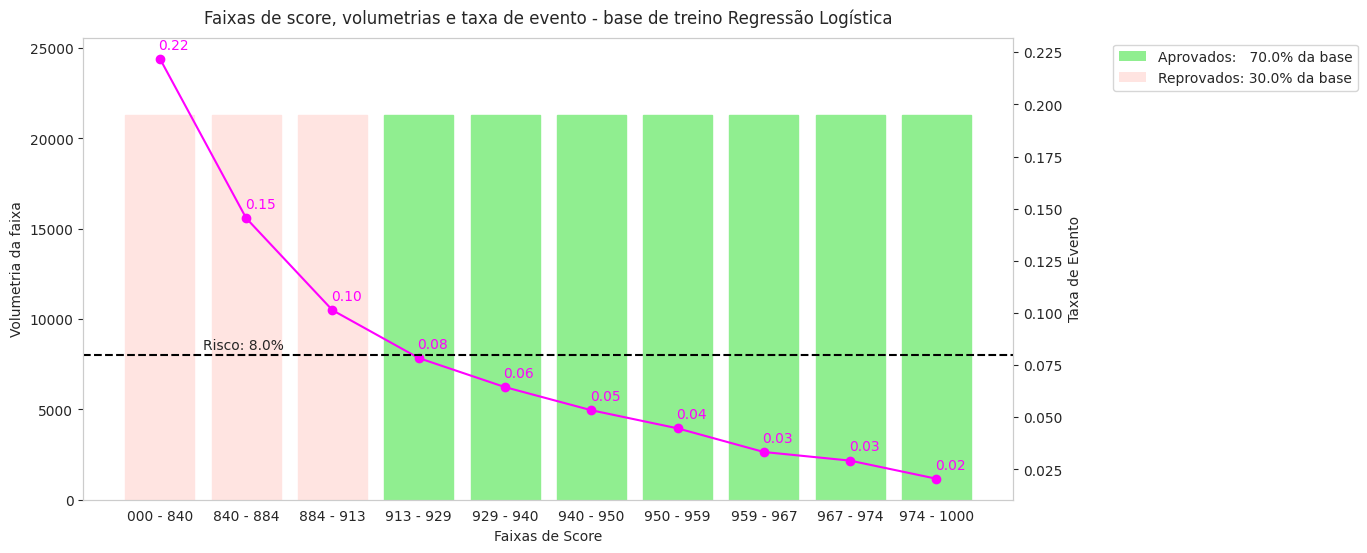

In [ ]:
# Análise da carteira dos dados de treino
lim_bins = carteira_treino2(model=model, name_model='Regressão Logística',
               risk = 0.08, X_train = X_train_06, y_train = y_train_06 , prob_train = abt_train_06['Score_0'])

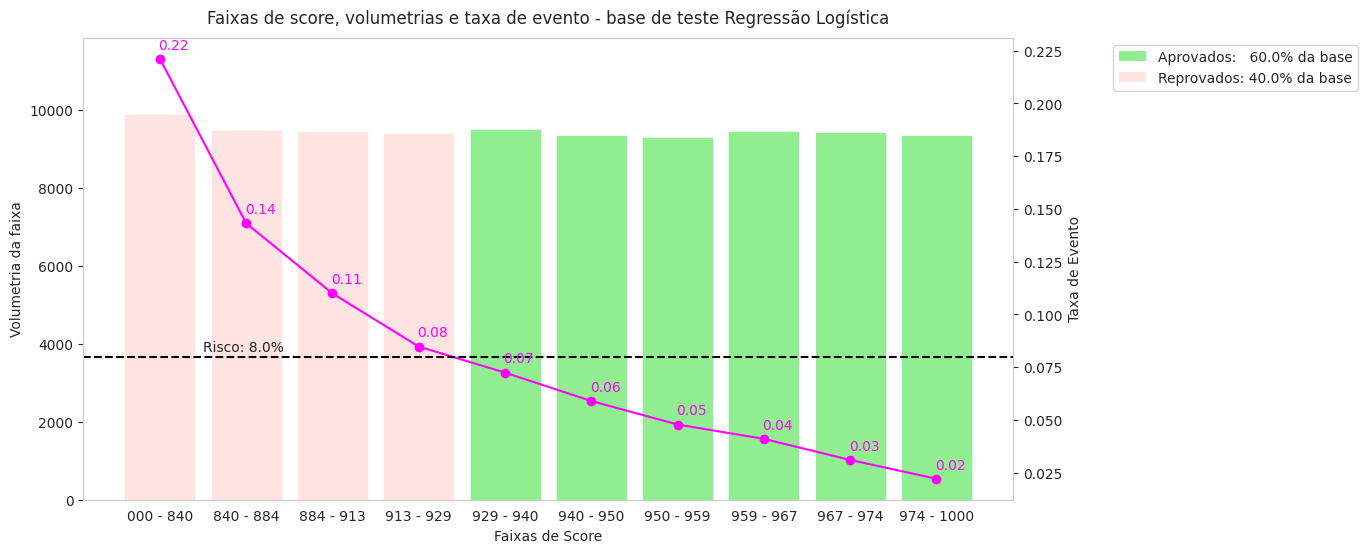

In [ ]:
# Análise da carteira dos dados de treino
carteira_teste2(faixas=lim_bins, model=model, name_model='Regressão Logística',
               risk = 0.08, X_test = X_test_06, y_test = y_test_06 , prob_test = abt_test_06['Score_0'])

In [ ]:
# Instalando a biblioteca Pycaret
!pip install pycaret

In [ ]:
df = abt_00.sample(frac=0.05)

In [ ]:
metadados_10 = report_data(df)


Quantidade de linhas duplicadas: 0                |    Quantidade de features com valores faltantes: 64
Quantidade de features numéricas: 106             |    Quantidade de features categóricas 16
Cardinalidade total das categóricas: 146          |    Dataframe: 15376 linhas, 122 colunas



In [ ]:
# Realizando a preparação dos dados
dataprep_10 = dataprep_out_of_time(df=df, target='TARGET', col_id='SK_ID_CURR', metadados=metadados_00,
                                  col_safra='DATA_REF', encoder_method='onehot+label', scaler=False,
                                  safra_min_train = '202112', safra_max_train='202208',
                                  safra_min_test='202209', safra_max_test='202212')

In [ ]:
# Restaurando a Tabela Analítica de Modelagem de TREINO
X_train_10 = dataprep_10.X_train_enc               # Restaura as variáveis explicativas
y_train_10 = dataprep_10.y_train                   # Restaura a target
id_train = dataprep_10.col_id_train                # Restaura o ID
safra_train = dataprep_10.col_safra_train          # Restaura a coluna de safra

abt_train_10 = pd.concat([X_train_10, y_train_10, id_train, safra_train] , axis=1)


# Restaurando a Tabela Analítica de Modelagem de TESTE
X_test_10 = dataprep_10.X_test_enc                 # Restaura as variáveis explicativas
y_test_10 = dataprep_10.y_test                     # Restaura a target
id_test = dataprep_10.col_id_test                  # Restaura o ID
safra_test = dataprep_10.col_safra_test            # Restaura a coluna de safra

abt_test_10 = pd.concat([X_test_10, y_test_10, id_test, safra_test] , axis=1)

# Tabela Analítica
abt_10 = pd.concat([abt_train_10 , abt_test_10] , axis=0)

In [ ]:
abt_10.head(3)

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
186214             0          157500.0    450000.0      22500.0   
107683             0           90000.0    113746.5       8932.5   
169862             0          103500.0    273636.0      21748.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
186214         450000.0                    0.035792      -22651   
107683         103500.0                    0.035792      -23637   
169862         247500.0                    0.010032      -12789   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
186214         365243            -5943.0            -4684  ...   
107683         365243            -2925.0            -4498  ...   
169862           -170            -6363.0            -4493  ...   

        WALLSMATERIAL_MODE_Others_dummy  WALLSMATERIAL_MODE_Panel_dummy  \
186214                              0.0                             0.0   
107683                              0.0                             0.0   
169862                              0.0                             0.0   

        WALLSMATERIAL_MODE_Stone, brick_dummy  \
186214                                    0.0   
107683                                    0.0   
169862                                    1.0   

        WALLSMATERIAL_MODE_Wooden_dummy  WALLSMATERIAL_MODE_sem-info_dummy  \
186214                              0.0                                1.0   
107683                              0.0                                1.0   
169862                              0.0                                0.0   

        EMERGENCYSTATE_MODE_Yes_dummy  EMERGENCYSTATE_MODE_sem-info_dummy  \
186214                            0.0                                 1.0   
107683                            0.0                                 1.0   
169862                            0.0                                 0.0   

        TARGET  SK_ID_CURR  DATA_REF  
186214       0      328849    202204  
107683       0      228451    202205  
169862       0      165444    202202  

[3 rows x 176 columns]

In [ ]:
# Importando os pacotes necessários
import pycaret
from pycaret.classification import *

# NOTA:
# Features categóricas de baixa cardinalidade => one_hot_encoder
# Features categóricas ordinais (Ex.: P, M, G) = ordinal_encoder
# Features categóricas de alta cardinalidade = LeaveOneOutEncoder
# Parâmetro None faz com o PyCaret identifique por si só

s = setup(
          data = df,              # DataFrame: Dataset que você deseja usar para modelagem.
          target = 'TARGET',      # str: Nome da coluna que você deseja prever.
          train_size = 0.7,       # float: Proporção do dataset para treinamento.
          test_data = None,       # DataFrame opcional para teste.
          ordinal_features=None,  # dict: Mapeamento de colunas ordinais e sua respectiva ordem.
          numeric_features=None,  # list: Lista de colunas tratadas como numéricas.
          categorical_features= None,  # list: Lista de colunas tratadas como categóricas.
          ignore_features=['SK_ID_CURR','DATA_REF'],  # list: Lista de colunas a serem ignoradas.
          preprocess=True,                   # bool: Se True, aplica preprocessamento.
          imputation_type='simple',          # str: Tipo de imputação ('simple' ou 'iterative').
          numeric_imputation='median',       # str: Imputação para colunas numéricas ('mean' ou 'median').
          categorical_imputation='sem-info', # str: Imputação para colunas categóricas ('mode' ou 'constant').
          normalize=True,                    # bool: Se True, normaliza as colunas numéricas.
          normalize_method='zscore',         # str: Método de normalização ('zscore', 'minmax' etc.).
          max_encoding_ohe = 2,              # Cardinalidade máxima para One Hot Encoder
          feature_selection=True,            # bool: Se True, aplica seleção automática de recursos.
          feature_selection_estimator = 'xgboost', #'lr','knn','nb','dt','svm','rf','gbc','xgboost','lightgbm','catboost','mlp','qda','ada','et','kmeans')
          n_features_to_select=10,                 # float: Proporção de recursos a serem mantidos.
          n_jobs=-1,                               # int: Número de cores a serem usados. -1 usa todos disponíveis.
          verbose=True                             # bool: Se True, imprime todas as mensagens.
                  )

In [ ]:
model_ids = [
              # 'lr',       # Regressão Logística
              'dt',       # Árvores de Decisão
              'rf',       # Random Forest
              # 'gbc' ,     # Gradient Boosting Classifier
              # 'xgboost',  # Extreme Gradient Boosting
              'lightgbm', # Light Gradient Boosting Machine
              # 'ada',      # AdaBoost Classifier
              # 'et'       # Extra Trees Classifier
           ]

# Comparando modelos
compared_models = compare_models( include=model_ids, sort='auc', n_select=1, verbose=True)

Processing:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
print(compared_models)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4541, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
model = create_model(
                    compared_models,  # ID do modelo como uma string ou um objeto de modelo personalizado.
                    fold=5,  # Número de folds a serem usadas na validação cruzada. Por padrão, usa 10 dobras.
                    round=4,  # Número de casas decimais para as métricas de avaliação.
                    cross_validation=True,  # Indica se a validação cruzada deve ser usada ou não.
                    fit_kwargs=None,  # Dicionário de argumentos passados para a função de ajuste do modelo.
                    groups=None,  # Grupos a serem usados para a validação cruzada estratificada.
                    experiment_custom_tags=None,  # Dicionário de tags personalizadas para serem anexadas ao experimento.
                    engine=None,  # O mecanismo a ser usado (pode ser 'sklearn', 'lightgbm', etc.).
                    verbose=True,  # Indica se a função deve imprimir a saída ou não.
                    return_train_score=False,  # Se True, retorna as pontuações de treinamento para cada dobra.
                    )

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4541, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [ ]:
tuned_model = tune_model(
    model, # Modelo que você deseja ajustar
    fold=5, # Número de dobras para validação cruzada k-fold
    round=4, # Número de casas decimais para arredondar a pontuação
    n_iter=2, # Número de iterações para o ajuste de hiperparâmetros
    custom_grid=None, # Grid personalizado para busca de hiperparâmetros
    optimize='auc', # Métrica para otimização
    custom_scorer=None, # Função personalizada de pontuação
    search_library='scikit-learn', # Biblioteca para busca de hiperparâmetros
    search_algorithm=None, # Algoritmo de busca para ajuste de hiperparâmetros
    early_stopping=False, # Ativar parada antecipada
    early_stopping_max_iters=10, # Número máximo de iterações para parada antecipada
    choose_better=True, # Escolher o melhor modelo entre o original e o ajustado
    fit_kwargs=None, # Argumentos adicionais para passar para a função de ajuste do modelo
    groups=None, # Grupos para validação cruzada baseada em grupos
    return_tuner=False, # Retornar o objeto do afinador de hiperparâmetros
    verbose=True, # Mostrar informações detalhadas durante a execução
    tuner_verbose=True, # Verbosidade do ajustador de hiperparâmetros
    return_train_score=False, # Retornar pontuação de treino no grid de resultados
)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
plot_model(tuned_model, plot='auc')

ImportError: cannot import name 'prod' from 'scipy._lib._util' (/usr/local/lib/python3.10/dist-packages/scipy/_lib/_util.py)